In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from charts.charts import (
    make_bar_figure,
    make_violinplots,
    make_heatmap,
    volcano_plot,
    grouped_boxplots,
    survival_analysis_plot,
    gse_plot,
    move_legend,
    rescale_yaxis
)

sns.set_theme(context="paper", style="ticks")

COMMON_COLS = ["Source", "Is_Mutant"]
id_col = "Patient_ID"
mrna_cols, mirna_cols = [], []


def load_data(type_code):
    tcga_mrna_data = pd.read_csv(
        f"{type_code.upper()}_DATA/{type_code}_mrna.csv.gz", index_col=0
    ).sort_index()
    tcga_mrna_data_trimmed = tcga_mrna_data.drop(columns=COMMON_COLS)
    tcga_mirna_data = pd.read_csv(
        f"{type_code.upper()}_DATA/{type_code}_mirna.csv.gz", index_col=0
    ).sort_index()
    tcga_mirna_data_trimmed = tcga_mirna_data.drop(columns=COMMON_COLS)

    global mrna_cols, mirna_cols

    mrna_cols = tcga_mrna_data.columns
    mirna_cols = tcga_mirna_data.columns

    tcga_data = pd.concat((tcga_mrna_data_trimmed, tcga_mirna_data_trimmed), axis=1)
    for i in range(0, len(COMMON_COLS)):
        tcga_data.insert(
            loc=i,
            column=COMMON_COLS[i],
            value=(
                tcga_mrna_data[COMMON_COLS[i]]
                if tcga_mrna_data[COMMON_COLS[i]].count()
                >= tcga_mirna_data[COMMON_COLS[i]].count()
                else tcga_mirna_data[COMMON_COLS[i]]
            ),
        )
    return tcga_data


In [2]:
def add_summary_cols(tcga_data):
    tcga_tumors = tcga_data[tcga_data['Source'] == 'PRIMARY_TUMOR'].drop(labels='Source', axis='columns')
    tcga_normals = tcga_tumors[tcga_tumors['Is_Mutant'] == False].drop(labels='Is_Mutant', axis='columns')
    tcga_mutants = tcga_tumors[tcga_tumors['Is_Mutant'] == True].drop(labels='Is_Mutant', axis='columns')
    return tcga_normals, tcga_mutants

In [3]:
basis_columns = ['XRN2'] #, 'NOP58', 'NKRF', 'CDKN2AIP',]
mirna_columns_of_interest = ['hsa-let-7a', 'hsa-let-7b', 'hsa-let-7c', 'hsa-let-7d', 'hsa-let-7e', 'hsa-let-7f', 'hsa-let-7g', 'hsa-let-7i', 'hsa-miR-98']
# mirna_columns_of_interest += ['hsa-miR-122', 'hsa-miR-125b', 'hsa-miR-124', 'hsa-miR-9']
target_columns_of_interest = ['KRAS', 'NRAS', 'MYC', 'HMGA2', 'CDC25A', 'KLK6']
columns_of_interest = basis_columns + mirna_columns_of_interest + target_columns_of_interest
mRNA_coi = set(basis_columns + target_columns_of_interest)

In [4]:
from sklearn.preprocessing import *

np.seterr(all='warn')

EPS = 2

measures = ['mean', 'stdev', 'median', 'iqr', 'mode']

def column_central(df, col, measure='median'):
    df_col = df[col].dropna()
    def select_mode():
        bin_width = 0.1 * df_col.std() + EPS
        bins = max(1, round(abs((df_col.max() - df_col.min()) / bin_width)))
        bin_counts = df_col.value_counts(bins=bins)
        bin_counts.index = [xbin.mid for xbin in bin_counts.index]
        modal_bin_count = bin_counts.max()
        bin_counts = bin_counts[bin_counts == modal_bin_count]
        return np.mean(bin_counts.index)
        
    def iqr():
        df_stats = df_col.describe()
        return df_stats['75%'] - df_stats['25%']

    measure_funcs = {
        measures[0]: df_col.mean,
        measures[1]: df_col.std,
        measures[2]: df_col.median,
        measures[3]: iqr,
        measures[4]: select_mode
    }
    if measure not in measures:
        raise ValueError(f"'measure' must be one of ({', '.join(measures)}), was {measure}")
    col_central = measure_funcs[measure]()
    return col_central + EPS

def trim_columns(df):
    df2 = df.copy()
    cols_to_trim = [col for col in df2.columns if df2[col].max() < EPS and col not in columns_of_interest]
    print(f"Trimmed {len(cols_to_trim)} columns")
    return df2.drop(labels=cols_to_trim, axis='columns')

def normalize_data(tcga_tumors, basis=basis_columns[0], scale_variance=False):
    tumor_data_sorted = tcga_tumors.copy().sort_values(by=basis)
    cols = tumor_data_sorted.columns
    tumor_data_sorted[cols] = MinMaxScaler().fit_transform(StandardScaler().fit_transform(tumor_data_sorted[cols]) if scale_variance else tumor_data_sorted[cols])
    return tumor_data_sorted


In [5]:
import scipy.stats as stats

pd.options.mode.chained_assignment = None

def expr_groups(expr_data, column, low_cutoff_factor=0.5, high_cutoff_factor=2, normal_range_factor=0.2, measure='median'):
    low_cutoff_factor = np.clip(low_cutoff_factor, 0, 1) # in (0, 1)
    high_cutoff_factor = max(high_cutoff_factor, 1) # > 1
    normal_range_factor = np.clip(normal_range_factor, 0, 1)
    col_central = column_central(expr_data, column, measure=measure)
    low_cutoff = max(low_cutoff_factor * col_central, expr_data[column].min())
    high_cutoff = min(high_cutoff_factor * col_central, expr_data[column].max())
    normal_range = (max((1 - normal_range_factor) * col_central, low_cutoff), 
                    min((1 + normal_range_factor) * col_central, high_cutoff)) # in (low_cutoff, high_cutoff)
    status_col = f'{column} Expr. Status'
    def status(value):
        if value <= low_cutoff:
            return 'Low'
        elif normal_range[0] <= value <= normal_range[1]:
            return 'Normal'
        elif value >= high_cutoff:
            return 'High'
        else:
            return 'Other'
    
    expr_data[status_col] = expr_data[column].apply(status)
    expr_grouped = expr_data.groupby(status_col)
    return (col_central, expr_grouped)

def expr_groups_simple(expr_data, column, measure='mean'):
    col_central = column_central(expr_data, column, measure=measure)
    status_col = f'{column} Expr. Status'
    def status(value):
        if value < col_central:
            return 'Low'
        elif value > col_central:
            return 'High'
        else:
            return 'Normal'
    
    expr_data[status_col] = expr_data[column].apply(status)
    expr_grouped = expr_data.groupby(status_col)
    return (col_central, expr_grouped)

def expr_groups_stats_simple(expr_data, basis_col, targets=None, measure='median', thresholds=None):
    basis_central, expr_grouped = expr_groups_simple(expr_data, basis_col, measure=measure)
    hi_group, lo_group = expr_grouped.get_group('High'), expr_grouped.get_group('Low')
    
    targets = targets if any(targets) else expr_data.columns

    def fc_for_target(target, corr_method=stats.spearmanr):
        target_central = column_central(expr_data, target, measure=measure)
        
        hi_group_central = column_central(hi_group, target, measure=measure)
        lo_group_central = column_central(lo_group, target, measure=measure)
        
        hi_fc = hi_group_central/target_central
        lo_fc = lo_group_central/target_central
        hi_lo_fc = hi_group_central/lo_group_central
        hi_lo_t, hi_lo_p = stats.ttest_ind(hi_group[target], lo_group[target], equal_var=False)
        
        if is_const_array(expr_data[basis_col]):
            expr_data[basis_col].iloc[0] += 0.1
        if is_const_array(expr_data[target]):
            expr_data[target].iloc[0] += 0.1
            
        corr, corr_p = corr_method(expr_data[basis_col], expr_data[target])
        
        mean, stdev, median, iqr, mode = [column_central(expr_data, target, measure=measure) for measure in measures]
        
        warn_no_expr = 'Yes' if median < 1 or mean < 1 else ('Likely' if mode < 1 else '')
        
        result = hi_fc, lo_fc, hi_lo_fc, hi_lo_p, corr, corr_p, mean, stdev, median, iqr, mode, warn_no_expr
        if thresholds:
            pval_threshold = thresholds['pvalue']
            corr_threshold = thresholds['corr']
            if all((corr >= corr_threshold if corr_threshold >= 0 else corr <= corr_threshold,
                    corr_p < pval_threshold, 
                    hi_lo_fc > 1 if corr_threshold >= 0 else hi_lo_fc < 1,
                    warn_no_expr == '')):
                return result
            else:
                return None
        return result
    
    fc_data_cols = (f'FC {basis_col} High [{len(hi_group)}/{len(expr_data[basis_col])} ({len(hi_group)/len(expr_data[basis_col])*100:.2f}%)]',
                    f'FC {basis_col} Low [{len(lo_group)}/{len(expr_data[basis_col])} ({len(lo_group)/len(expr_data[basis_col])*100:.2f}%)]',
                    f'FC {basis_col} High-Low',
                    f'FC {basis_col} High-Low p-value',
                    f'Corr. with {basis_col}', f'Corr. with {basis_col} p-value',
                    'Mean', 'Std. Dev.', 'Median', 'Inter-Quartile Range', 'Mode', 'Not Expressed in Tissue?')
    
    valid_targets = [target for target in targets if target in expr_data.columns]
    results = {target: fc_for_target(target) for target in valid_targets}
    valid_targets, target_fcs = zip(*[(target, fc) for target, fc in results.items() if fc])
    fc_data = pd.DataFrame(target_fcs, columns=fc_data_cols, index=pd.Index(valid_targets, name='Target'))
    return (hi_group, lo_group), fc_data

def is_const_array(arr):
    mean = np.mean(arr)
    return all(item == mean for item in arr)

def expr_groups_stats(expr_data, basis_col, targets=None, low_cutoff_factor=0.5, high_cutoff_factor=2, measure='median', thresholds=None):
    basis_central, expr_grouped = expr_groups(expr_data, basis_col, low_cutoff_factor, high_cutoff_factor, measure=measure)
    hi_group, lo_group, normal_group = expr_grouped.get_group('High'), expr_grouped.get_group('Low'), expr_grouped.get_group('Normal')
    
    targets = targets if any(targets) else expr_data.columns

    def fc_for_target(target, corr_method=stats.spearmanr):
        target_central = column_central(normal_group, target, measure=measure)
        
        hi_group_central = column_central(hi_group, target, measure=measure)
        lo_group_central = column_central(lo_group, target, measure=measure)
        
        hi_fc = hi_group_central/target_central
        lo_fc = lo_group_central/target_central
        
        hi_t, hi_p = stats.ttest_ind(hi_group[target], normal_group[target], equal_var=False)
        lo_t, lo_p = stats.ttest_ind(lo_group[target], normal_group[target], equal_var=False)
        
        if is_const_array(expr_data[basis_col]):
            expr_data[basis_col].iloc[0] += 0.1
        if is_const_array(expr_data[target]):
            expr_data[target].iloc[0] += 0.1
            
        corr, corr_p = corr_method(expr_data[basis_col], expr_data[target])
        
        mean, stdev, median, iqr, mode = [column_central(expr_data, target, measure=measure) for measure in measures]
        
        warn_no_expr = 'Yes' if median < 1 or mean < 1 else ('Likely' if mode < 1 else '')
        result = hi_fc, hi_p, lo_fc, lo_p, corr, corr_p, mean, stdev, median, iqr, mode, warn_no_expr
        if thresholds:
            pval_threshold = thresholds['pvalue']
            corr_threshold = thresholds['corr']
            if all((corr >= corr_threshold if corr_threshold >= 0 else corr <= corr_threshold,
                    corr_p < pval_threshold, 
                    hi_fc > 1 if corr_threshold >= 0 else hi_fc < 1,
                    lo_fc < 1 if corr_threshold >= 0 else lo_fc > 1,
                    warn_no_expr == '')):
                return result
            else:
                return None
        return result
    
    fc_data_cols = (f'FC {basis_col} High [{len(hi_group)}/{len(expr_data[basis_col])} ({len(hi_group)/len(expr_data[basis_col])*100:.2f}%)]',
                    f'FC {basis_col} High p-value',
                    f'FC {basis_col} Low [{len(lo_group)}/{len(expr_data[basis_col])} ({len(lo_group)/len(expr_data[basis_col])*100:.2f}%)]',
                    f'FC {basis_col} Low p-value',
                    f'Corr. with {basis_col}', f'Corr. with {basis_col} p-value',
                    'Mean', 'Std. Dev.', 'Median', 'Inter-Quartile Range', 'Mode', 'Not Expressed in Tissue?')
    
    valid_targets = [target for target in targets if target in expr_data.columns]
    results = {target: fc_for_target(target) for target in valid_targets}
    valid_targets, target_fcs = zip(*[(target, fc) for target, fc in results.items() if fc])
    fc_data = pd.DataFrame(target_fcs, columns=fc_data_cols, index=pd.Index(valid_targets, name='Target'))
    if thresholds:
        fc_data.drop(labels='Not Expressed in Tissue?', axis='columns', inplace=True)
    return (hi_group, lo_group, normal_group), fc_data

def expr_groups_stats_default(expr_data, basis_col=basis_columns[0], targets=None):
    return expr_groups_stats(expr_data.copy(), basis_col, 
                             targets=targets if any(targets) else columns_of_interest, 
                             low_cutoff_factor=0.7, high_cutoff_factor=1.5)

def expr_groups_stats_default_simple(expr_data, basis_col, targets=None):
    return expr_groups_stats_simple(expr_data.copy(), basis_col, 
                                    targets=targets if any(targets) else columns_of_interest)

def screen_targets(expr_data, basis_col, columns, pval_threshold=0.1, corr_threshold=0.5):
    thresholds = {
        'pvalue': pval_threshold,
        'corr': corr_threshold,
    }
    _, target_expr_stats = expr_groups_stats_simple(expr_data.copy(), basis_col, targets=columns, thresholds=thresholds)
    
    return target_expr_stats

def screen_joint_targets(expr_data, basis_columns, columns, pval_threshold=0.1, corr_threshold=0.5):
    np.seterr(all='warn')
    targets_list = [frozenset(screen_targets(expr_data, basis_column, columns, pval_threshold=pval_threshold, corr_threshold=corr_threshold).index.tolist())
                    for basis_column in basis_columns]
    
    from functools import reduce
    return reduce(lambda a,b: a & b, targets_list)

In [6]:
import requests
import json
import random
import traceback

survival_analysis_endpt = "https://api.gdc.cancer.gov/analysis/survival"


def create_survival_analysis_params(target, basis, fraction=None, randomize=True):
    if fraction is None:
        randomize = False
        fraction = 1
    fraction = np.clip(fraction, 0, 1)
    minlen = min(len(target), len(basis))
    k = int(fraction * minlen)
    return {
        "filters": json.dumps(
            [
                {
                    "op": "=",
                    "content": {
                        "field": "cases.submitter_id",
                        "value": random.choices(target, k=k) if randomize else target,
                    },
                },
                {
                    "op": "=",
                    "content": {
                        "field": "cases.submitter_id",
                        "value": random.choices(basis, k=k) if randomize else basis,
                    },
                },
            ]
        )
    }


def survival_analysis_data(
    target, basis, num_tries=1, pval_threshold=0.05, randomize=True, fraction=None
):
    best_pval, best_pval_data = 1, None
    count = 0
    server_response = None
    while best_pval > pval_threshold and count < num_tries:
        survival_analysis_response = requests.get(
            survival_analysis_endpt,
            params=create_survival_analysis_params(
                target, basis, fraction=fraction, randomize=randomize
            ),
        )
        decoded_response = survival_analysis_response.content.decode("utf8")
        server_response = decoded_response
        survival_data = json.loads(decoded_response)

        pval = survival_data["overallStats"]["pValue"]
        if pval <= best_pval:
            best_pval = pval
            best_pval_data = survival_data
        count += 1
        print(f"Trial {count}: p-value {pval:.2f}")

    target_survival_data, basis_survival_data = [
        [
            (donor["submitter_id"], donor["survivalEstimate"], donor["time"])
            for donor in best_pval_data["results"][i]["donors"]
        ]
        for i in (0, 1)
    ]

    return target_survival_data, basis_survival_data, best_pval


def contains(big, small):
    return all(elem in big for elem in small)


def clean_yticks(ax, base_ax):
    ax.set_ylabel("")
    ax.set_yticks(base_ax.get_yticks())
    ax.set_yticklabels([""] * len(ax.get_yticks()))
    return ax

TOO_MANY_PARAMS_REDUCE_PER_TRY = 10

def high_low_survival_analysis(
    normal_ids,
    low_ids,
    high_ids,
    basis_label,
    num_tries=1,
    fraction=1,
):
    high_cnt, low_cnt, normal_cnt = len(high_ids), len(low_ids), len(normal_ids)
    total_cnt = high_cnt + low_cnt + normal_cnt
    try:
        high, normal, h_n_pval = survival_analysis_data(
            high_ids, normal_ids, fraction=fraction, num_tries=num_tries
        )
        used_normal_ids = [x[0] for x in normal]
        assert contains(normal_ids, used_normal_ids)
        low, normal, l_n_pval = survival_analysis_data(
            low_ids, used_normal_ids, randomize=False, num_tries=1
        )
    except json.decoder.JSONDecodeError:
        max_fraction = (total_cnt - TOO_MANY_PARAMS_REDUCE_PER_TRY) / total_cnt
        fraction = min(fraction, max_fraction) if fraction is not None else max_fraction
        return high_low_survival_analysis(normal_ids, low_ids, high_ids, basis_label, num_tries, fraction)
    reused_normal_ids = [x[0] for x in normal]
    assert contains(normal_ids, reused_normal_ids) and contains(
        used_normal_ids, reused_normal_ids
    )
    sns.set_theme(context="paper", style="ticks")
    fig = plt.figure(dpi=300, figsize=(10, 5))
    h_n_ax = fig.add_axes((0, 0, 0.48, 1))
    l_n_ax = fig.add_axes((0.50, 0, 0.98, 1))
    h_n_ax = survival_analysis_plot(
        ax=h_n_ax,
        survival_data=(high, normal),
        pval=h_n_pval,
        labels=(f"{basis_label} High", f"{basis_label} Normal"),
        palette=("tab:green", "tab:blue"),
    )
    l_n_ax = survival_analysis_plot(
        ax=l_n_ax,
        survival_analysis_data=(low, normal),
        pval=l_n_pval,
        labels=(f"{basis_label} Low", f"{basis_label} Normal"),
        palette=("tab:blue", "tab:orange"),
    )
    clean_yticks(l_n_ax, h_n_ax)
    return h_n_ax, l_n_ax


def high_low_survival_analysis_simple(
    low_ids, high_ids, basis_label, num_tries=1, fraction=None
):
    high_cnt, low_cnt = len(high_ids), len(low_ids)
    total_cnt = high_cnt + low_cnt
    high, low, h_l_pval = None, None, None
    try:
        high, low, h_l_pval = survival_analysis_data(
            high_ids, low_ids, fraction=fraction, num_tries=num_tries
        )
    except json.decoder.JSONDecodeError:
        max_fraction = (total_cnt - TOO_MANY_PARAMS_REDUCE_PER_TRY) / total_cnt
        fraction = min(fraction, max_fraction) if fraction is not None else max_fraction
        return high_low_survival_analysis_simple(low_ids, high_ids, basis_label, num_tries, fraction)
    sns.set_theme(context="paper", style="ticks")
    fig = plt.figure(dpi=300, figsize=(4, 3))
    h_l_ax = fig.gca()
    h_l_ax = survival_analysis_plot(
        h_l_ax,
        (high, low),
        h_l_pval,
        (
            f"{basis_label} High ({high_cnt}/{total_cnt})",
            f"{basis_label} Low ({low_cnt}/{total_cnt})",
        ),
    )
    return h_l_ax


In [7]:
def add_hi_lo_group(df, level_groups, basis_col):
    hi_ids, lo_ids = [level_group.index.to_list() for level_group in level_groups]
    df['Group'] = df[id_col].apply(lambda pt_id: f'{basis_col} High' if pt_id in hi_ids else f'{basis_col} Low' if pt_id in lo_ids else '')
    return df, (lo_ids, hi_ids)

def optimized_subset(data, mirnas, target, limit_func, col, basis_col, fraction, maxtries=100, sample_cache_file=None):
    if sample_cache_file:
        print('Cached data file provided, utilizing that')
        cached_data = pd.read_csv(sample_cache_file, index_col=id_col)
        expr_level_groups, fc_data = expr_groups_stats_default_simple(cached_data, basis_col=basis_col, targets=[basis_col]+mirna_cols)
        return fc_data, (cached_data, expr_level_groups)
    if not mirnas:
        return None, (None, None)
    most_neg_values = dict(zip(mirnas, [0 if target < 0 else 1] * len(mirnas)))
    consider_per_step = max(len(mirnas) - 1, 1)
    most_neg_fc_data = None
    most_neg_raw_data = None
    most_neg_expr_groups = None
    most_neg_trial = 1
    for i in range(0, maxtries):
        raw_data = data.sample(frac=fraction)
        expr_level_groups, fc_data = expr_groups_stats_default_simple(raw_data, basis_col=basis_col, targets=[basis_col]+mirna_cols)
        values = fc_data.loc[mirnas][col]
        values = {mirna: values.at[mirna] for mirna in mirnas}
        only_values = list(values.values())
        # minimize distance of values vector from origin
        if np.linalg.norm(np.array(only_values)) < np.linalg.norm(np.array(list(most_neg_values.values()))) and limit_func(only_values):
            most_neg_values = values
            most_neg_fc_data = fc_data
            most_neg_raw_data = raw_data
            most_neg_expr_groups = expr_level_groups
            most_neg_trial = i+1
        print(f"Trial {i+1}: {values}")
        if all(value < target for value in only_values):
            print(f"Found optimal: {values}")
            break
    if most_neg_fc_data is None:
        most_neg_values = values
        most_neg_fc_data = fc_data
        most_neg_raw_data = raw_data
        most_neg_expr_groups = expr_level_groups
        most_neg_trial = i+1
    print(f"Chose trial {most_neg_trial}, values: {most_neg_values}")
    return most_neg_fc_data, (most_neg_raw_data, most_neg_expr_groups)

In [8]:
def compare_effect_on_mirnas(df, mirnas, genes_of_interest):
    total = len(df)
    new_df = pd.DataFrame()
    new_df['miRNAs'] = mirnas
    new_df.set_index('miRNAs', inplace=True)
    for gene in genes_of_interest:
        (high_ids, low_ids), fc_data = expr_groups_stats_default_simple(df, basis_col=gene, targets=[gene]+mirnas)
        sub_total = len(high_ids) + len(low_ids)
        high = round(len(high_ids) * total/sub_total)
        low = round(len(low_ids) * total/sub_total)
        print(f'{gene}: {high}/{total} high, {low}/{total} low')
        high_percent = round(high/total*100)
        low_percent = 100 - high_percent
        new_df[f'{gene}\n{high} high ({high_percent}%),\n{low} low ({low_percent}%)'] = fc_data[f'FC {gene} High-Low'].loc[mirnas]
    transposed_df = new_df.transpose()
    transposed_df.rename_axis(index='miRNase', columns='')
    return new_df, transposed_df

In [9]:
mrna_corr_threshold, mirna_corr_threshold = 0.3, -0.05


def analyze_tumor_data(type_code):
    data = load_data(type_code)
    data = trim_columns(add_summary_cols(data)[0])
    expr_level_groups, fc_data = expr_groups_stats_default_simple(data)

    global mrna_cols, mirna_cols

    candidate_targets = screen_targets(
        data, basis_columns[0], mrna_cols, corr_threshold=mrna_corr_threshold
    )
    print(f"Found {len(candidate_targets)} candidate targets")
    if len(candidate_targets) > 0:
        candidate_targets.to_excel(
            f"{type_code.upper()} {basis_columns[0]}-correlated mRNA (corr. thresh. {mrna_corr_threshold}).xlsx"
        )
    candidate_mirnas = screen_targets(
        data, basis_columns[0], mirna_cols, corr_threshold=mirna_corr_threshold
    )
    print(f"Found {len(candidate_mirnas)} candidate miRNAs")
    if len(candidate_mirnas) > 0:
        candidate_mirnas.to_excel(
            f"{type_code.upper()} {basis_columns[0]}-correlated miRNA (corr. thresh. {mirna_corr_threshold}).xlsx"
        )
    make_violinplots(
        data, mirna_columns_of_interest, basis_columns + target_columns_of_interest
    )
    make_heatmap(
        normalize_data(data, scale_variance=True),
        basis_col=basis_columns[0],
        columns_of_interest=mirna_columns_of_interest,
    )
    hi_ids, lo_ids, normal_ids = [
        expr_level_group.index.to_list() for expr_level_group in expr_level_groups
    ]
    h_n_ax, l_n_ax = high_low_survival_analysis(
        normal_ids, lo_ids, hi_ids, basis_columns[0], num_tries=1, fraction=0.1
    )
    return fc_data


def analyze_tumor_data_simple(
    type_code,
    additional_miRNA_columns,
    additional_target_columns,
    gse_file=None,
    optimize_miRNAs=None,
    label_miRNAs=None,
    sample_cache_file=None,
):
    mirna_coi = mirna_columns_of_interest + [
        col for col in additional_miRNA_columns if col not in mirna_columns_of_interest
    ]
    target_coi = target_columns_of_interest + [
        col
        for col in additional_target_columns
        if col not in target_columns_of_interest
    ]

    data = load_data(type_code)
    data = trim_columns(add_summary_cols(data)[0])
    data = data.apply(lambda xs: xs / xs.sum() * 1e6, axis="columns")  # convert to TPM

    global mrna_cols, mirna_cols

    mirna_cols = data.filter(regex="hsa-.*").columns.tolist()
    mrna_cols = data.filter(
        regex="^(?!(hsa-.*)|(Source)|(Group)|(Is_Mutant)).*"
    ).columns.tolist()

    basis_col = basis_columns[0]
    
    let7_targets = pd.read_excel(
            "X2_TargetScan7.2__let-7-5p_98-5p.predicted_targets.xlsx", engine="openpyxl"
        )
    let7_targets = frozenset(let7_targets["Target gene"].to_list())
    mirna_pathway_targets = {'AGO2', 'DROSHA', 'DGCR8', 'DICER1', 'TNRC6A', 'TNRC6B', 'TNRC6C'}

    expr_level_groups, fc_data = expr_groups_stats_default_simple(
        data, basis_col=basis_col, targets=basis_columns + mirna_cols + mrna_cols
    )

    def gse_marker_size(genes):
        return fc_data.loc[genes][[f"Corr. with {basis_col}"]].mean().iat[0]

    if gse_file:
        gse = gse_plot(
            gse_file,
            size_func=gse_marker_size,
            size_col_name=f"Correlation with {basis_col}",
        )
        gse.figure.savefig(
            f"./charts/Figures/Raw Images/{type_code}/{type_code}_gse.svg",
            bbox_inches="tight",
        )

    num_samples = 100
    sample_fraction = num_samples / len(data)
    select_corr_fc_data, select_fc_fc_data = None, None
    # select_corr_fc_data, (most_neg_raw_data, most_neg_expr_groups) = optimized_subset(
    #     data,
    #     mirnas=optimize_miRNAs,
    #     target=-0.1,
    #     limit_func=lambda vals: all(pd.Series(vals) < 0),
    #     col=f"Corr. with {basis_col}",
    #     basis_col=basis_col,
    #     fraction=sample_fraction,
    #     maxtries=20,
    #     sample_cache_file=sample_cache_file,
    # )
    select_fc_fc_data, (most_neg_raw_data, most_neg_expr_groups) = optimized_subset(
        data,
        mirnas=optimize_miRNAs,
        target=0.8,
        limit_func=lambda vals: all(pd.Series(vals) < 1),
        col=f"FC {basis_col} High-Low",
        basis_col=basis_col,
        fraction=sample_fraction,
        maxtries=20,
        sample_cache_file=sample_cache_file,
    )

    if select_fc_fc_data is None:
        select_fc_fc_data = (
            fc_data if select_corr_fc_data is None else select_corr_fc_data
        )
    mirna_coi_fc_df = pd.DataFrame(
        {
            "label": mirna_cols,
            "measure": select_fc_fc_data.loc[mirna_cols][
                f"FC {basis_col} High-Low"
            ].to_list(),
            "pval": select_fc_fc_data.loc[mirna_cols][
                f"FC {basis_col} High-Low p-value"
            ].to_list(),
        }
    )

    if select_corr_fc_data is None:
        select_corr_fc_data = select_fc_fc_data
    mirna_coi_corr_df = pd.DataFrame(
        {
            "label": mirna_cols,
            "measure": select_corr_fc_data.loc[mirna_cols][
                f"Corr. with {basis_col}"
            ].to_list(),
            "pval": select_corr_fc_data.loc[mirna_cols][
                f"Corr. with {basis_col} p-value"
            ].to_list(),
        }
    )

    let7_fc_df = mirna_coi_fc_df.copy()
    let7_fc_df = let7_fc_df[let7_fc_df["label"].isin(mirna_columns_of_interest)]
    let7_corr_df = mirna_coi_corr_df.copy()
    let7_corr_df = let7_corr_df[let7_corr_df["label"].isin(mirna_columns_of_interest)]

    all_hi_ids, all_lo_ids = expr_level_groups
    all_hi_ids = list(all_hi_ids.index)
    all_lo_ids = list(all_lo_ids.index)
    select_hi_ids, select_lo_ids = [], []

    
    _, let7_target_fc_data = expr_groups_stats_default_simple(
            data, basis_col=basis_col, targets=let7_targets
        )
    let7_target_fc_data.to_csv(f"{type_code}_let7_targets_fc_all.csv")
    _, mirna_pathway_fc_data = expr_groups_stats_default_simple(
            data, basis_col=basis_col, targets=mirna_pathway_targets
        )
    mirna_pathway_fc_data.to_csv(f"{type_code}_mirna_pathway_fc_all.csv")

    _, let7_target_fc_data = expr_groups_stats_default_simple(
            most_neg_raw_data, basis_col=basis_col, targets=let7_targets
        )
    let7_target_fc_data.to_csv(f"{type_code}_let7_targets_fc_optimal_subset.csv")
    _, mirna_pathway_fc_data = expr_groups_stats_default_simple(
            most_neg_raw_data, basis_col=basis_col, targets=mirna_pathway_targets
        )
    mirna_pathway_fc_data.to_csv(f"{type_code}_mirna_pathway_fc_optimal_subset.csv")
    
    def process_for_boxplots(
        boxplot_data, expr_groups, basis_col, var_name, value_name
    ):
        target_data = boxplot_data.copy()
        target_data.reset_index(level=0, inplace=True)
        target_data = target_data.melt(
            id_vars=[id_col], var_name=var_name, value_name=value_name
        )

        nonlocal select_lo_ids, select_hi_ids

        target_data, (select_lo_ids, select_hi_ids) = add_hi_lo_group(
            target_data, expr_groups, basis_col
        )
        return grouped_boxplots(
            target_data, id_col, var_name, value_name, "Group", figsize=(12, 5)
        )

    targets = process_for_boxplots(
        data[target_coi],
        expr_level_groups,
        basis_col,
        var_name="Target",
        value_name="Relative Expr.",
    )
    targets = rescale_yaxis(targets, ymin=0, ymax=200, tick_gap=25)
    targets.figure.savefig(
        f"./charts/Figures/Raw Images/{type_code}/{type_code}_targets.svg",
        bbox_inches="tight",
    )

    _, mir_fc_ax = volcano_plot(
        mirna_coi_fc_df,
        lines=True,
        log2_quant=True,
        xlabel="$\\log_2\\left(FC\\right)$",
        ylabel="$-\\log_{10}\\left(p\\right)$",
        pval_cutoff=(0.1, 0.1),
        quant_cutoff=(0.9, 1.1),
        clip_limits=(1e-20, 1),
        labels=label_miRNAs,
        title_item=" miRNAs",
    )
    mir_fc_ax.figure.savefig(
        f"./charts/Figures/Raw Images/{type_code}/{type_code}_mir_fc_all.svg",
        bbox_inches="tight",
    )

    _, let7_fc_ax = volcano_plot(
        let7_fc_df,
        lines=True,
        log2_quant=True,
        xlabel="$\\log_2\\left(FC\\right)$",
        ylabel="$-\\log_{10}\\left(p\\right)$",
        pval_cutoff=(0.1, 0.1),
        quant_cutoff=(0.9, 1.1),
        clip_limits=(1e-20, 1),
        labels=label_miRNAs,
        title_item=" miRNAs",
    )
    let7_fc_ax.figure.savefig(
        f"./charts/Figures/Raw Images/{type_code}/{type_code}_let7_fc_all.svg",
        bbox_inches="tight",
    )

    miRNAs_boxp = process_for_boxplots(
        most_neg_raw_data[mirna_coi],
        most_neg_expr_groups,
        basis_col,
        var_name="miRNA",
        value_name="RPM",
    )
    miRNAs_boxp.figure.savefig(
        f"./charts/Figures/Raw Images/{type_code}/{type_code}_miRNAs_boxplot.svg",
        bbox_inches="tight",
    )

    _, mir_corr_ax = volcano_plot(
        mirna_coi_corr_df,
        lines=True,
        log2_quant=False,
        xlabel="Spearman $\\rho$",
        ylabel="$-\\log_{10}\\left(p\\right)$",
        pval_cutoff=(0.1, 0.1),
        quant_cutoff=(-0.05, 0.05),
        clip_limits=(1e-20, 1),
        labels=label_miRNAs,
        title_item=" miRNAs",
    )
    mir_corr_ax.figure.savefig(
        f"./charts/Figures/Raw Images/{type_code}/{type_code}_mir_corr_all.svg",
        bbox_inches="tight",
    )

    _, let7_corr_ax = volcano_plot(
        let7_corr_df,
        lines=True,
        log2_quant=False,
        xlabel="Spearman $\\rho$",
        ylabel="$-\\log_{10}\\left(p\\right)$",
        pval_cutoff=(0.1, 0.1),
        quant_cutoff=(-0.05, 0.05),
        clip_limits=(1e-20, 1),
        labels=label_miRNAs,
        title_item=" miRNAs",
    )
    let7_corr_ax.figure.savefig(
        f"./charts/Figures/Raw Images/{type_code}/{type_code}_let7_corr_all.svg",
        bbox_inches="tight",
    )

    hmap = make_heatmap(
        df=normalize_data(data, scale_variance=True),
        basis_col=basis_col,
        columns=mirna_coi,
        cutoff=50,
        clip_outliers=(50, 0),
    )
    hmap.figure.savefig(
        f"./charts/Figures/Raw Images/{type_code}/{type_code}_hmap.png",
        bbox_inches="tight",
    )

    if gse_file is None:
        candidate_targets = screen_joint_targets(
            data, basis_columns, mrna_cols, corr_threshold=mrna_corr_threshold
        )
        candidate_targets = frozenset(x.lower() for x in candidate_targets)
        candidate_targets &= frozenset(x.lower() for x in let7_targets)
        print(len(candidate_targets))
        print(candidate_targets)

    # mirna_targets = screen_joint_targets(data, basis_columns, mirna_cols, corr_threshold=mirna_corr_threshold)

    h_l_ax_selected = high_low_survival_analysis_simple(select_lo_ids, select_hi_ids, basis_col, fraction=None)
    h_l_ax_selected.figure.savefig(
        f"./charts/Figures/Raw Images/{type_code}/{type_code}_survival_repr_set.svg",
        bbox_inches="tight",
    )
    h_l_ax_all = high_low_survival_analysis_simple(all_lo_ids, all_hi_ids, basis_col, fraction=None)
    h_l_ax_all.figure.savefig(
        f"./charts/Figures/Raw Images/{type_code}/{type_code}_survival_all.svg",
        bbox_inches="tight",
    )
    candidates = ["XRN2", "SND1", "ZSWIM8"]

    def do_comparison(df, name):
        compare_df, compare_df_transposed = compare_effect_on_mirnas(
            df=df,
            mirnas=label_miRNAs,
            genes_of_interest=candidates,
        )

        # convert high vs. low FC to low vs. high FC
        for compare_df_col in compare_df_transposed.columns:
            compare_df_transposed[compare_df_col] = compare_df_transposed[
                compare_df_col
            ].apply(lambda fc: 1 / fc)

        _, comp_strip_ax = make_bar_figure(
            df=compare_df_transposed.reset_index(),
            x="miRNase",
            xlabel=False,
            y="FC in mean expr. (low vs. high)",
            hue="miRNA",
            figsize=(7, 4),
            title=f"{type_code.upper()}",
            hline=1.0,
            skip_statannot=True,
            use_stripplot=True,
            use_orig_order=True,
            plot_postprocess=lambda fig, ax: (fig, move_legend(ax, loc="right_out")),
        )
        comp_strip_ax = rescale_yaxis(comp_strip_ax, ymin=0.6, ymax=3.0, tick_gap=0.4)
        comp_strip_ax.figure.savefig(
            f"./charts/Figures/Raw Images/{type_code}/{type_code}_turnover_comparison_{name}.svg",
            bbox_inches="tight",
        )
        compare_df.to_csv(f"{type_code}_turnover_comparison_{name}.csv")

    for candidate in candidates:
        _, candidate_fc_data = expr_groups_stats_default_simple(
            data, basis_col=candidate, targets=candidates + mirna_cols
        )
        candidate_global_fc_df = pd.DataFrame(
            {
                "label": mirna_cols,
                "measure": candidate_fc_data.loc[mirna_cols][
                    f"FC {candidate} High-Low"
                ].to_list(),
                "pval": candidate_fc_data.loc[mirna_cols][
                    f"FC {candidate} High-Low p-value"
                ].to_list(),
            }
        )
        _, mir_fc_global_ax = volcano_plot(
            candidate_global_fc_df,
            lines=True,
            log2_quant=True,
            xlabel="$\\log_2\\left(FC\\right)$",
            ylabel="$-\\log_{10}\\left(p\\right)$",
            pval_cutoff=(0.1, 0.1),
            quant_cutoff=(0.9, 1.1),
            clip_limits=(1e-20, 1),
            labels=label_miRNAs,
            title_item=f" miRNAs in {candidate}",
        )
        mir_fc_global_ax.figure.savefig(
            f"./charts/Figures/Raw Images/{type_code}/{type_code}_mir_fc_{candidate}_all.svg",
            bbox_inches="tight",
        )

    # def get_df_for_compare(df, cols, combined_dist=True):
    #     df2 = df.copy()
    #     if combined_dist:
    #         df2['$dist'] = df2[cols].apply(lambda row: np.linalg.norm(row), axis='columns')
    #         df2 = df2.sort_values(
    #             by='$dist', ascending=False, kind="mergesort"
    #         )
    #     else:
    #         df2 = df2.sort_values(
    #             by=cols, ascending=[False] * len(cols), kind="mergesort"
    #         )
    #     return df2
    # highest_optimize_miRNAs_data = get_df_for_compare(data, optimize_miRNAs, combined_dist=False)
    # highest_all_let7_data = get_df_for_compare(data, mirna_columns_of_interest, combined_dist=False)
    # high_optimize_miRNAs_data = highest_optimize_miRNAs_data.iloc[:num_samples]
    # middle_optimize_miRNAs_data = highest_optimize_miRNAs_data.iloc[int(len(data)/2 - num_samples/2): int(len(data)/2 + num_samples/2 + 1)]
    # low_optimize_miRNAs_data = highest_optimize_miRNAs_data.iloc[len(data) - num_samples: len(data)]
    # high_all_let7_data = highest_all_let7_data.iloc[:num_samples]
    # middle_all_let7_data = highest_all_let7_data.iloc[int(len(data)/2 - num_samples/2): int(len(data)/2 + num_samples/2 + 1)]
    # low_all_let7_data = highest_all_let7_data.iloc[len(data) - num_samples: len(data)]
    do_comparison(most_neg_raw_data, "repr_set")
    # do_comparison(high_optimize_miRNAs_data, "high_let7cg_set")
    # do_comparison(middle_optimize_miRNAs_data, "mid_let7cg_set")
    # do_comparison(low_optimize_miRNAs_data, "low_let7cg_set")
    # do_comparison(high_all_let7_data, "high_all_let7_set")
    # do_comparison(middle_all_let7_data, "mid_all_let7_set")
    # do_comparison(low_all_let7_data, "low_all_let7_set")
    do_comparison(data, "all")
    most_neg_raw_data.to_csv(f"{type_code}_sample_subset.csv.gz")
    return fc_data


Trimmed 4621 columns
Cached data file provided, utilizing that
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

NRAS_XRN2 Low v.s. NRAS_XRN2 High: t-test independent samples with Bonferroni correction, P_val=4.179e-28 stat=-1.210e+01
KRAS_XRN2 Low v.s. KRAS_XRN2 High: t-test independent samples with Bonferroni correction, P_val=9.903e-22 stat=-1.039e+01
MYC_XRN2 Low v.s. MYC_XRN2 High: t-test independent samples with Bonferroni correction, P_val=1.019e-09 stat=-6.560e+00
HMGA2_XRN2 Low v.s. HMGA2_XRN2 High: t-test independent samples with Bonferroni correction, P_val=2.481e-04 stat=-4.147e+00
CDC25A_XRN2 Low v.s. CDC25A_XRN2 High: t-test independent samples with Bonferroni correction, P_val=1.661e-06 stat=-5.229e+00
KLK6_XRN2 Low v.s. KLK6_XRN2 High: t-test independent samples with Bonferroni correction, P_val=1.417e-01 stat=-2.272e+00
p-value annotation legend:
ns: 5.00e-

FC XRN2 High [157/396 (39.65%)]  \
Target                                             
hsa-let-7c                              0.897605   
hsa-let-7f                              0.944172   
hsa-miR-15a                             0.953479   
hsa-miR-17                              0.903032   
hsa-miR-17*                             0.865463   
...                                          ...   
hsa-miR-3651                            0.971596   
hsa-miR-3157-3p                         0.995376   
hsa-miR-6808-3p                         0.990410   
hsa-miR-5003-3p                         0.989285   
hsa-miR-7110-3p                         0.984794   

                 FC XRN2 Low [239/396 (60.35%)]  FC XRN2 High-Low  \
Target                                                              
hsa-let-7c                             1.161880          0.772545   
hsa-let-7f                             1.024277          0.921793   
hsa-miR-15a                            1.041643          0.915361   
hsa-miR-17                             1.034542          0.872880   
hsa-miR-17*                            1.072089          0.807267   
...                                         ...               ...   
hsa-miR-3651                           1.028943          0.944266   
hsa-miR-3157-3p                        1.002055          0.993334   
hsa-miR-6808-3p                        1.004975          0.985507   
hsa-miR-5003-3p                        1.009863          0.979623   
hsa-miR-7110-3p                        1.005277          0.979625   

                 FC XRN2 High-Low p-value  Corr. with XRN2  \
Target                                                       
hsa-let-7c                       0.125250        -0.111573   
hsa-let-7f                       0.299174        -0.031452   
hsa-miR-15a                      0.506084        -0.048428   
hsa-miR-17                       0.571184        -0.148053   
hsa-miR-17*                      0.234132        -0.203601   
...                                   ...              ...   
hsa-miR-3651                     0.043560        -0.142333   
hsa-miR-3157-3p                  0.044274        -0.039695   
hsa-miR-6808-3p                  0.622166        -0.046607   
hsa-miR-5003-3p                  0.673981        -0.082207   
hsa-miR-7110-3p                  0.553368        -0.048580   

                 Corr. with XRN2 p-value         Mean    Std. Dev.  \
Target                                                               
hsa-let-7c                      0.026405  1583.825693  1228.559558   
hsa-let-7f                      0.532586  9068.798538  5957.893260   
hsa-miR-15a                     0.336444   170.097286    85.695701   
hsa-miR-17                      0.003145   655.169942   643.307087   
hsa-miR-17*                     0.000045   438.061307   366.829262   
...                                  ...          ...          ...   
hsa-miR-3651                    0.004541     2.583441     2.859387   
hsa-miR-3157-3p                 0.430847     2.209136     2.275715   
hsa-miR-6808-3p                 0.354945     2.231822     2.284967   
hsa-miR-5003-3p                 0.102364     2.292962     2.420186   
hsa-miR-7110-3p                 0.334920     2.168469     2.247929   

                      Median  Inter-Quartile Range         Mode  \
Target                                                            
hsa-let-7c       1266.501395           1442.472903   502.001500   
hsa-let-7f       7669.585640           7190.462722  5043.294000   
hsa-miR-15a       153.361111             95.740369   135.580833   
hsa-miR-17        454.408241            553.113065   229.403000   
hsa-miR-17*       345.532159            303.435175   212.228000   
...                      ...                   ...          ...   
hsa-miR-3651        2.335538              2.580364     3.190915   
hsa-miR-3157-3p     2.142742              2.312750     2.782215   
hsa-miR-6808-3p     2.160212              2.339661    

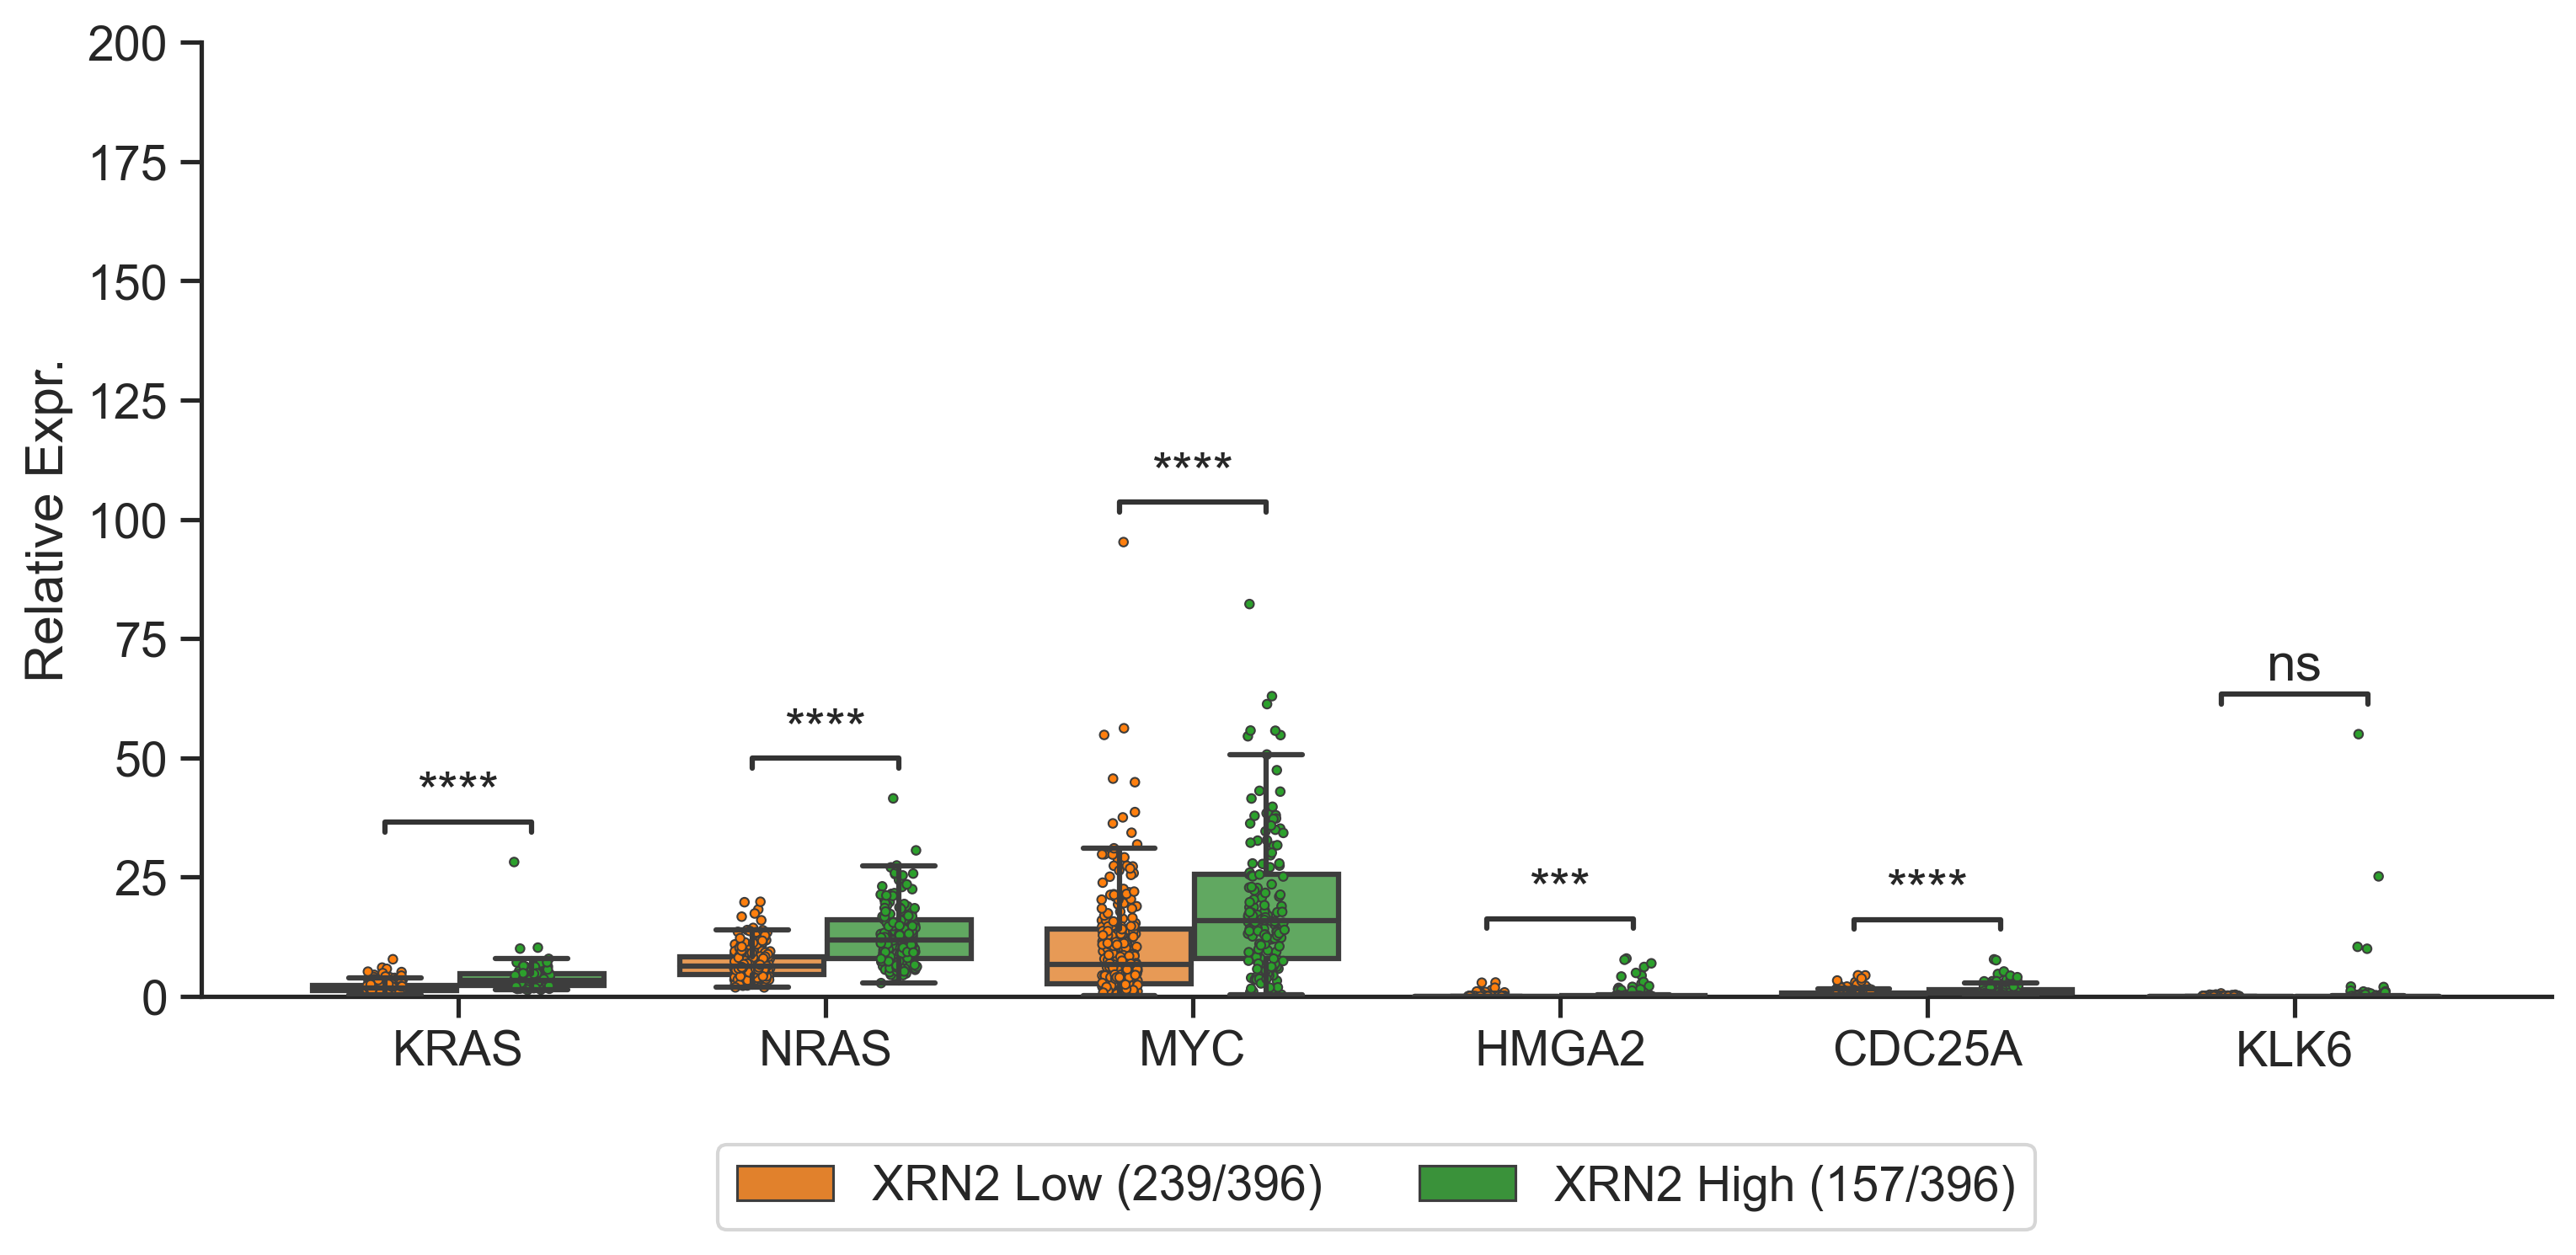

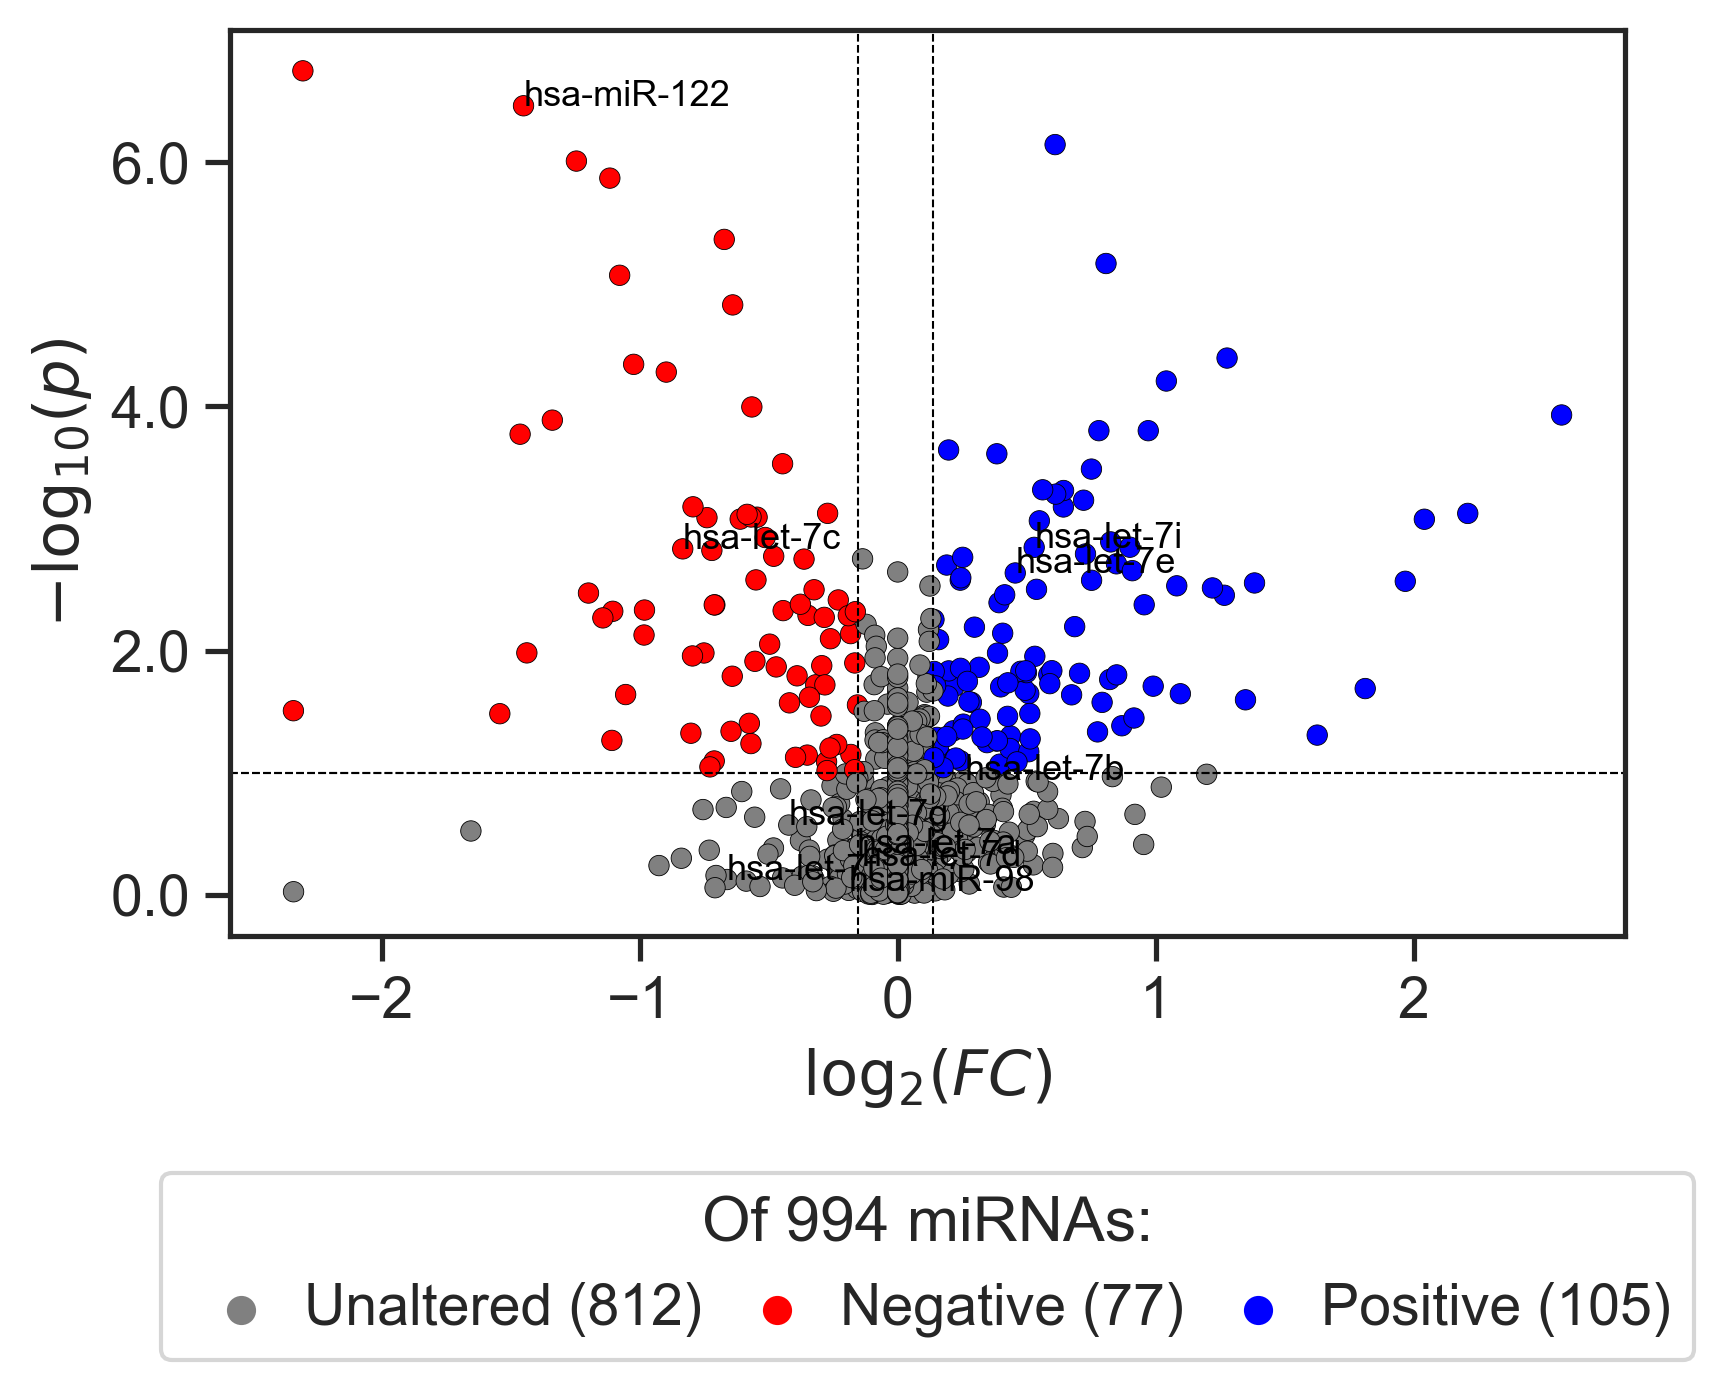

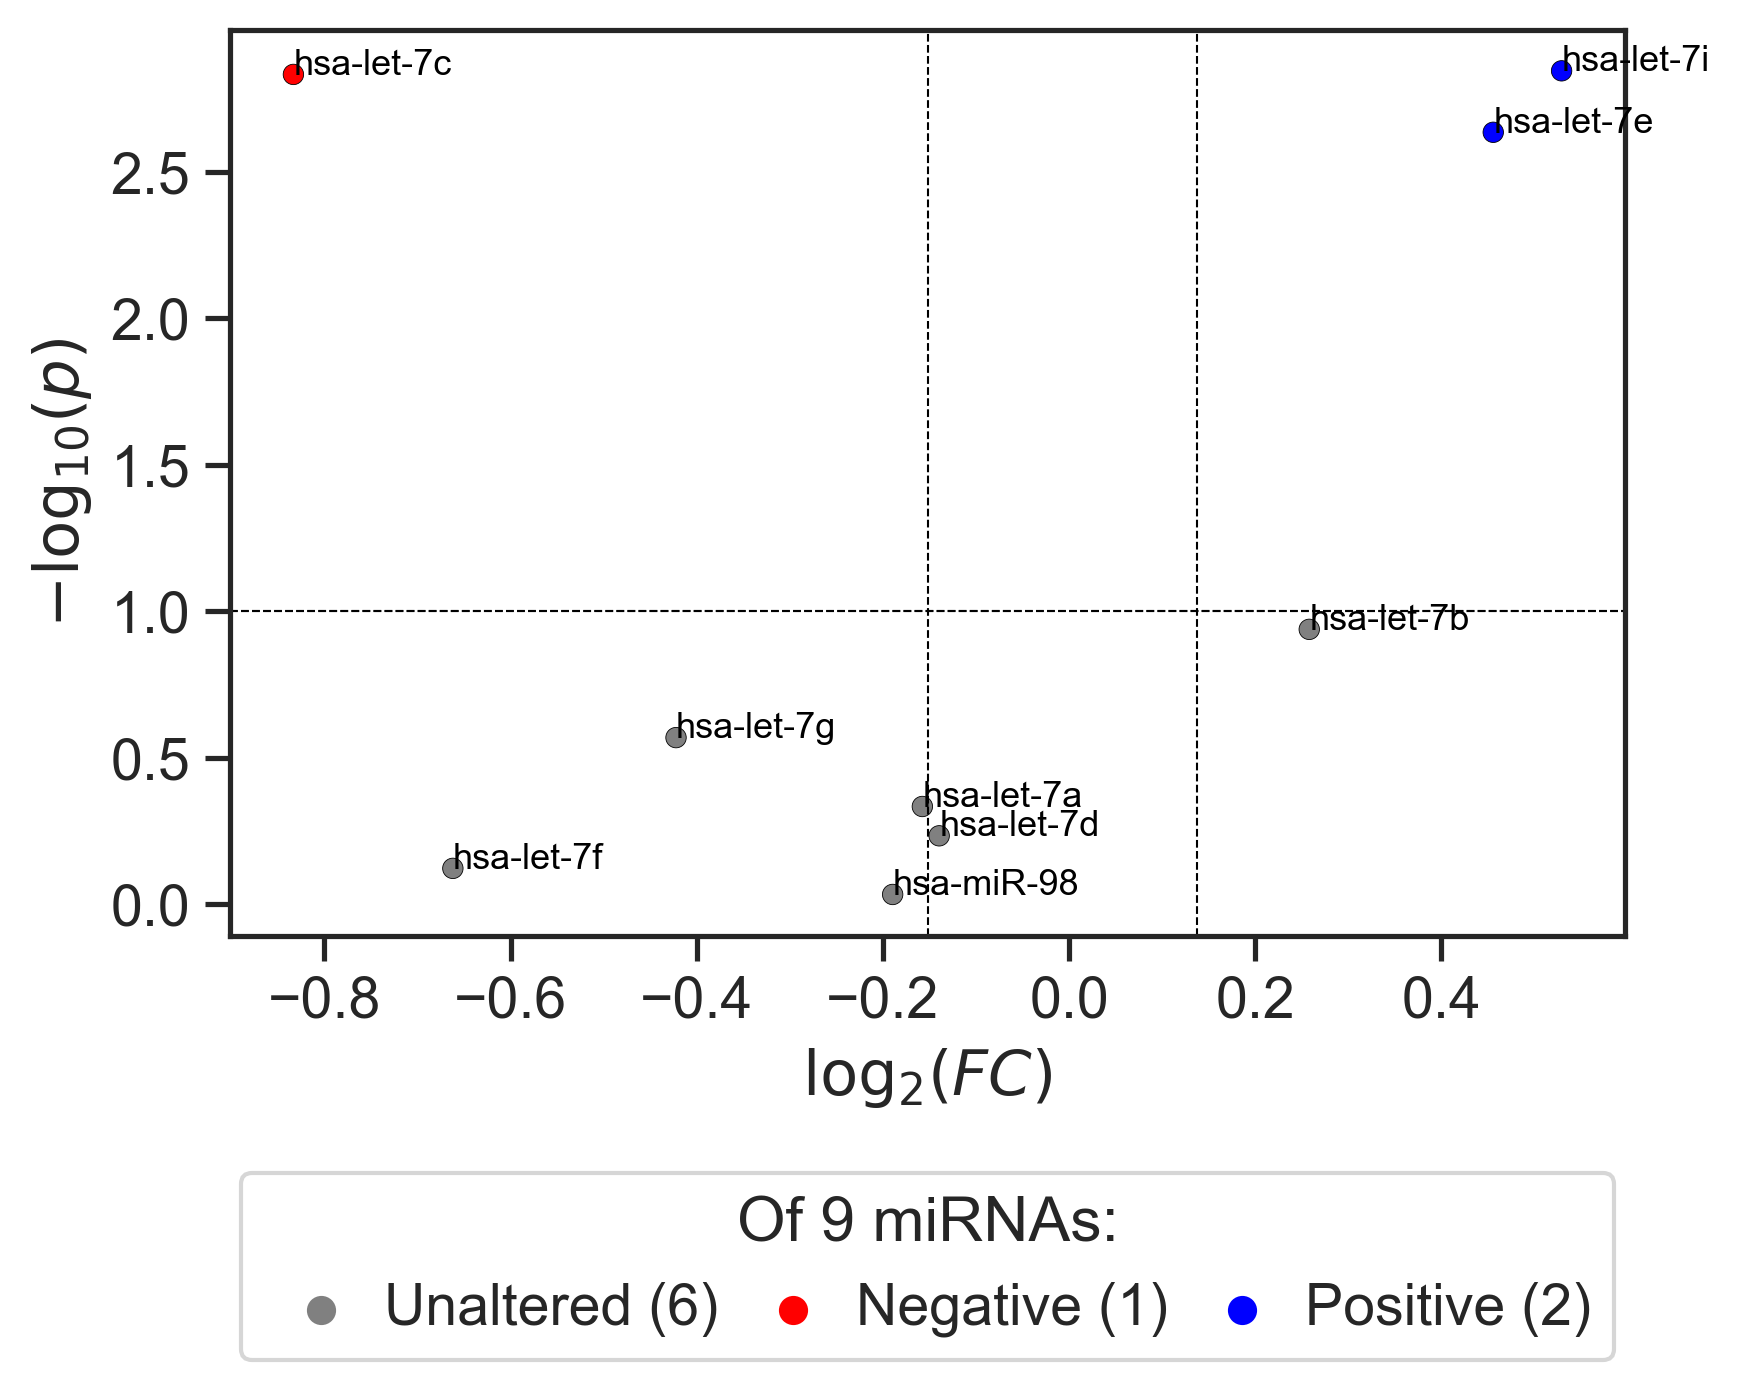

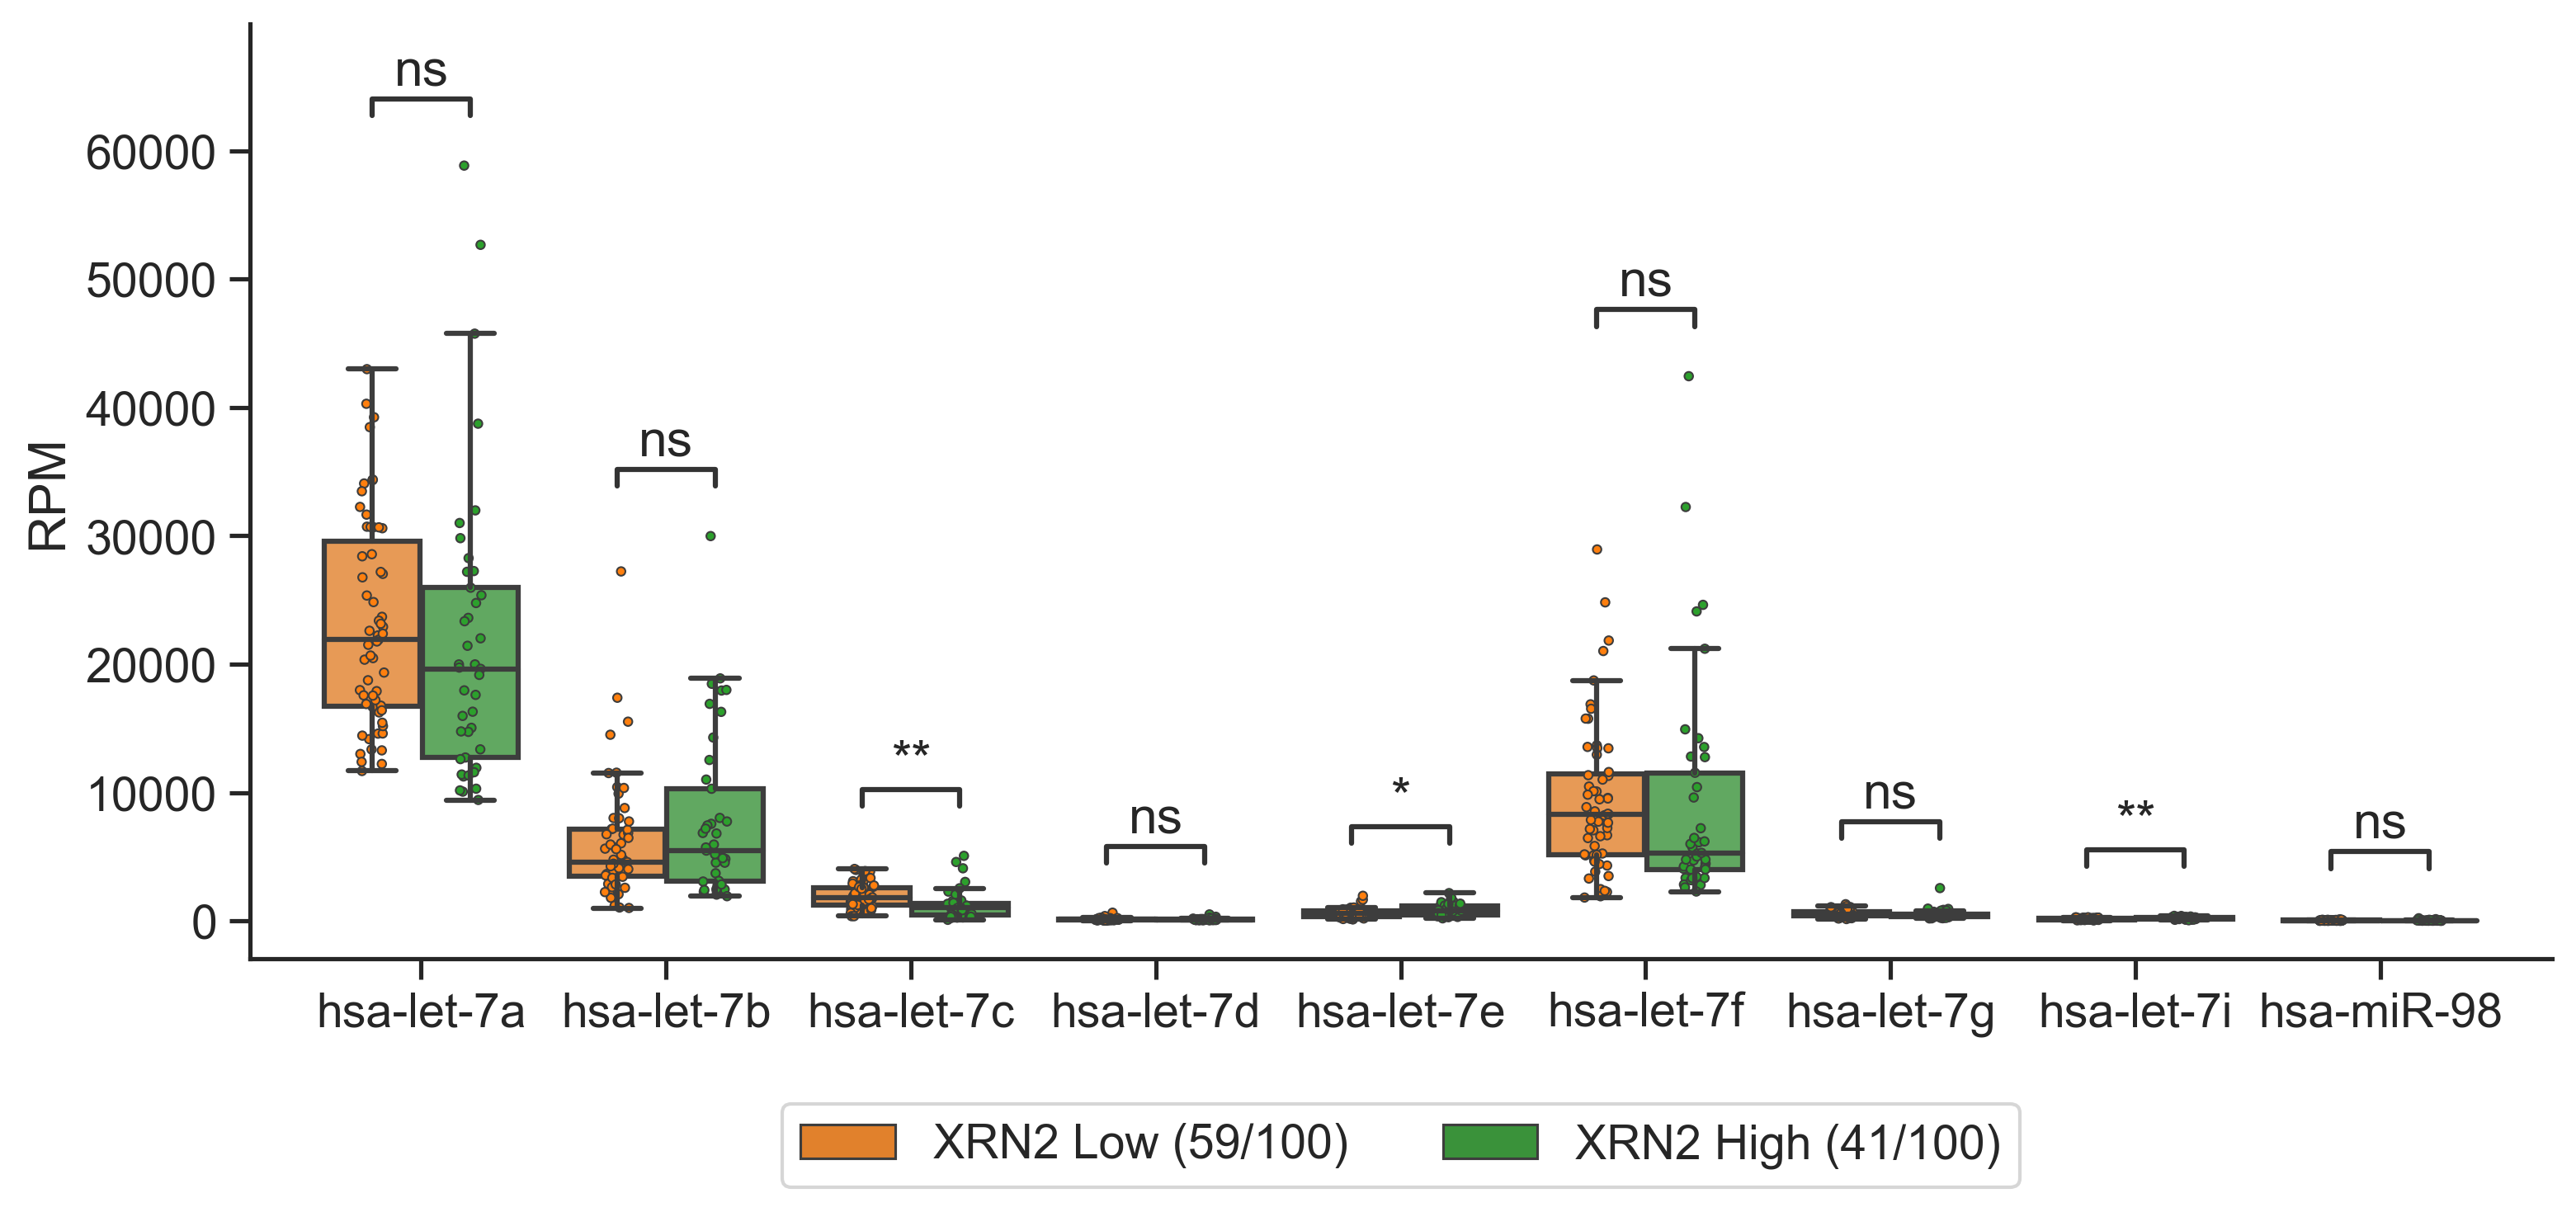

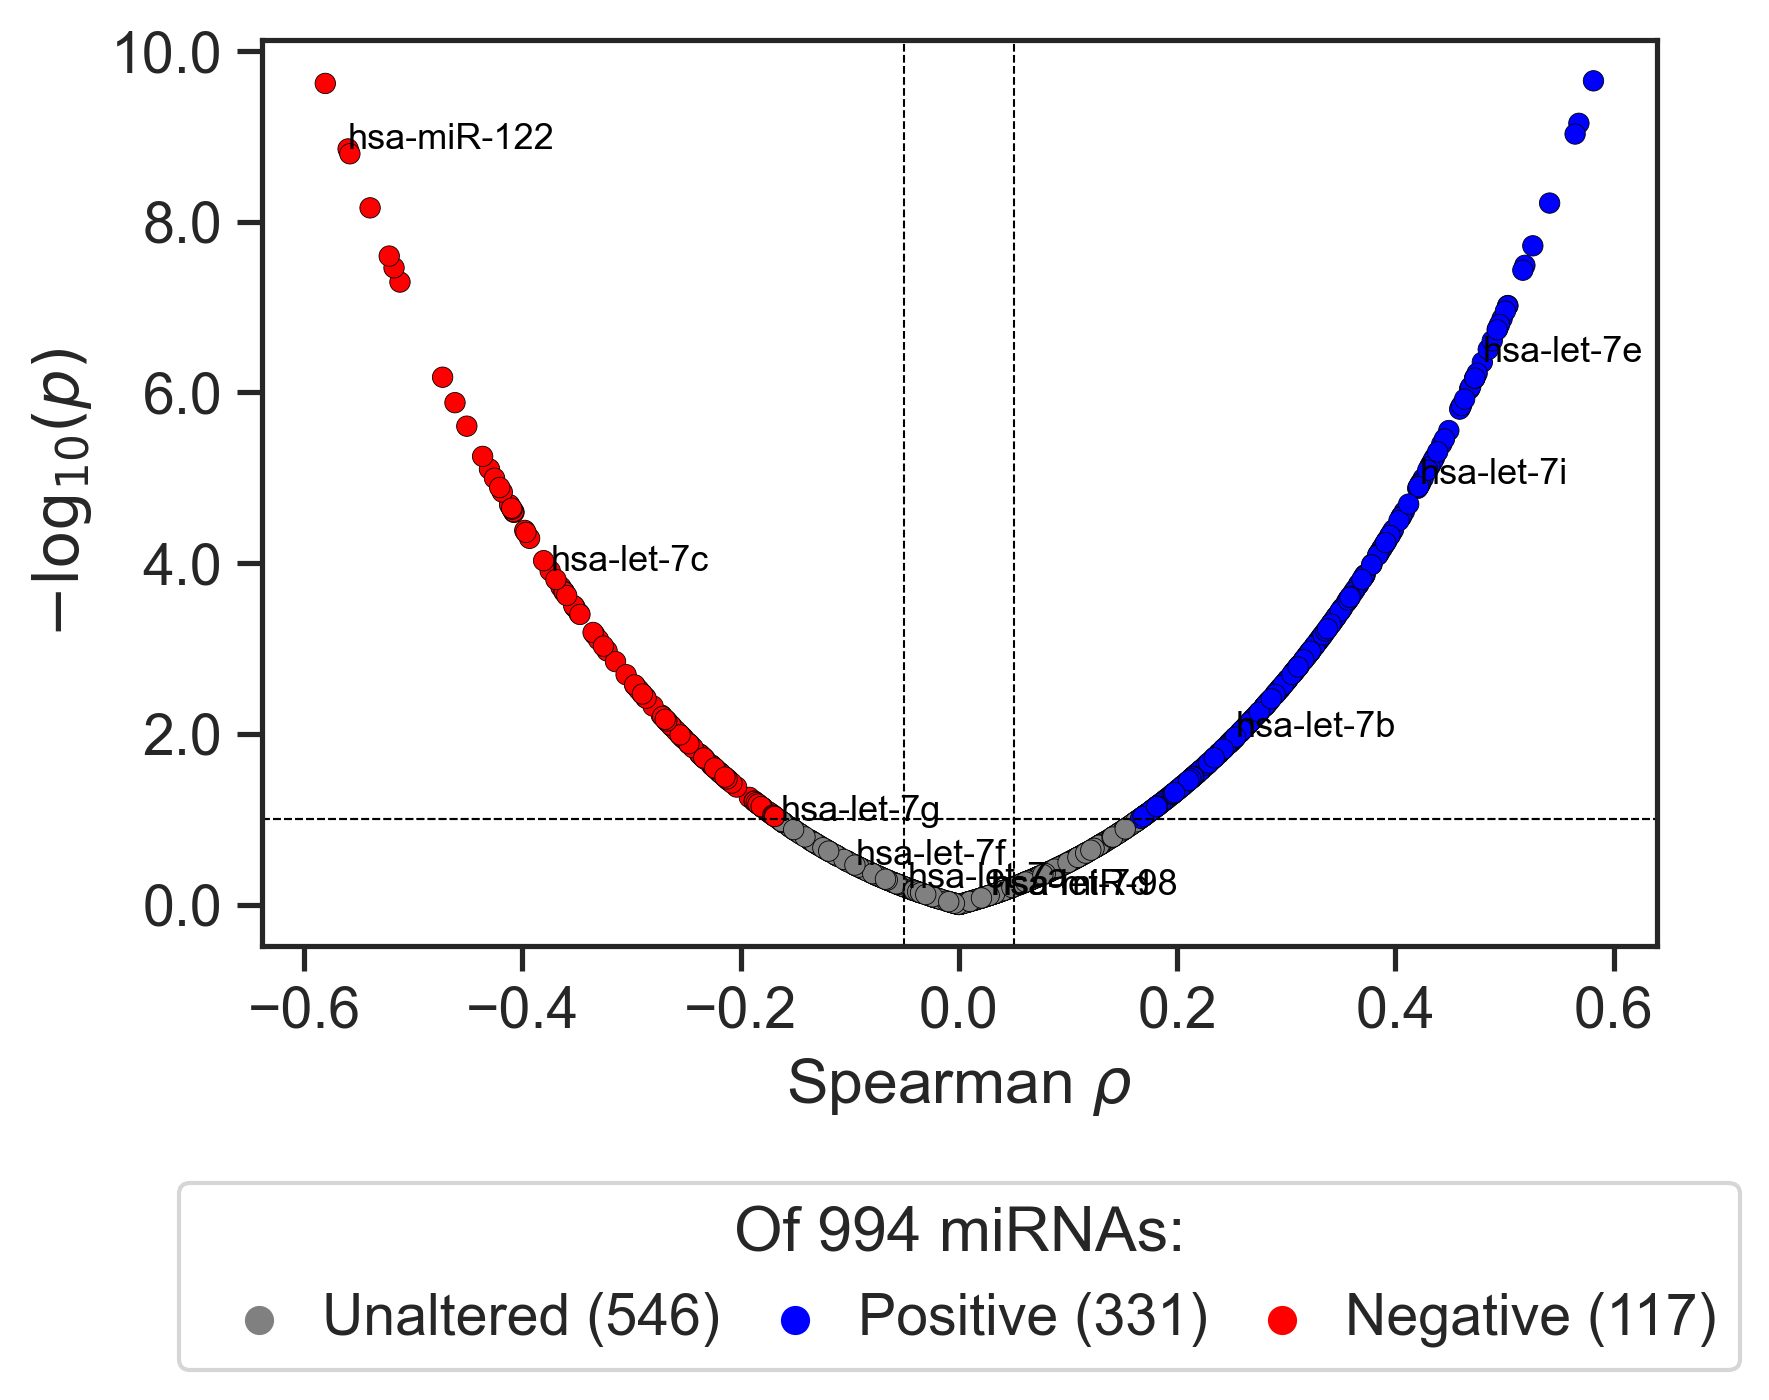

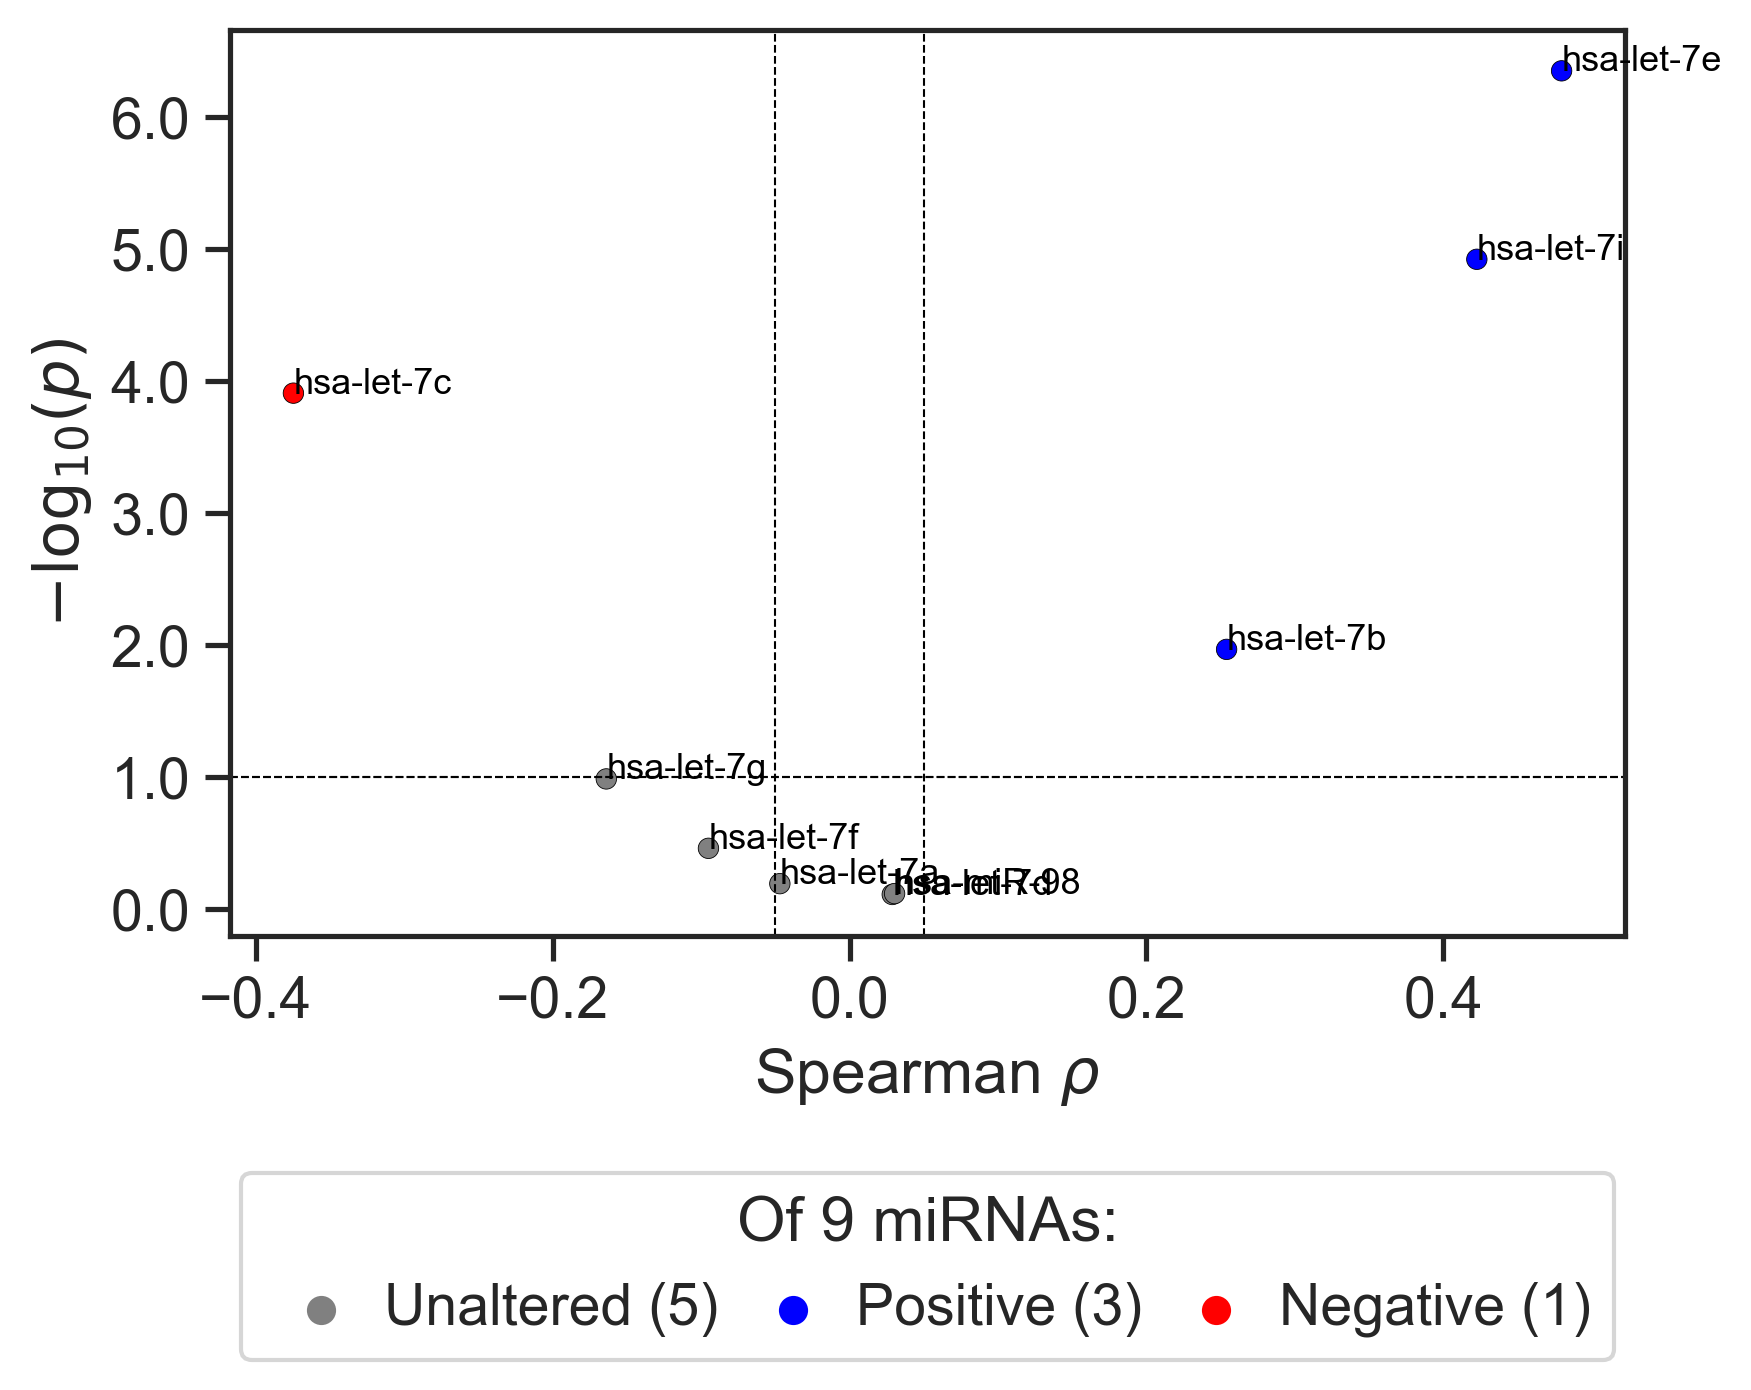

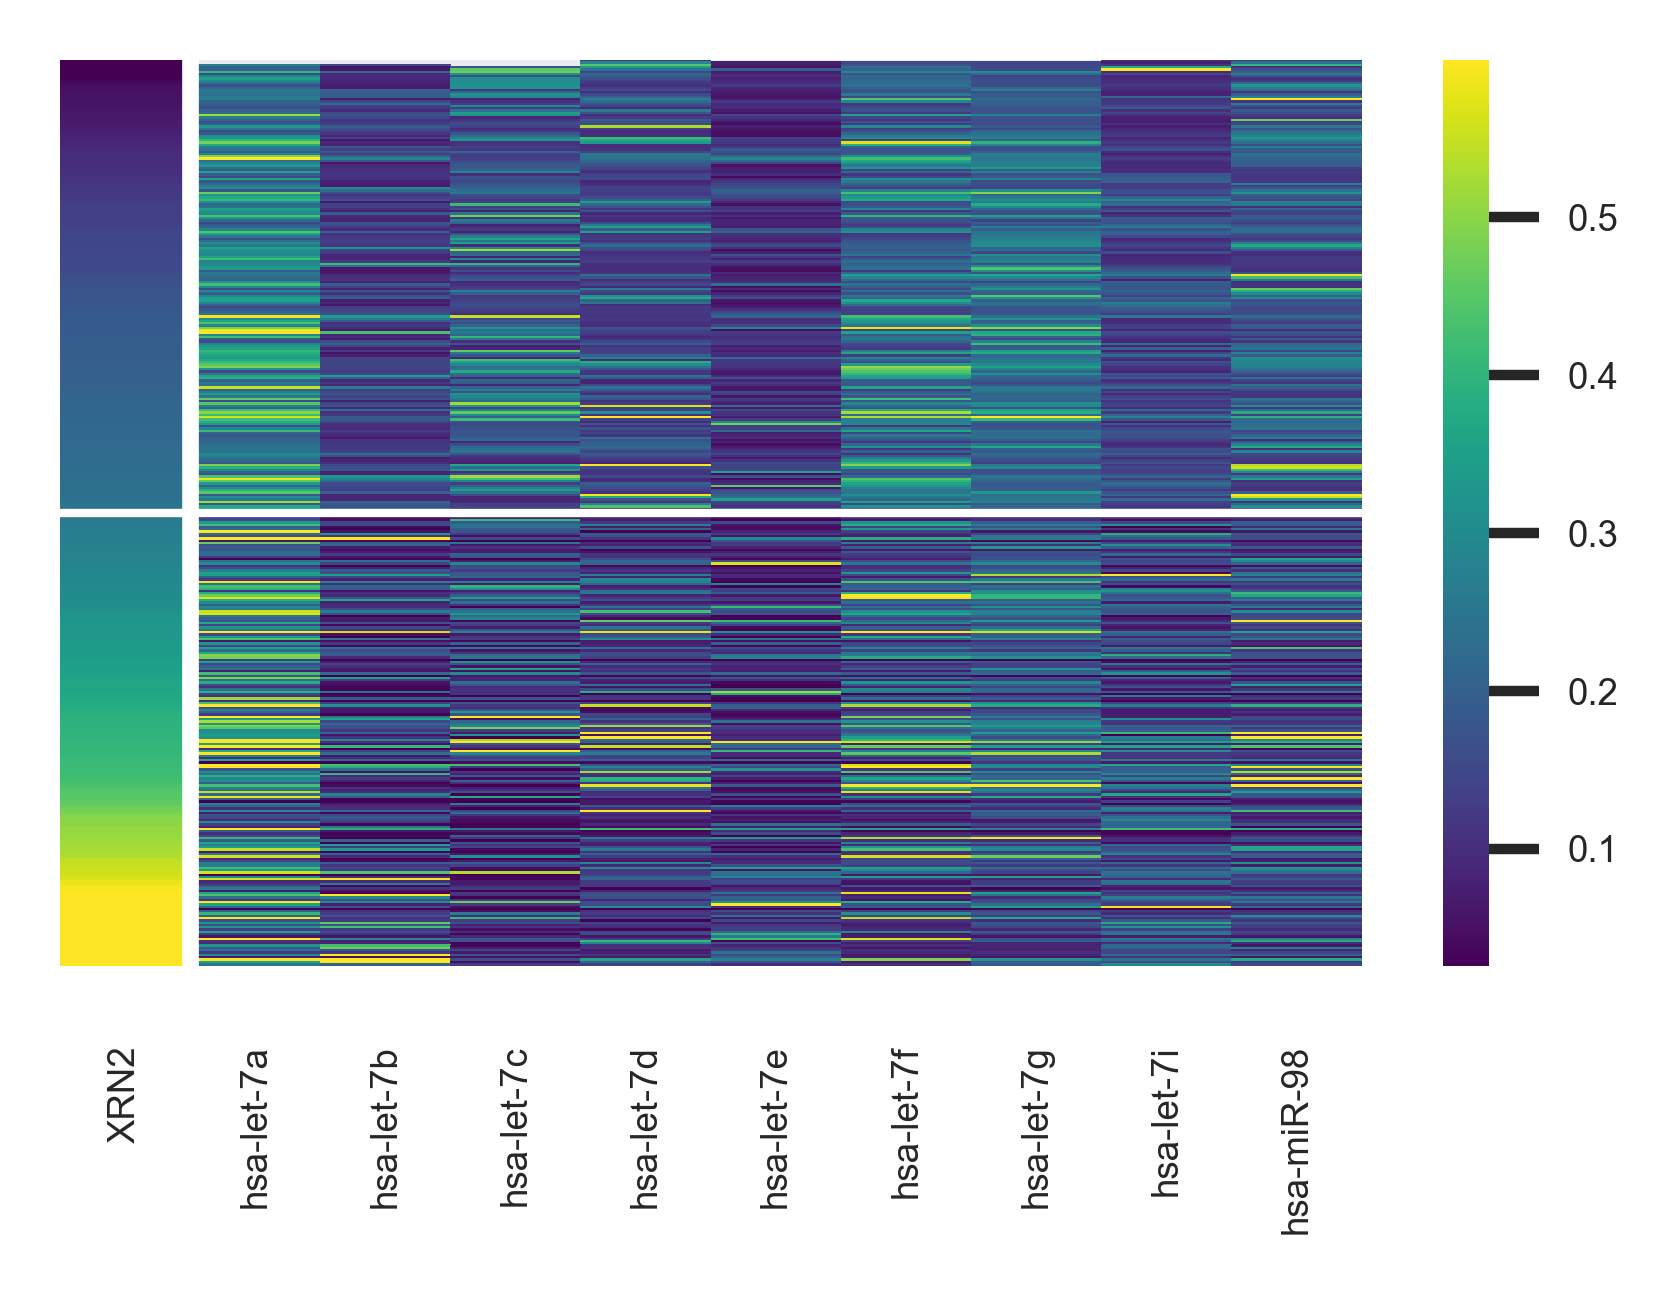

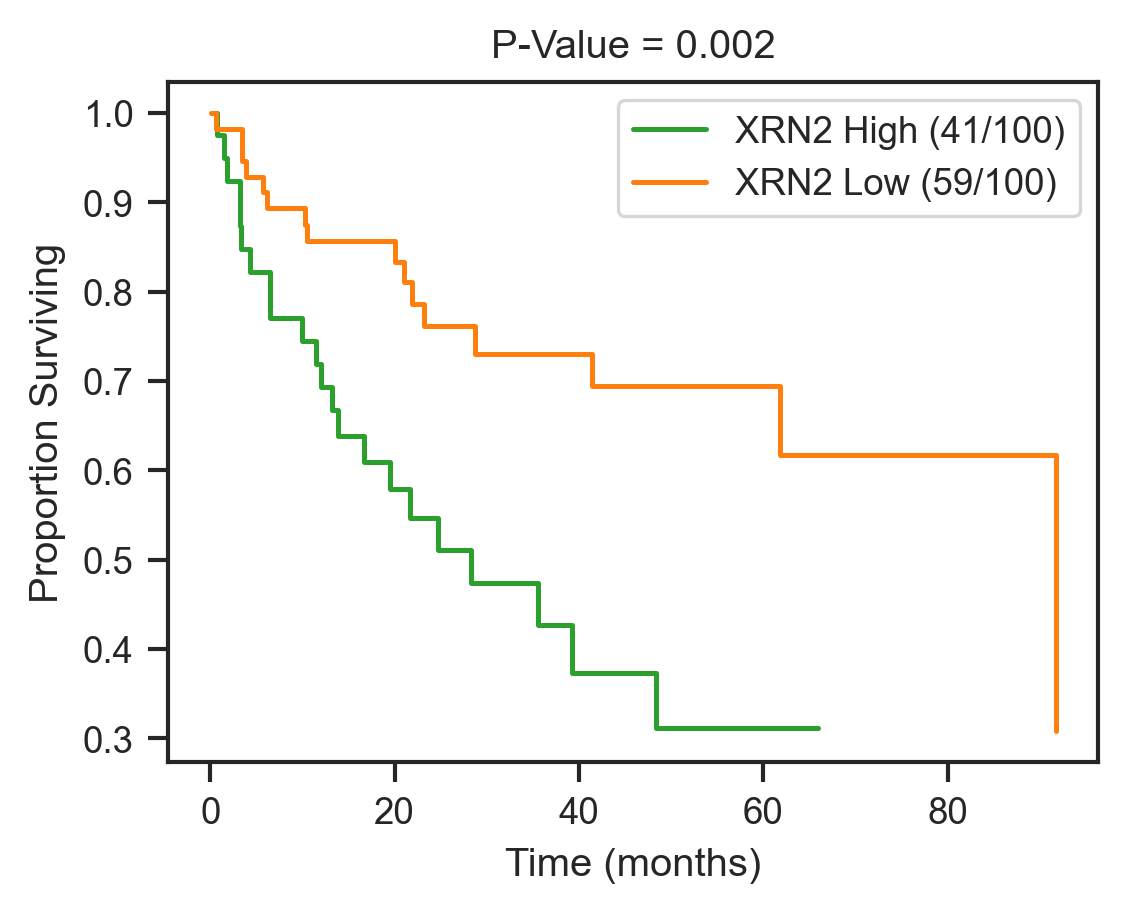

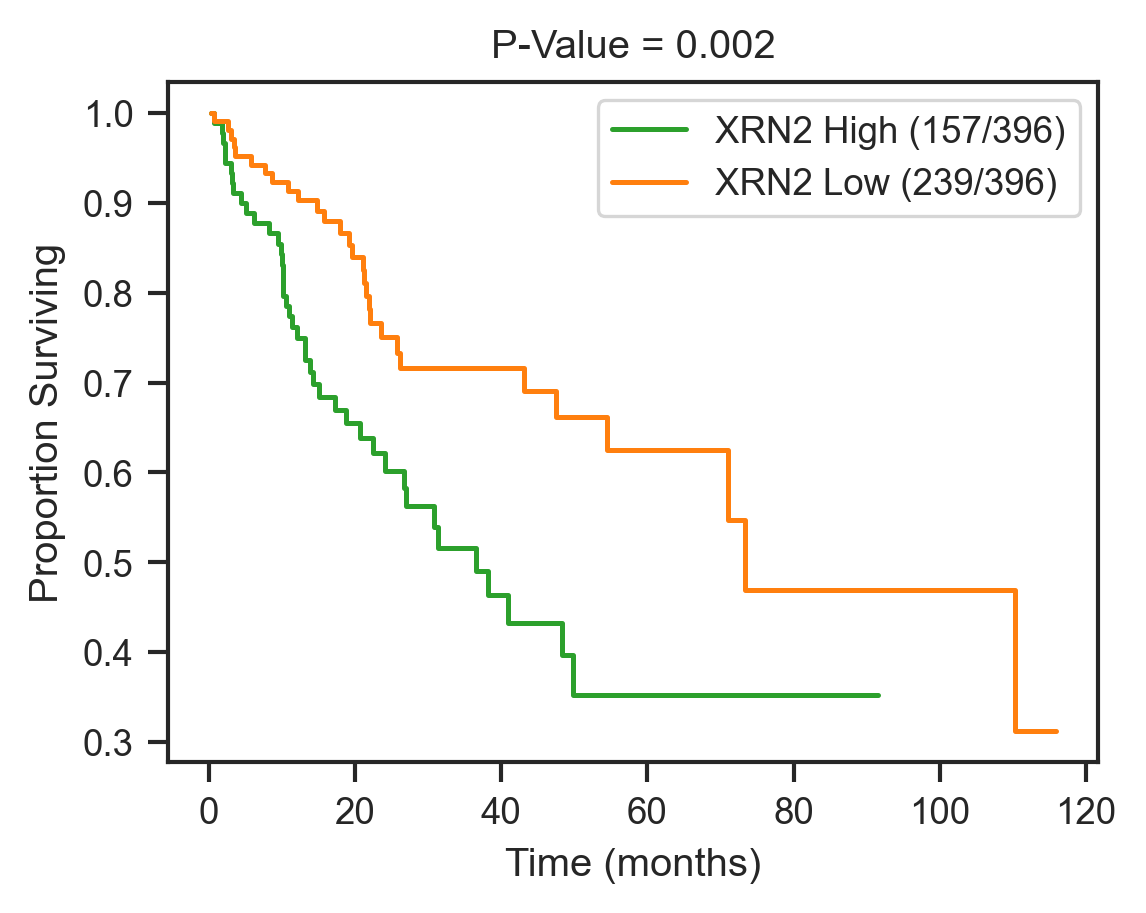

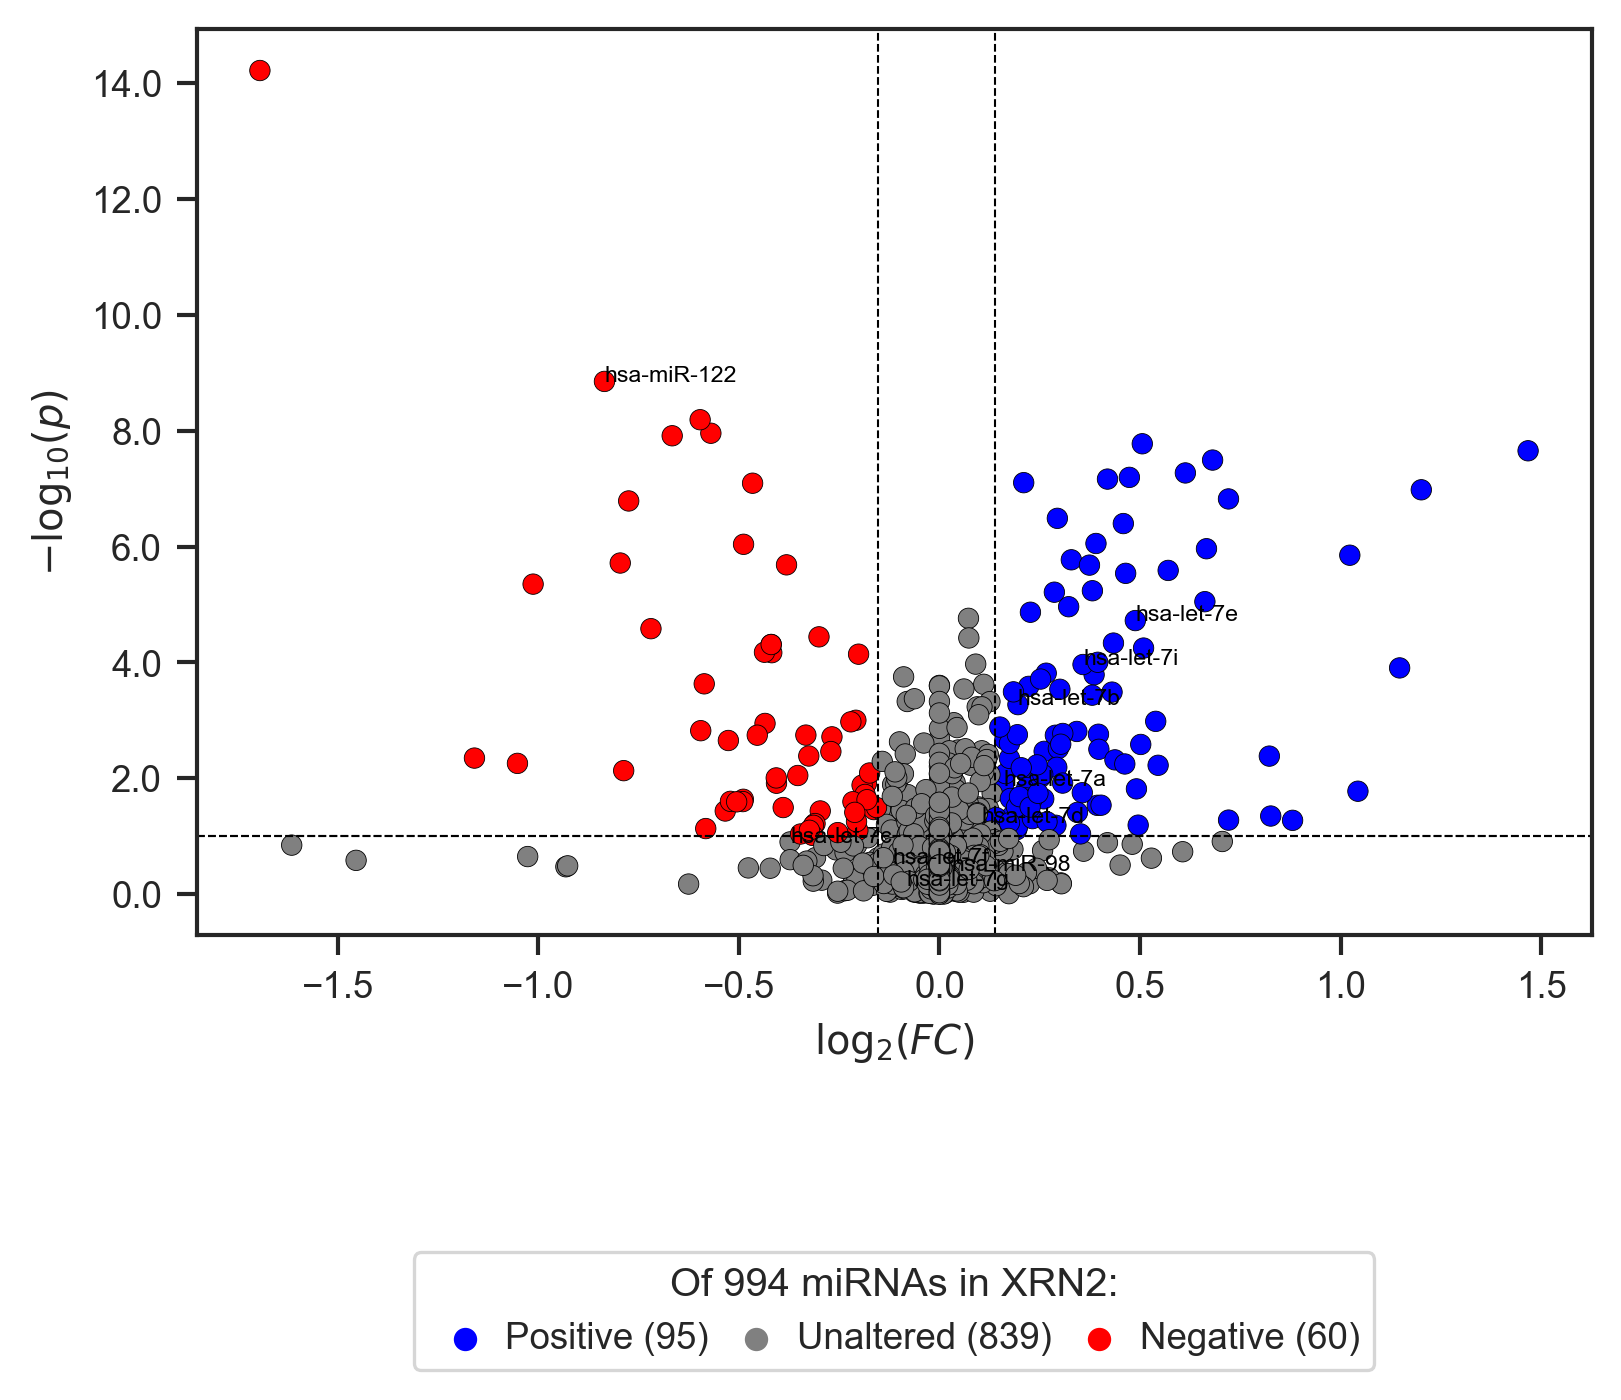

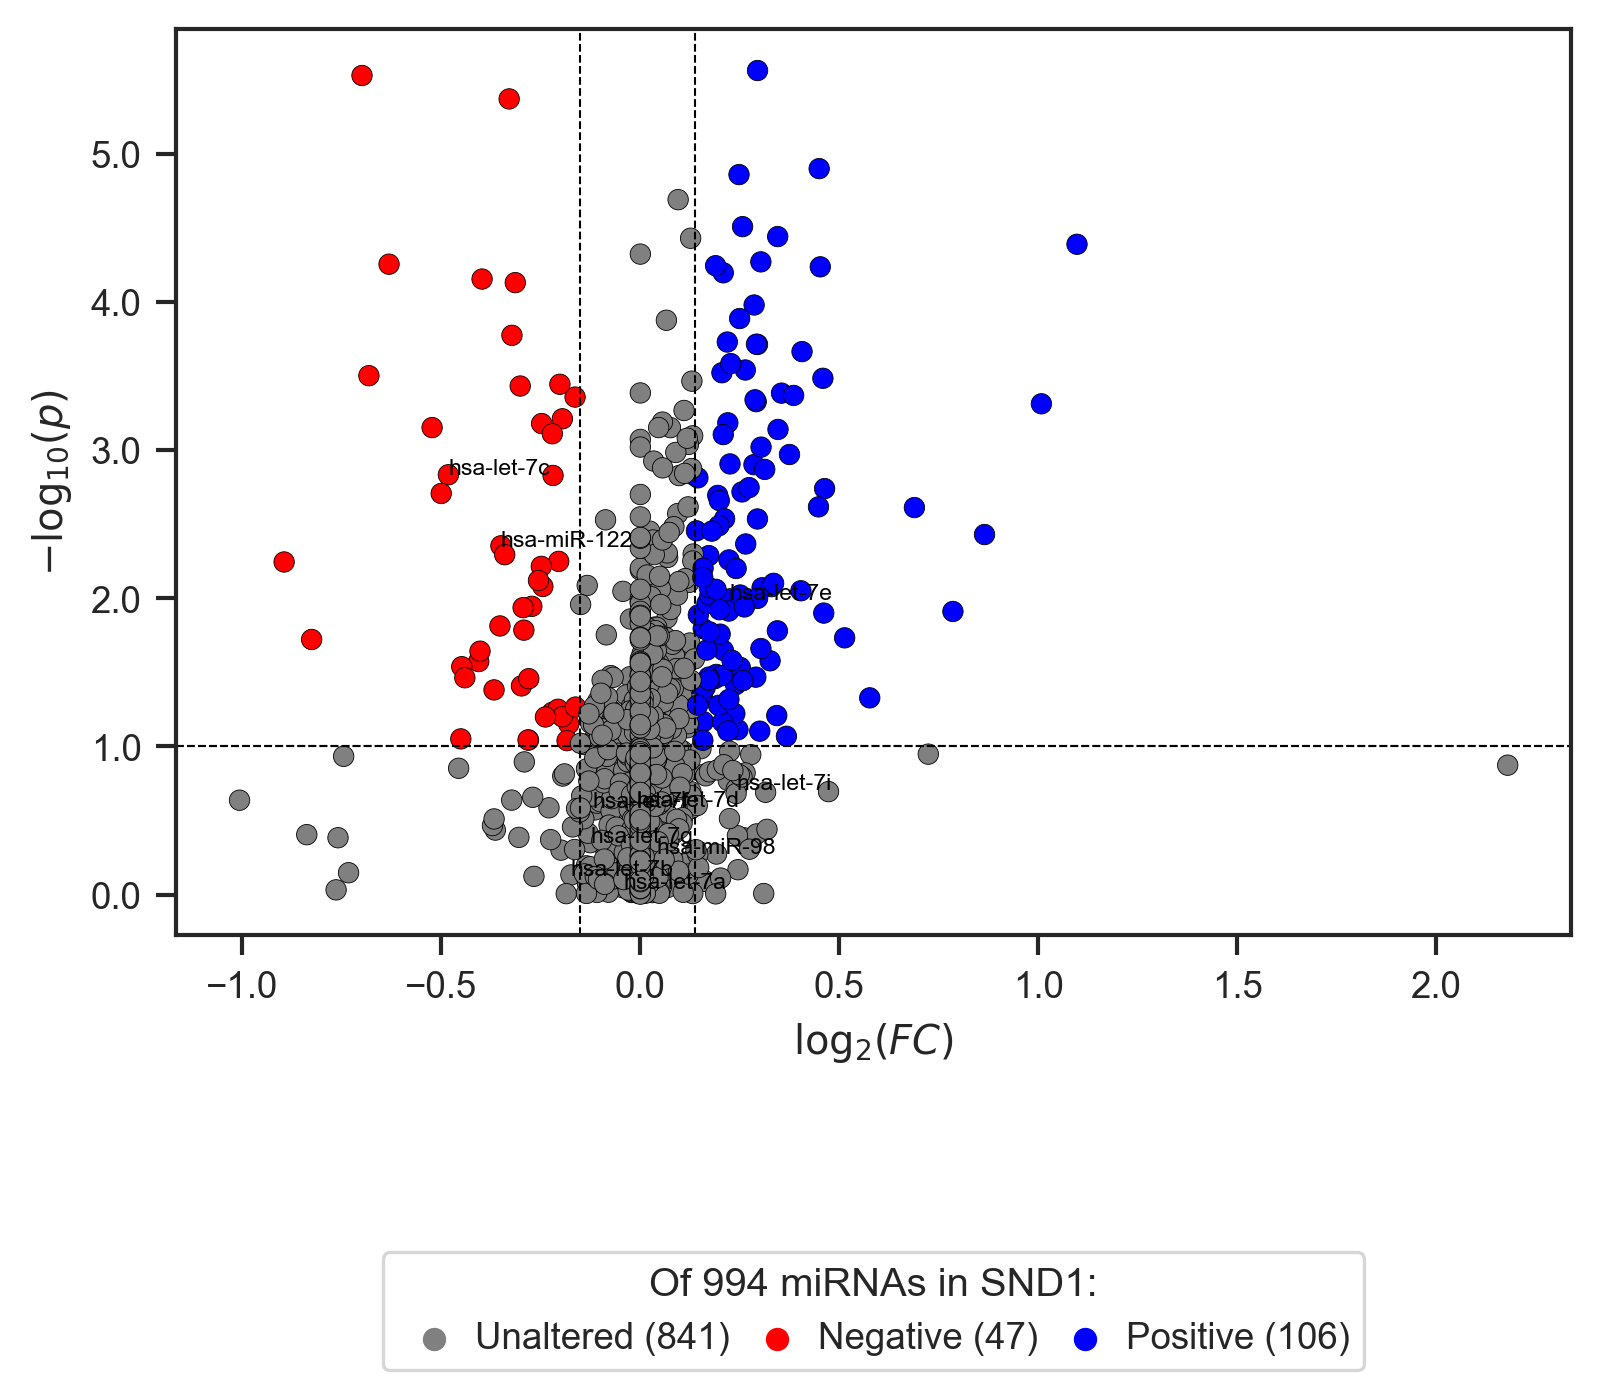

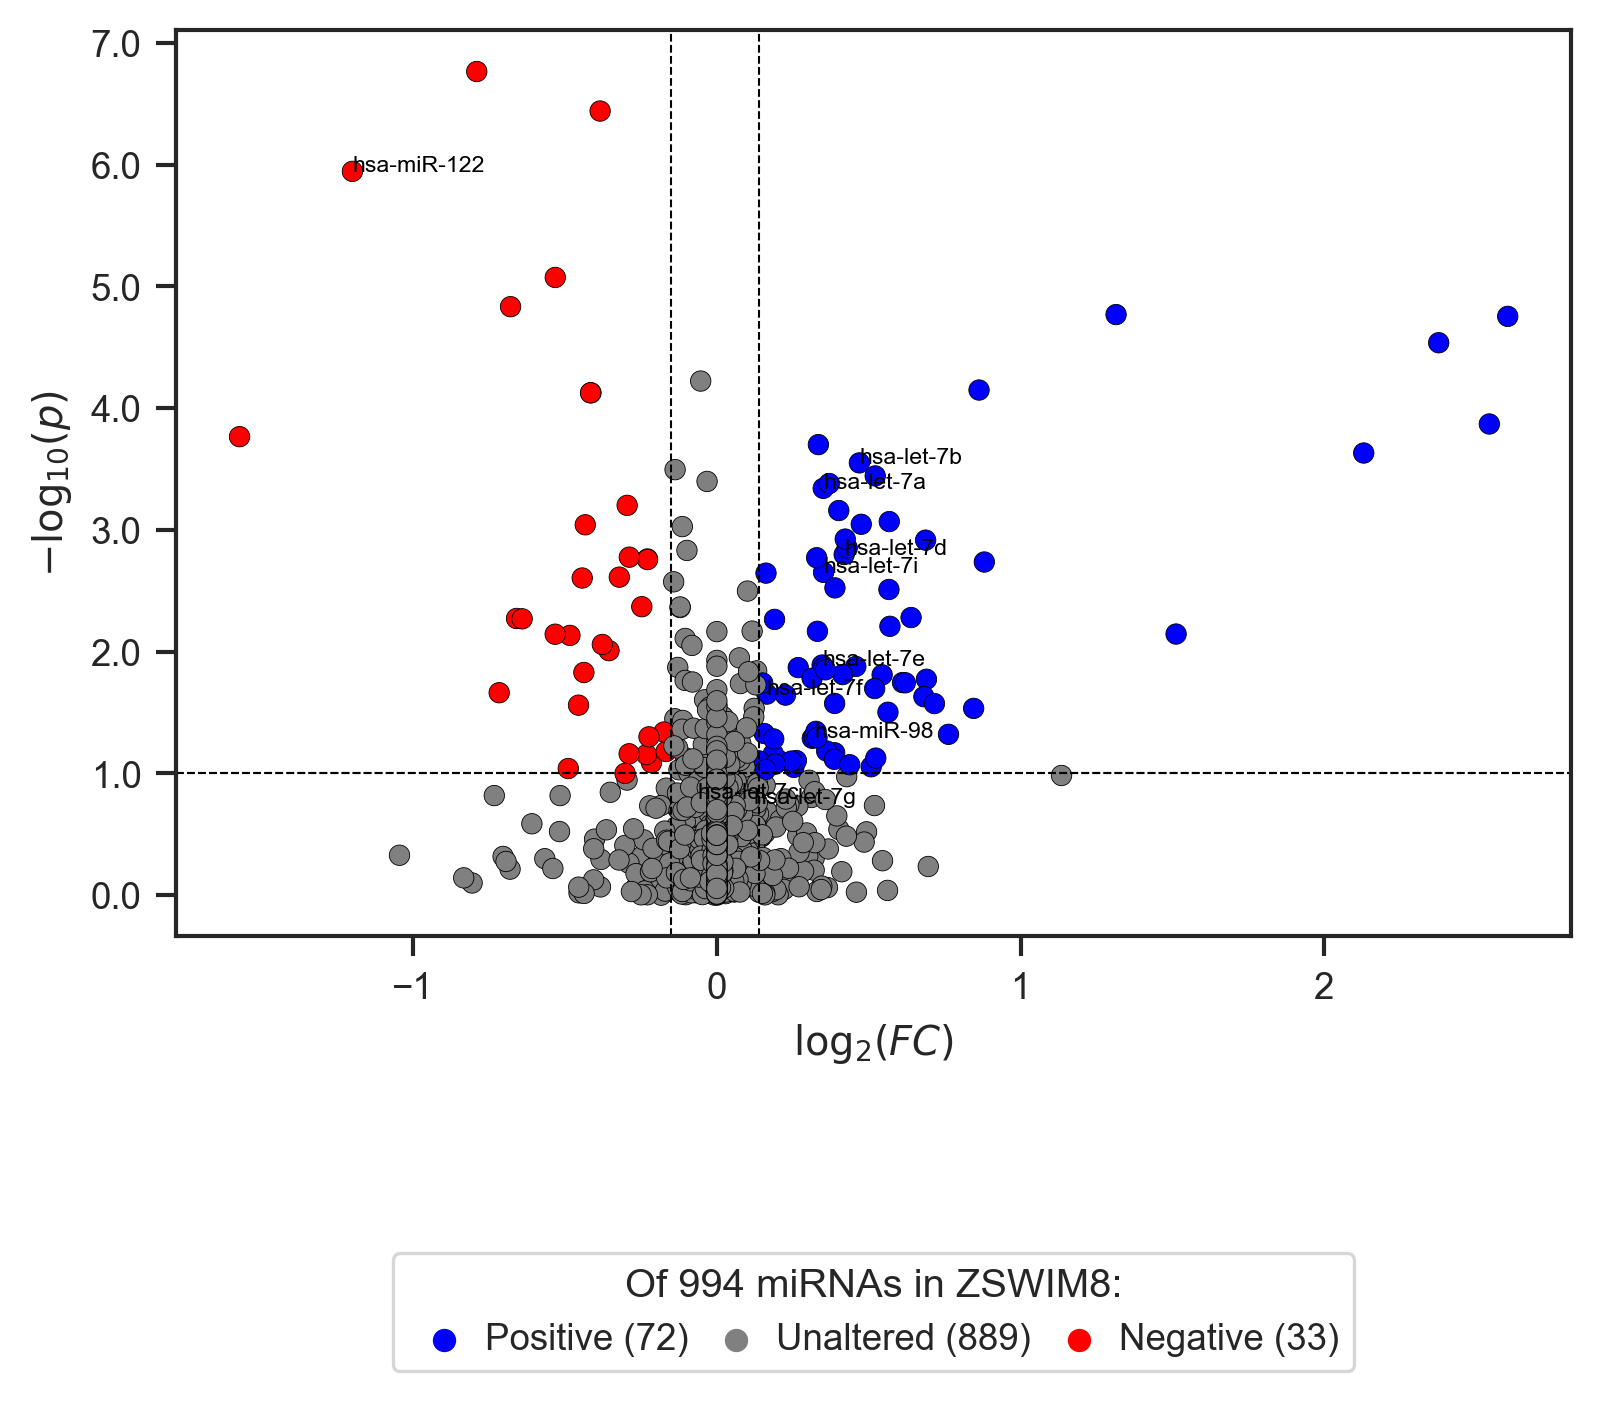

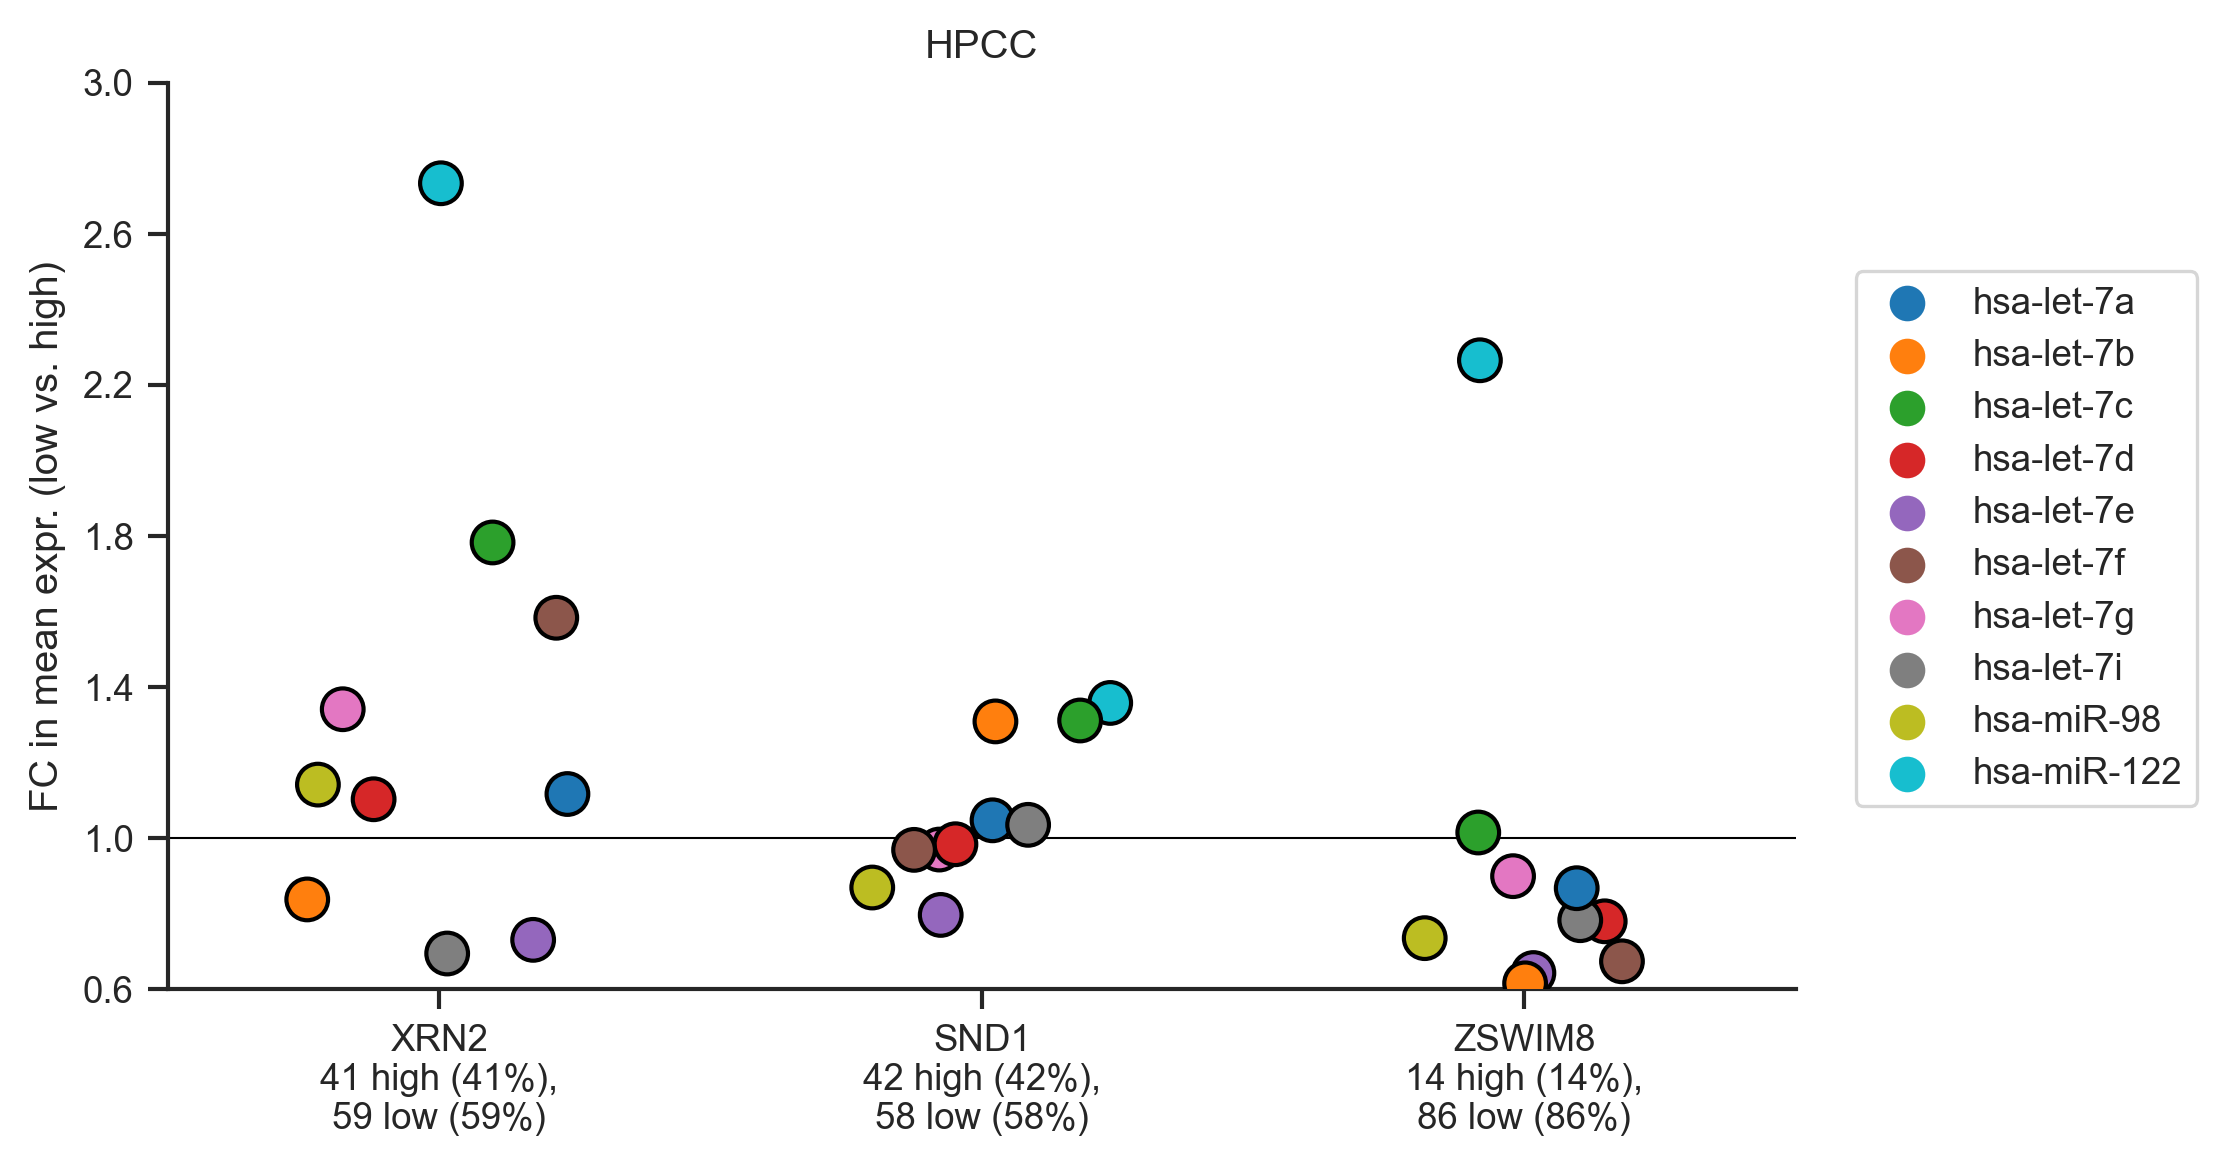

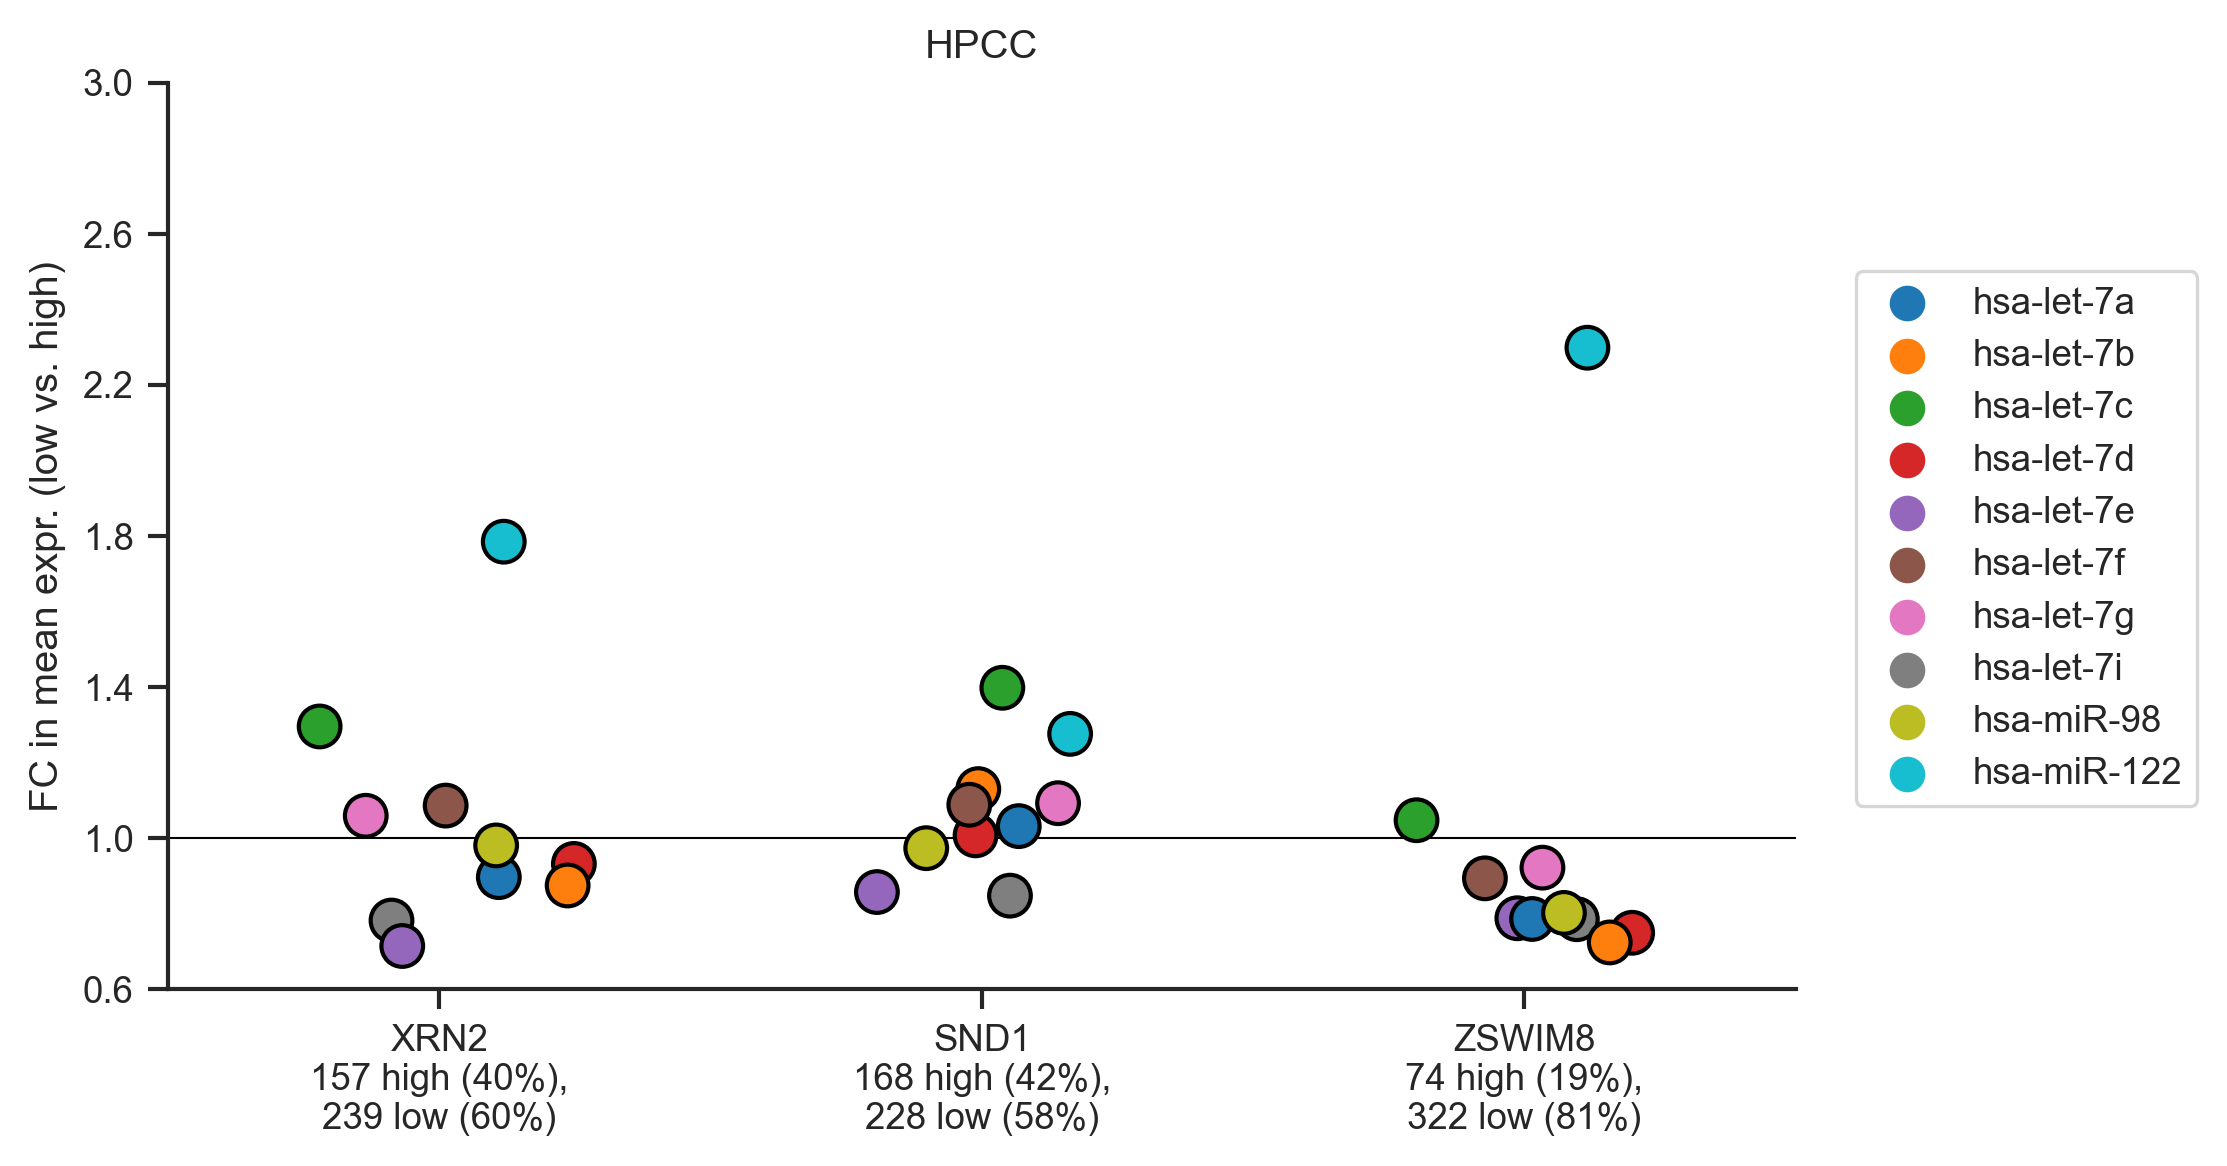

In [10]:
fc_data1 = analyze_tumor_data_simple(
    "hpcc",
    [],
    [],
    gse_file="", #'HPCC_DATA/go_enriched_x2_let7_hpcc.csv',
    optimize_miRNAs=["hsa-let-7c", "hsa-let-7g"],
    label_miRNAs=mirna_columns_of_interest + ["hsa-miR-122"],
    sample_cache_file='HPCC_DATA/hpcc_sample_subset.csv.gz'
)
view1 = fc_data1.loc[mirna_cols]
view1 = view1[
    (view1[f"Corr. with {basis_columns[0]}"] < 0)
    & (view1[f"FC {basis_columns[0]} High-Low"] < 1)
]
view1

Trimmed 5116 columns
Cached data file provided, utilizing that
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

NRAS_XRN2 Low v.s. NRAS_XRN2 High: t-test independent samples with Bonferroni correction, P_val=6.988e-37 stat=-1.396e+01
KRAS_XRN2 Low v.s. KRAS_XRN2 High: t-test independent samples with Bonferroni correction, P_val=1.369e-08 stat=-6.087e+00
MYC_XRN2 Low v.s. MYC_XRN2 High: t-test independent samples with Bonferroni correction, P_val=6.786e-04 stat=-3.891e+00
HMGA2_XRN2 Low v.s. HMGA2_XRN2 High: t-test independent samples with Bonferroni correction, P_val=2.857e-01 stat=-1.986e+00
CDC25A_XRN2 Low v.s. CDC25A_XRN2 High: t-test independent samples with Bonferroni correction, P_val=2.058e-18 stat=-9.328e+00
KLK6_XRN2 Low v.s. KLK6_XRN2 High: t-test independent samples with Bonferroni correction, P_val=1.318e-06 stat=5.254e+00
p-value annotation legend:
ns: 5.00e-0

FC XRN2 High [173/505 (34.26%)]  \
Target                                             
hsa-let-7e                              0.954569   
hsa-miR-22                              0.955113   
hsa-miR-24-1*                           0.943963   
hsa-miR-26a                             0.975513   
hsa-miR-26b                             0.898396   
...                                          ...   
hsa-miR-487b-5p                         0.944264   
hsa-miR-551a                            0.995877   
hsa-miR-211                             0.962708   
hsa-miR-6750-3p                         0.969807   
hsa-miR-1197                            0.964122   

                 FC XRN2 Low [332/505 (65.74%)]  FC XRN2 High-Low  \
Target                                                              
hsa-let-7e                             1.025043          0.931247   
hsa-miR-22                             1.005800          0.949606   
hsa-miR-24-1*                          1.038894          0.908623   
hsa-miR-26a                            1.008819          0.966985   
hsa-miR-26b                            1.077143          0.834055   
...                                         ...               ...   
hsa-miR-487b-5p                        1.019401          0.926293   
hsa-miR-551a                           1.001211          0.994673   
hsa-miR-211                            1.029001          0.935576   
hsa-miR-6750-3p                        1.008554          0.961582   
hsa-miR-1197                           1.009230          0.955305   

                 FC XRN2 High-Low p-value  Corr. with XRN2  \
Target                                                       
hsa-let-7e                       0.410447        -0.112608   
hsa-miR-22                       0.882553        -0.132073   
hsa-miR-24-1*                    0.094999        -0.214492   
hsa-miR-26a                      0.747142        -0.108057   
hsa-miR-26b                      0.084053        -0.228636   
...                                   ...              ...   
hsa-miR-487b-5p                  0.000004        -0.246910   
hsa-miR-551a                     0.102797        -0.002391   
hsa-miR-211                      0.000194        -0.198177   
hsa-miR-6750-3p                  0.002526        -0.122717   
hsa-miR-1197                     0.000142        -0.203164   

                 Corr. with XRN2 p-value          Mean     Std. Dev.  \
Target                                                                 
hsa-let-7e                  1.133042e-02   1112.349914    895.481681   
hsa-miR-22                  2.942731e-03  25856.800447  18788.175011   
hsa-miR-24-1*               1.145135e-06      7.565040      7.625028   
hsa-miR-26a                 1.512445e-02   1140.979756    956.682688   
hsa-miR-26b                 2.056314e-07    313.897924    221.276730   
...                                  ...           ...           ...   
hsa-miR-487b-5p             1.886030e-08      2.308996      2.546726   
hsa-miR-551a                9.572630e-01      2.165103      2.273122   
hsa-miR-211                 7.222546e-06      3.566244      5.841336   
hsa-miR-6750-3p             5.756662e-03      2.117284      2.182614   
hsa-miR-1197                4.178445e-06      2.195363      2.325565   

                       Median  Inter-Quartile Range          Mode  \
Target                                                              
hsa-let-7e         875.327407            863.078560    328.209000   
hsa-miR-22       20324.843269          19044.551441  14521.062500   
hsa-miR-24-1*        5.886655              6.253618      3.633000   
hsa-miR-26a        935.942126            749.101315    660.271500   
hsa-miR-26b        261.906079            181.560619    223.545000   
...                       ...                   ...           ...   
hsa-miR-487b-5p      2.118052              2.348114      3.137220   
hsa-miR-551a         2.088953              2.211216      2.773450   
hsa-miR-

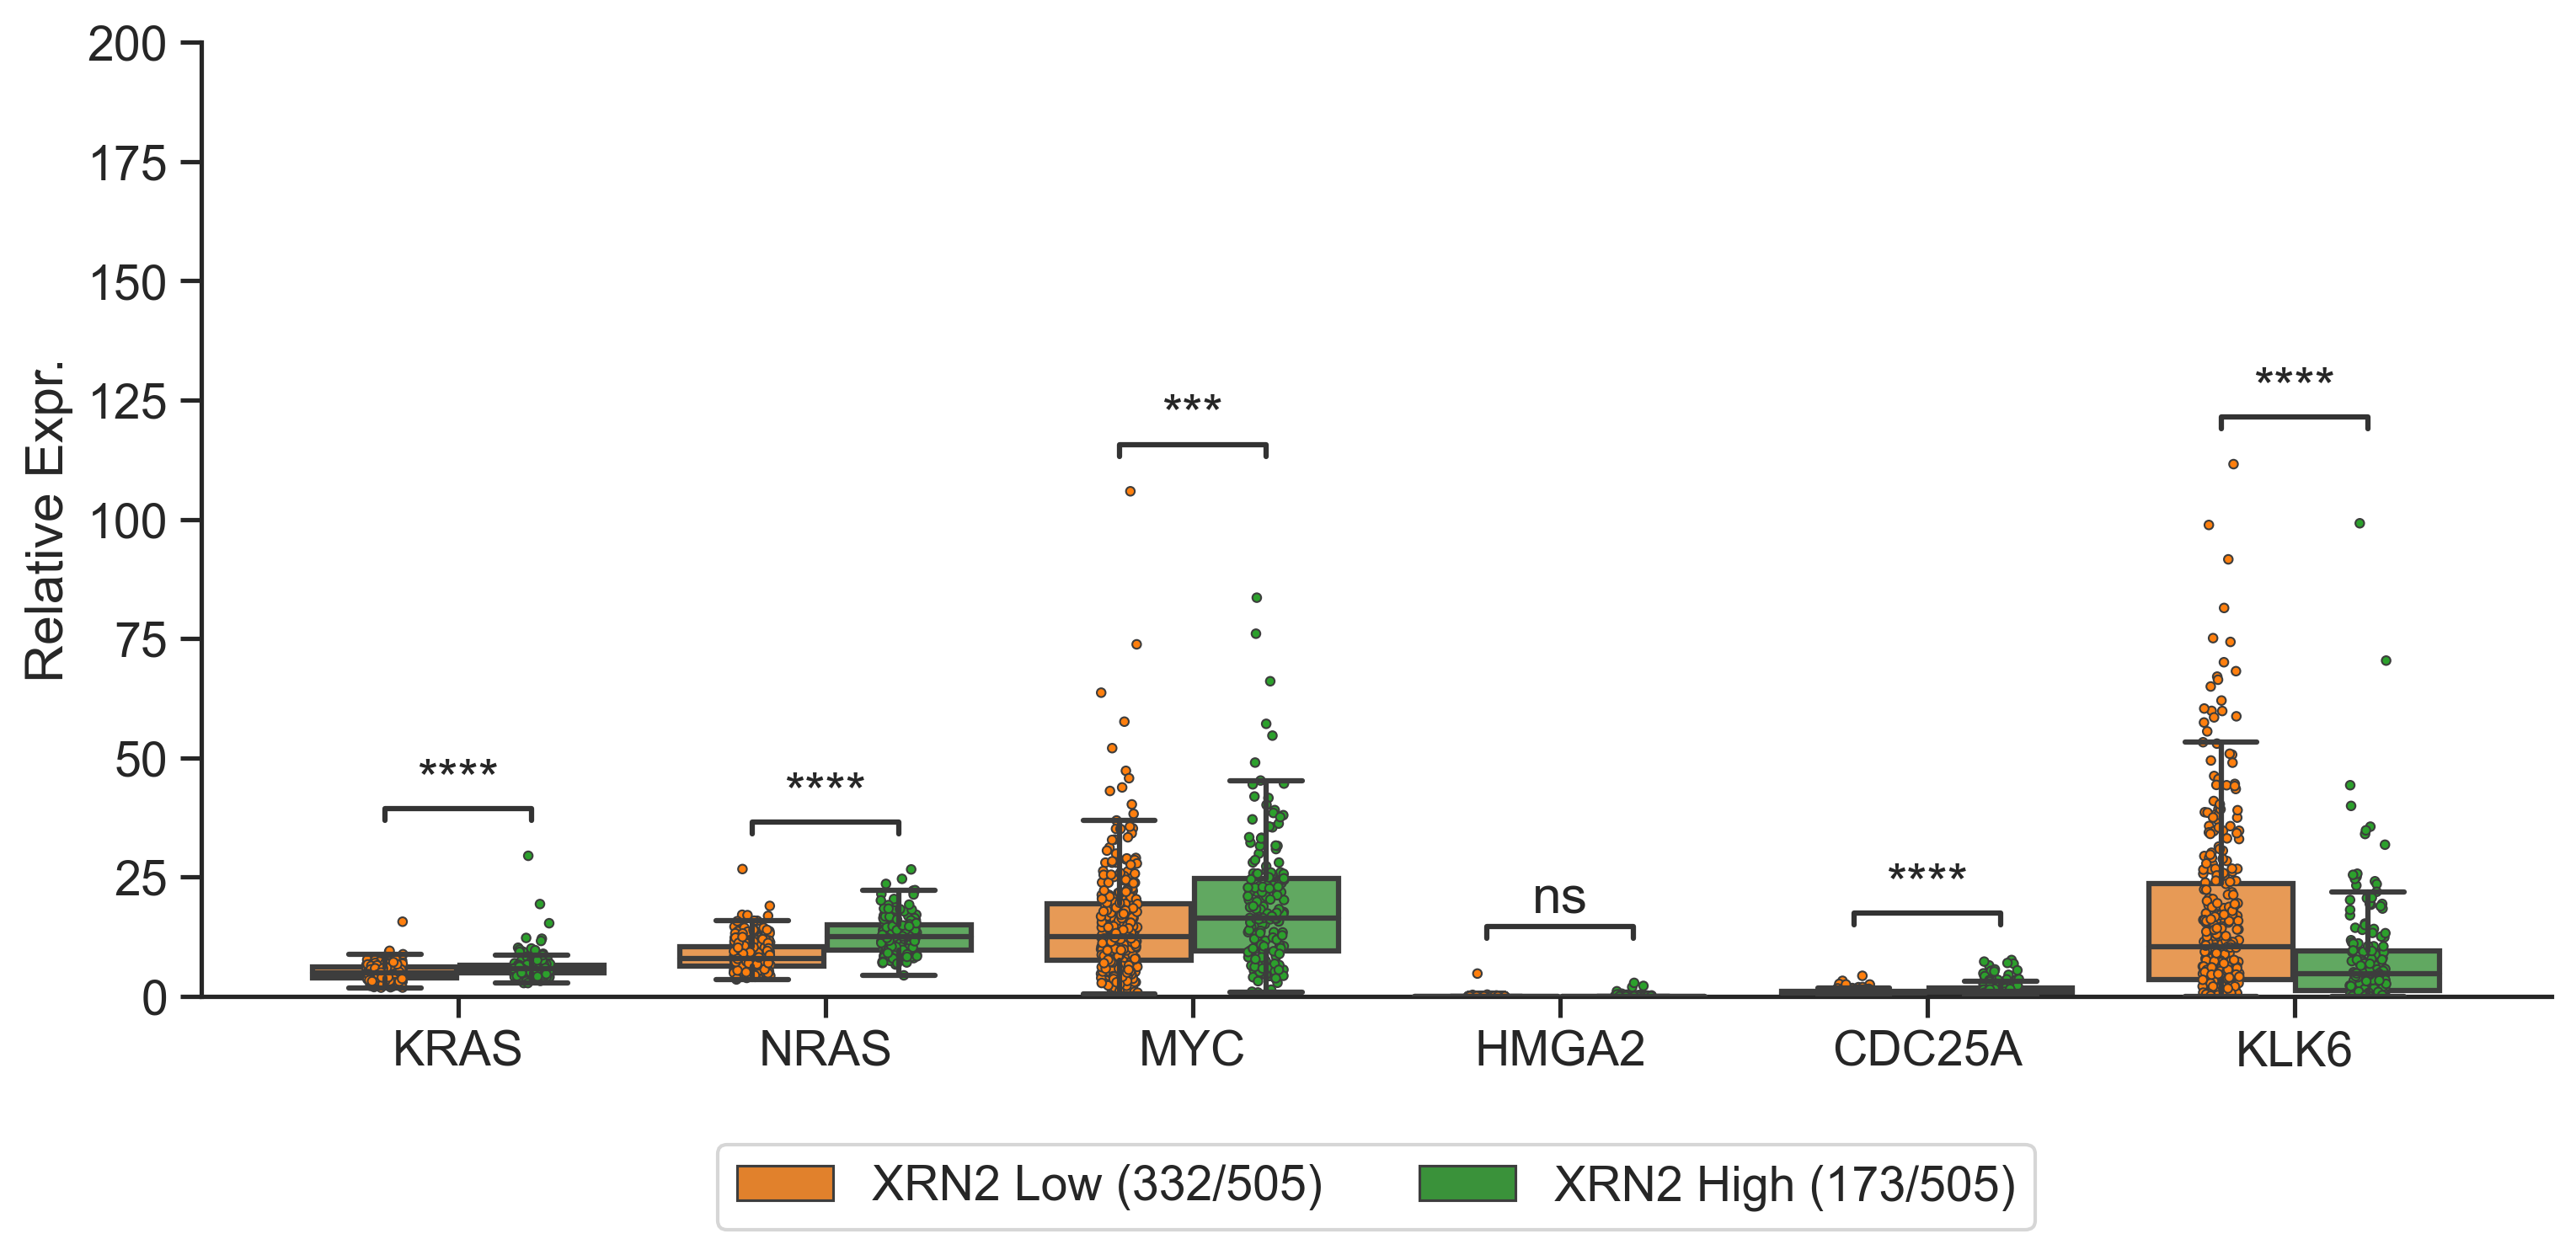

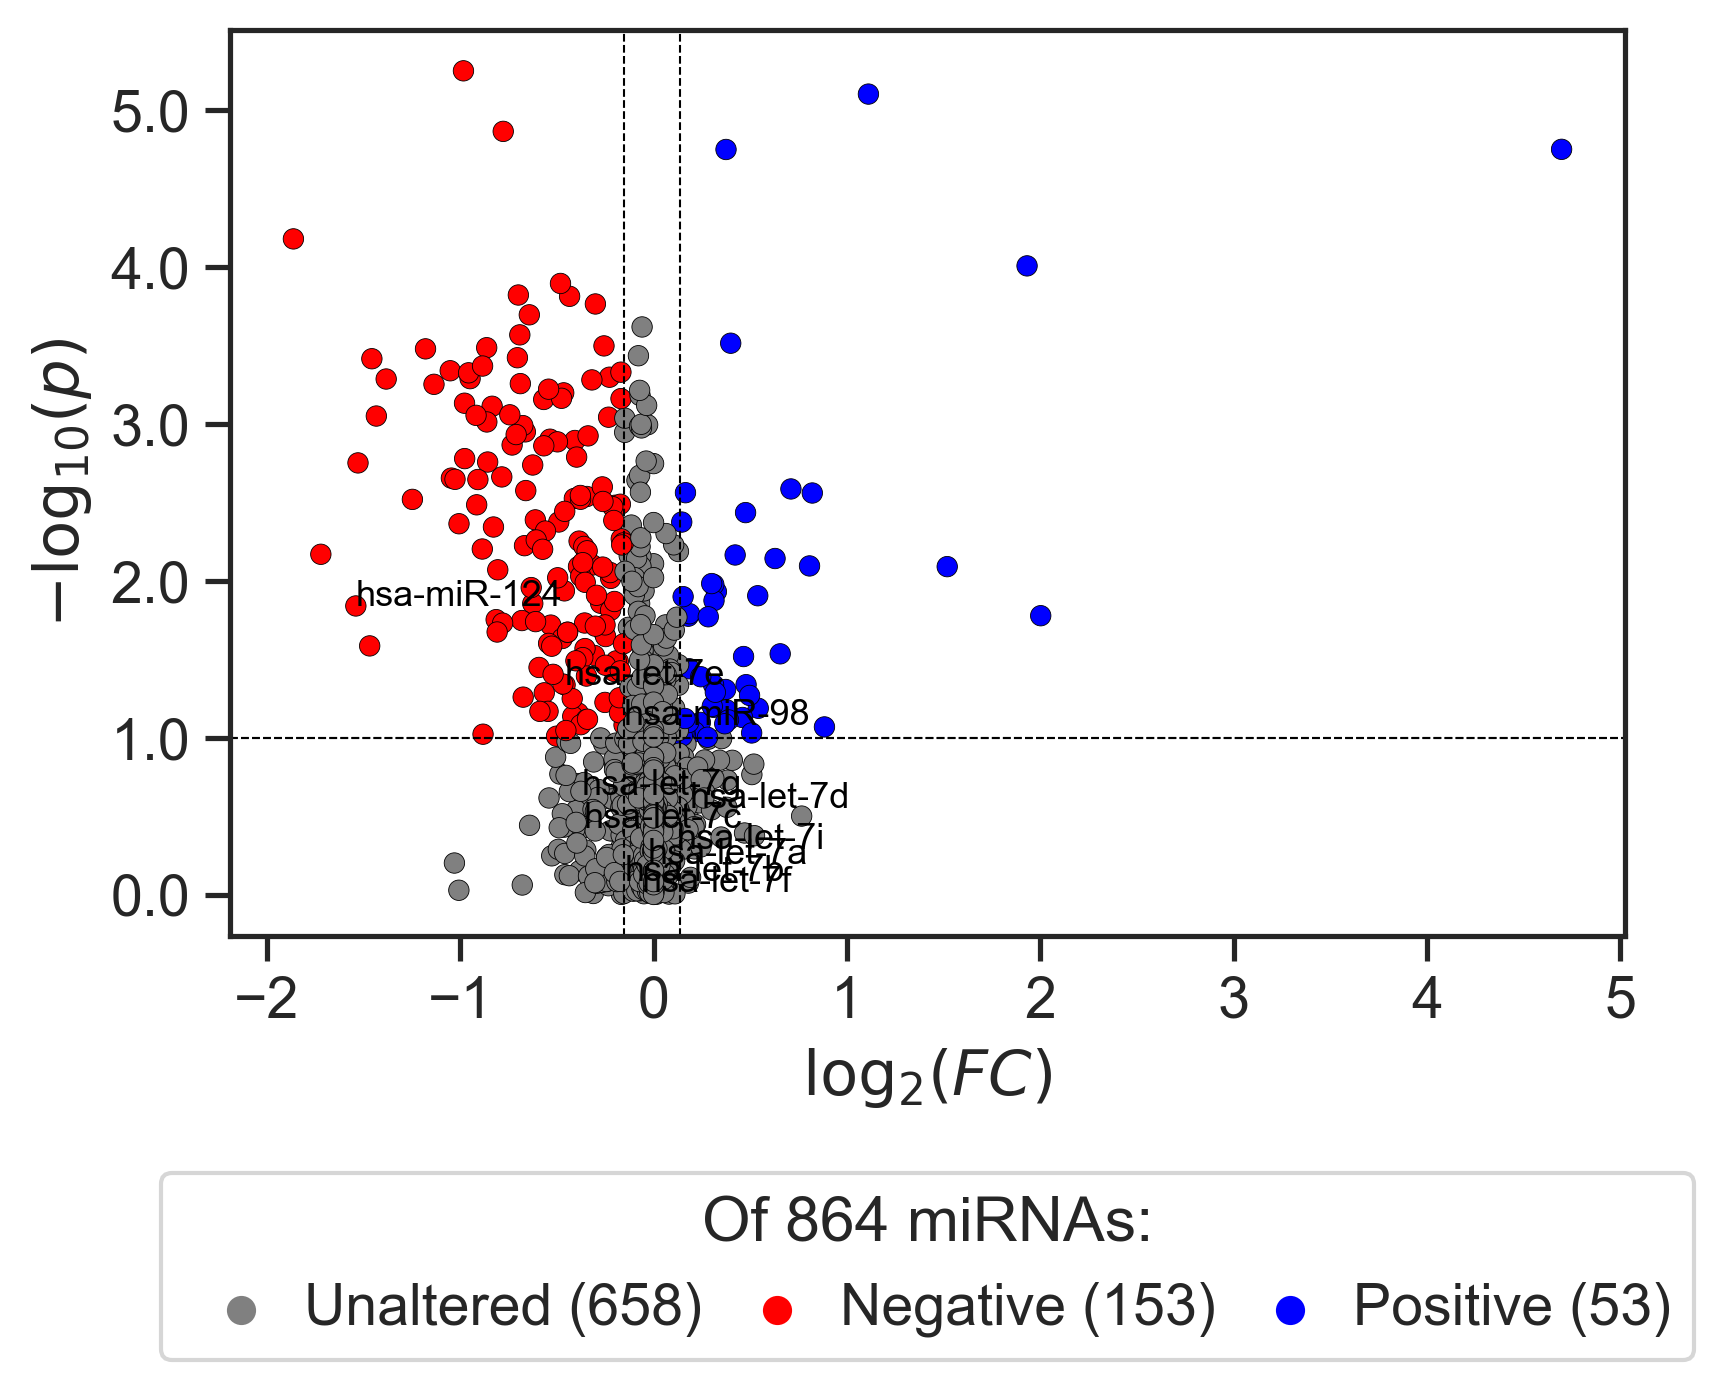

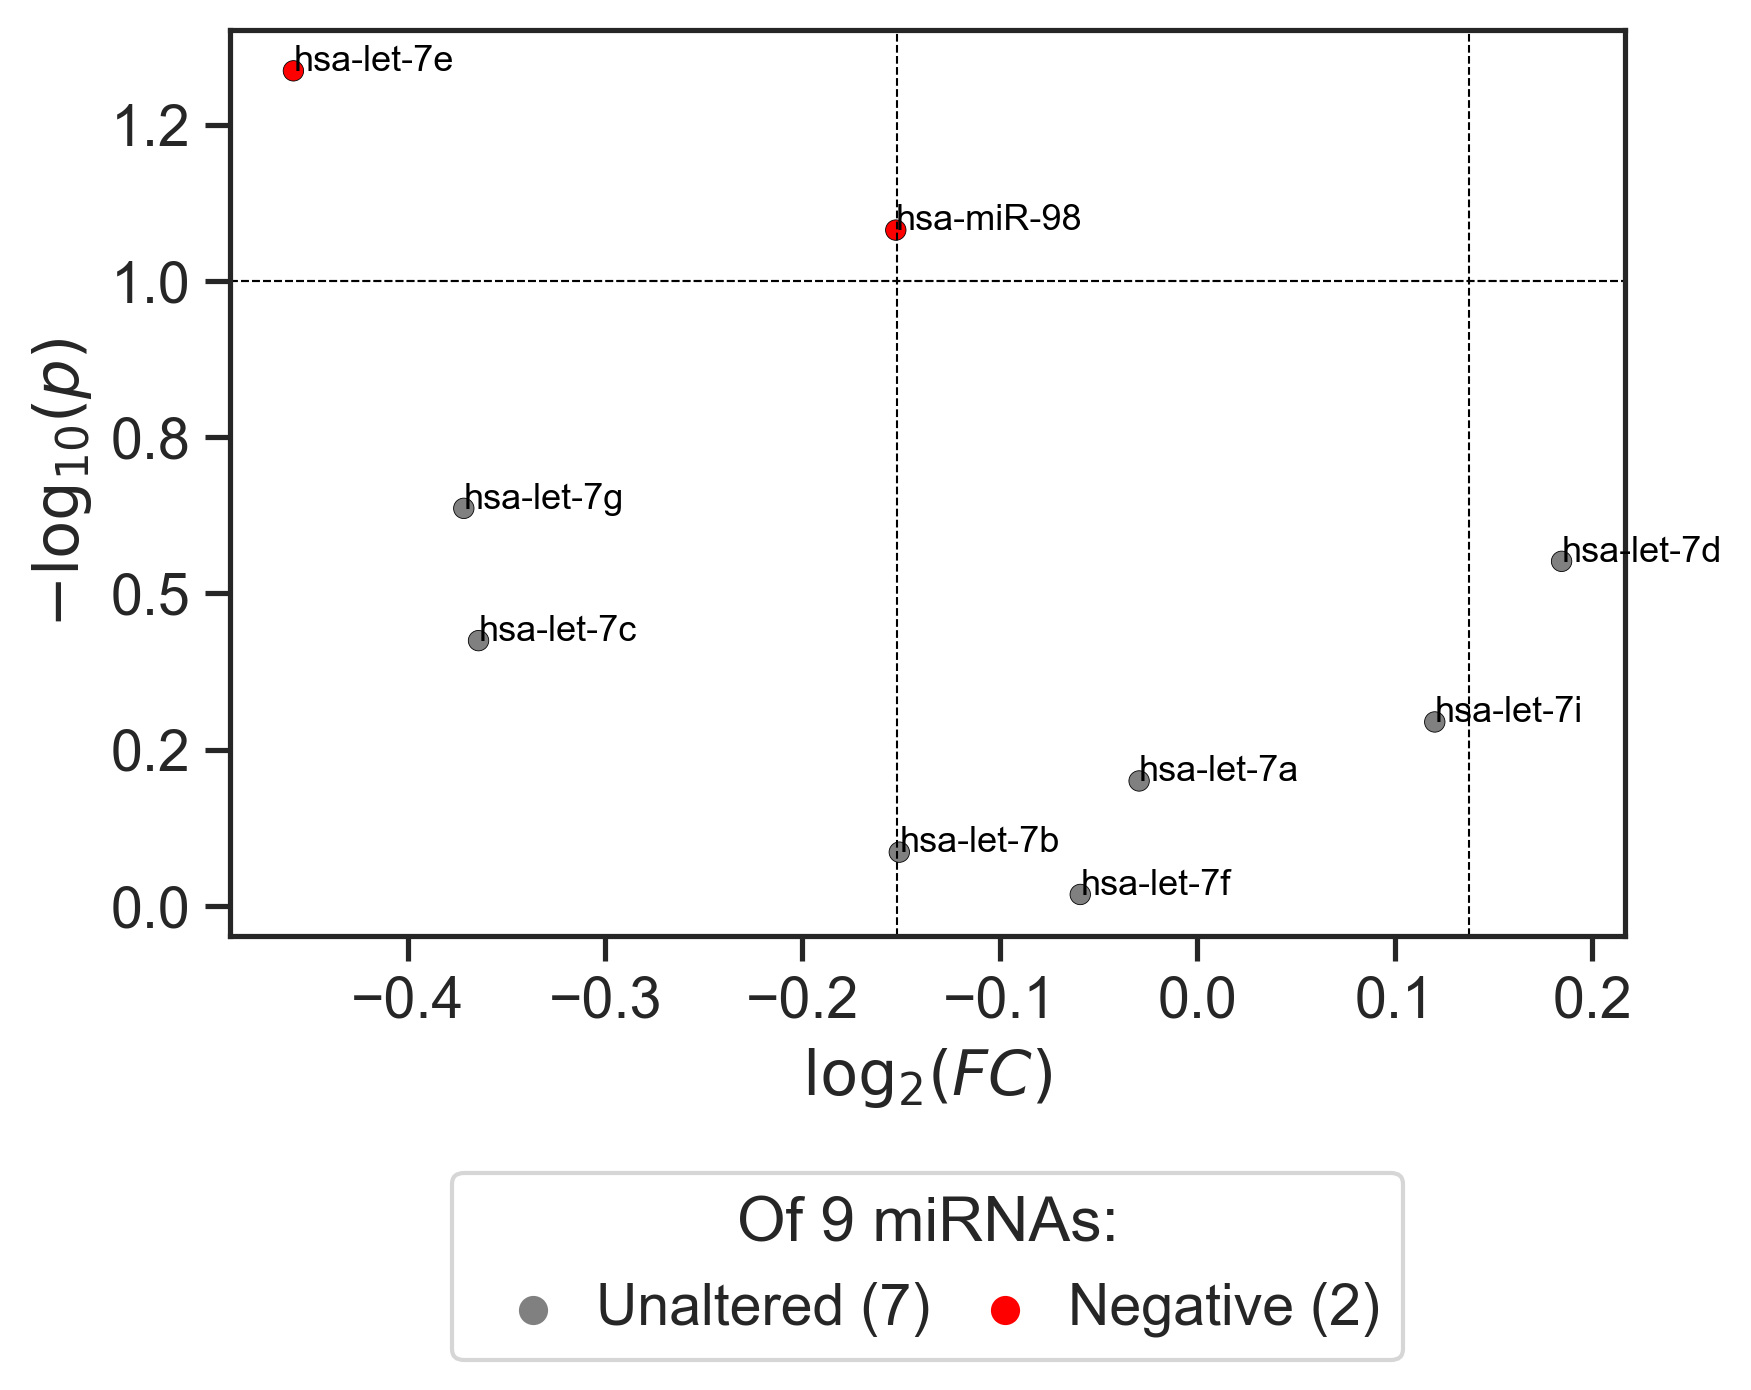

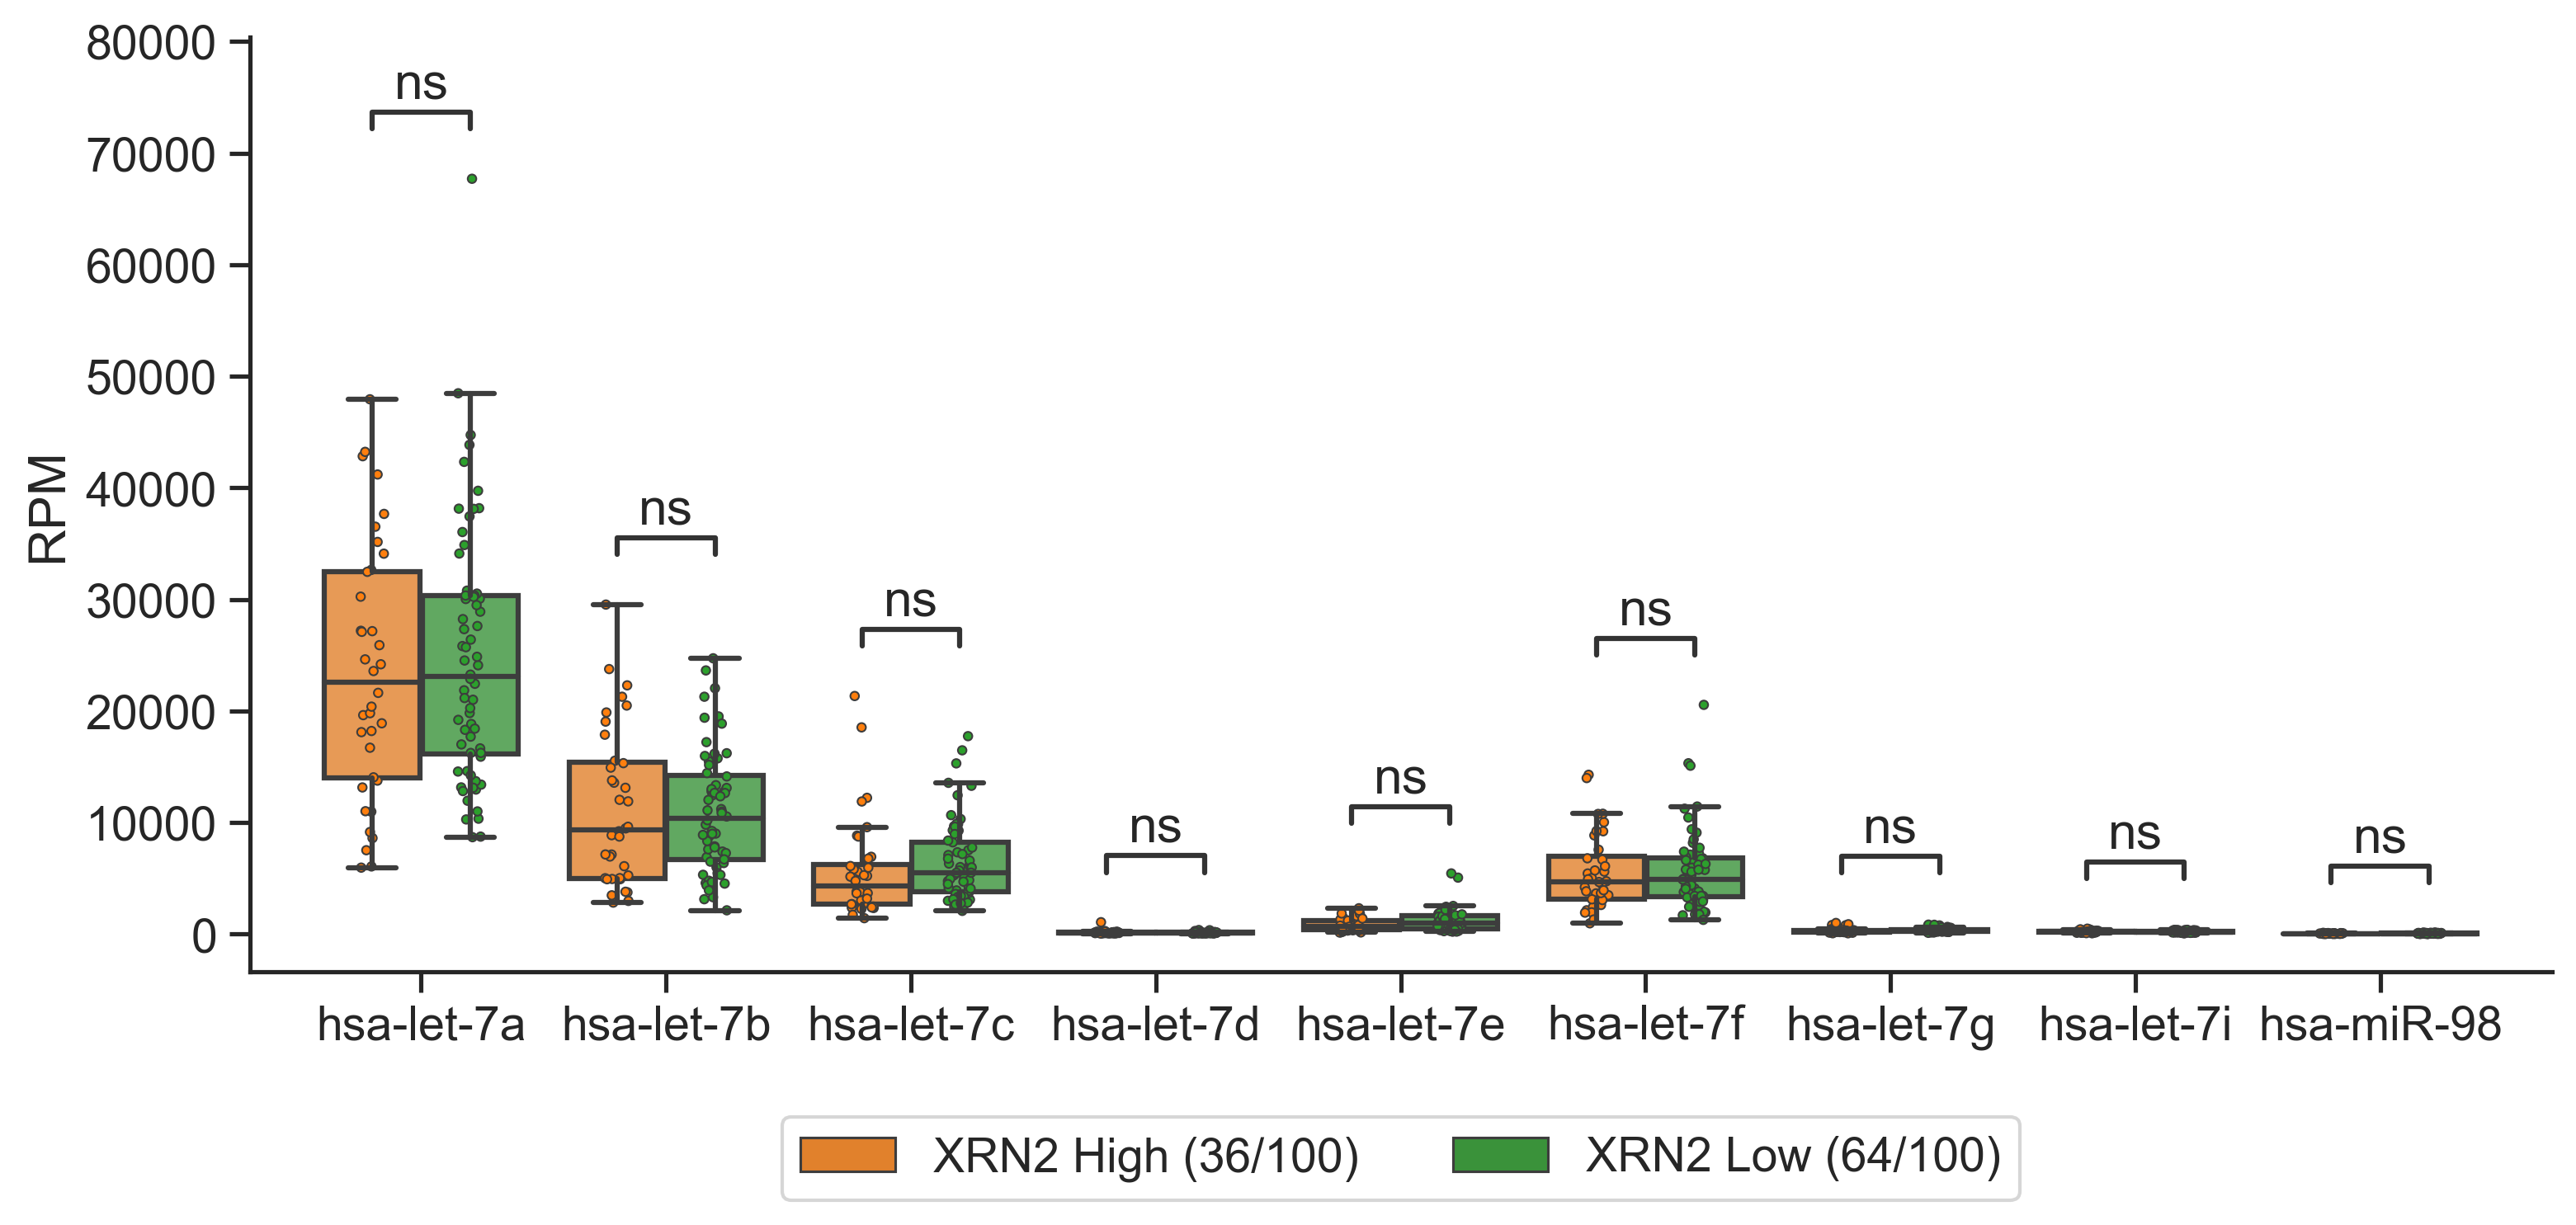

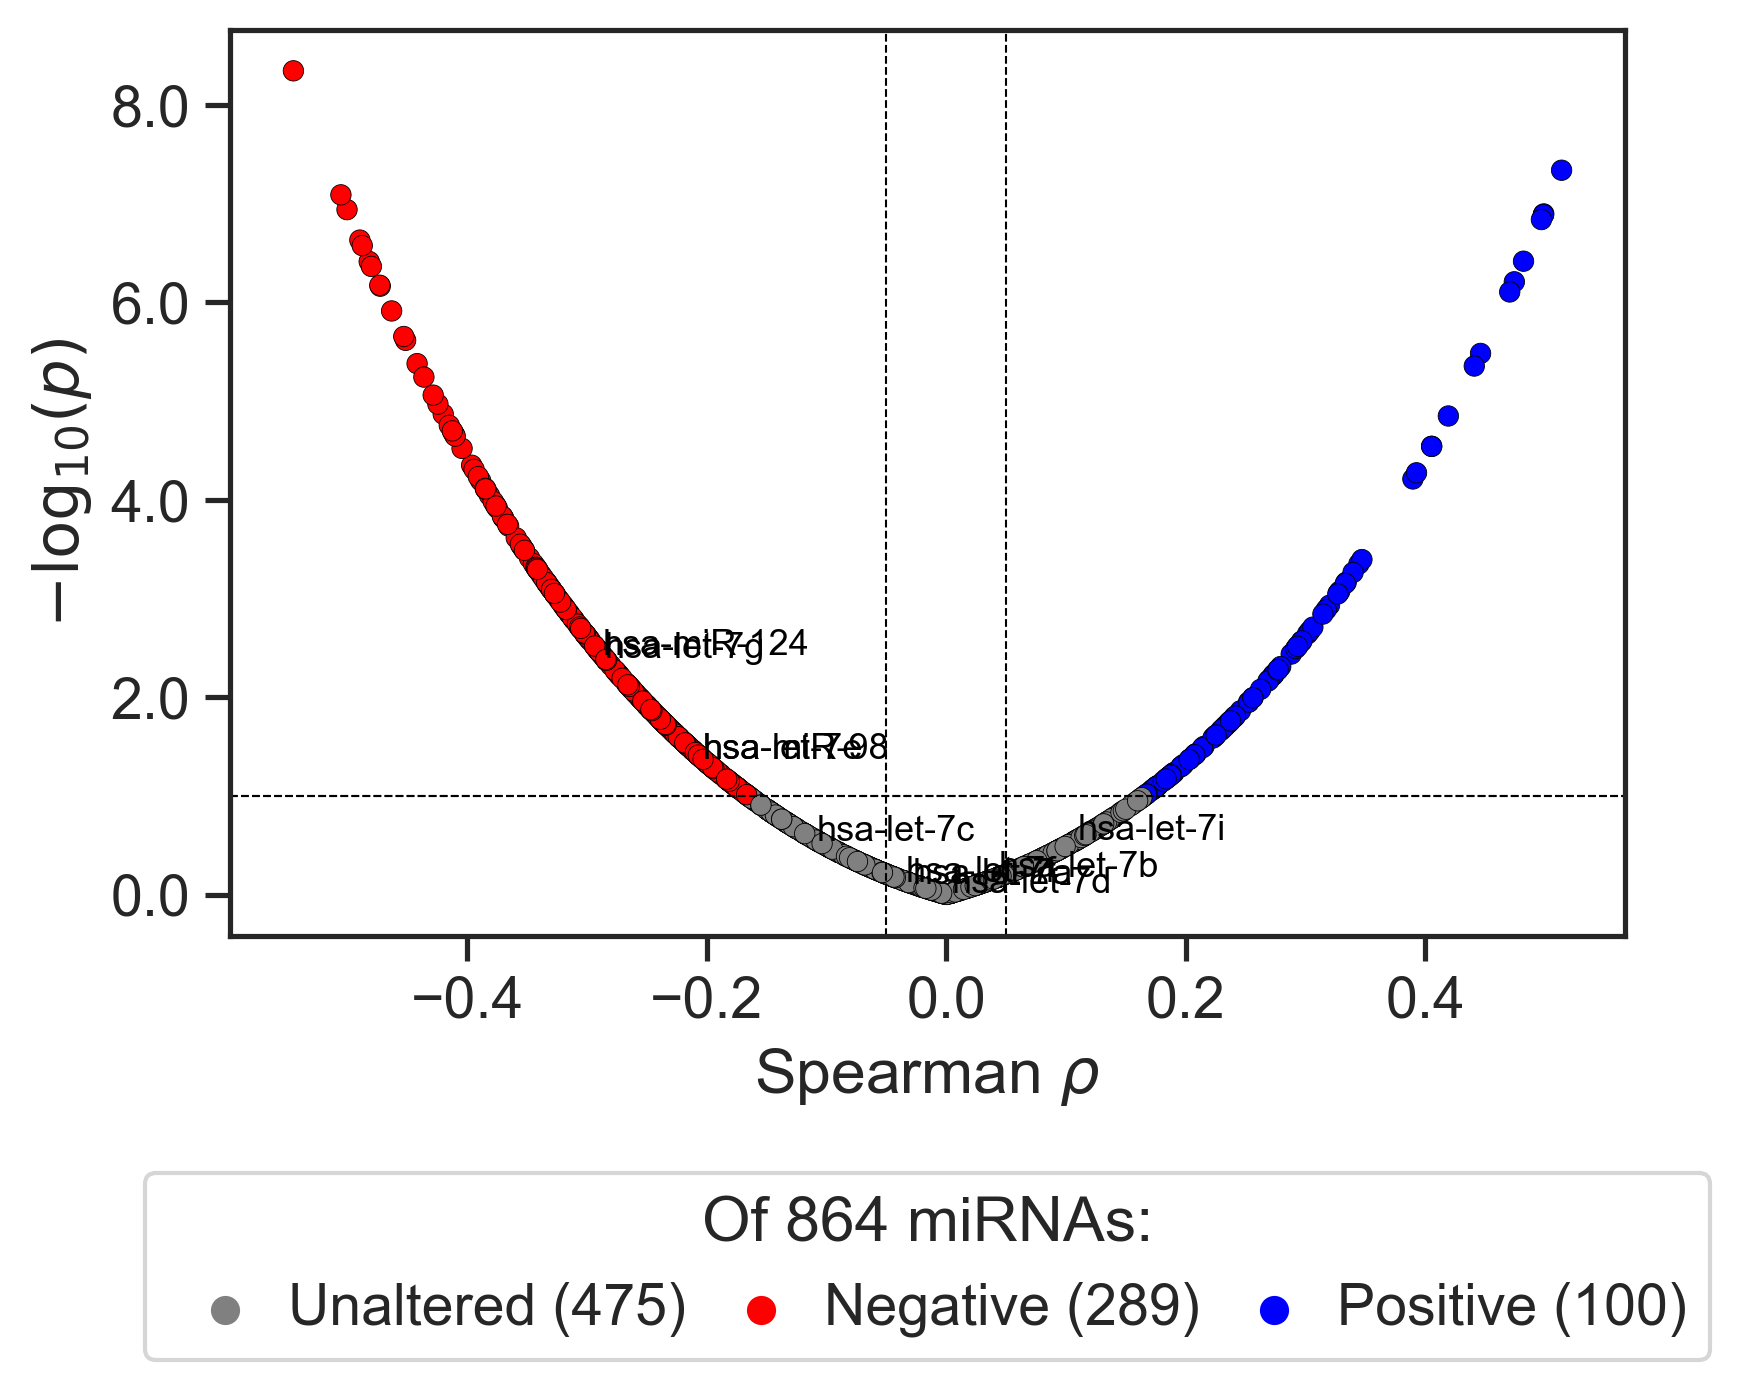

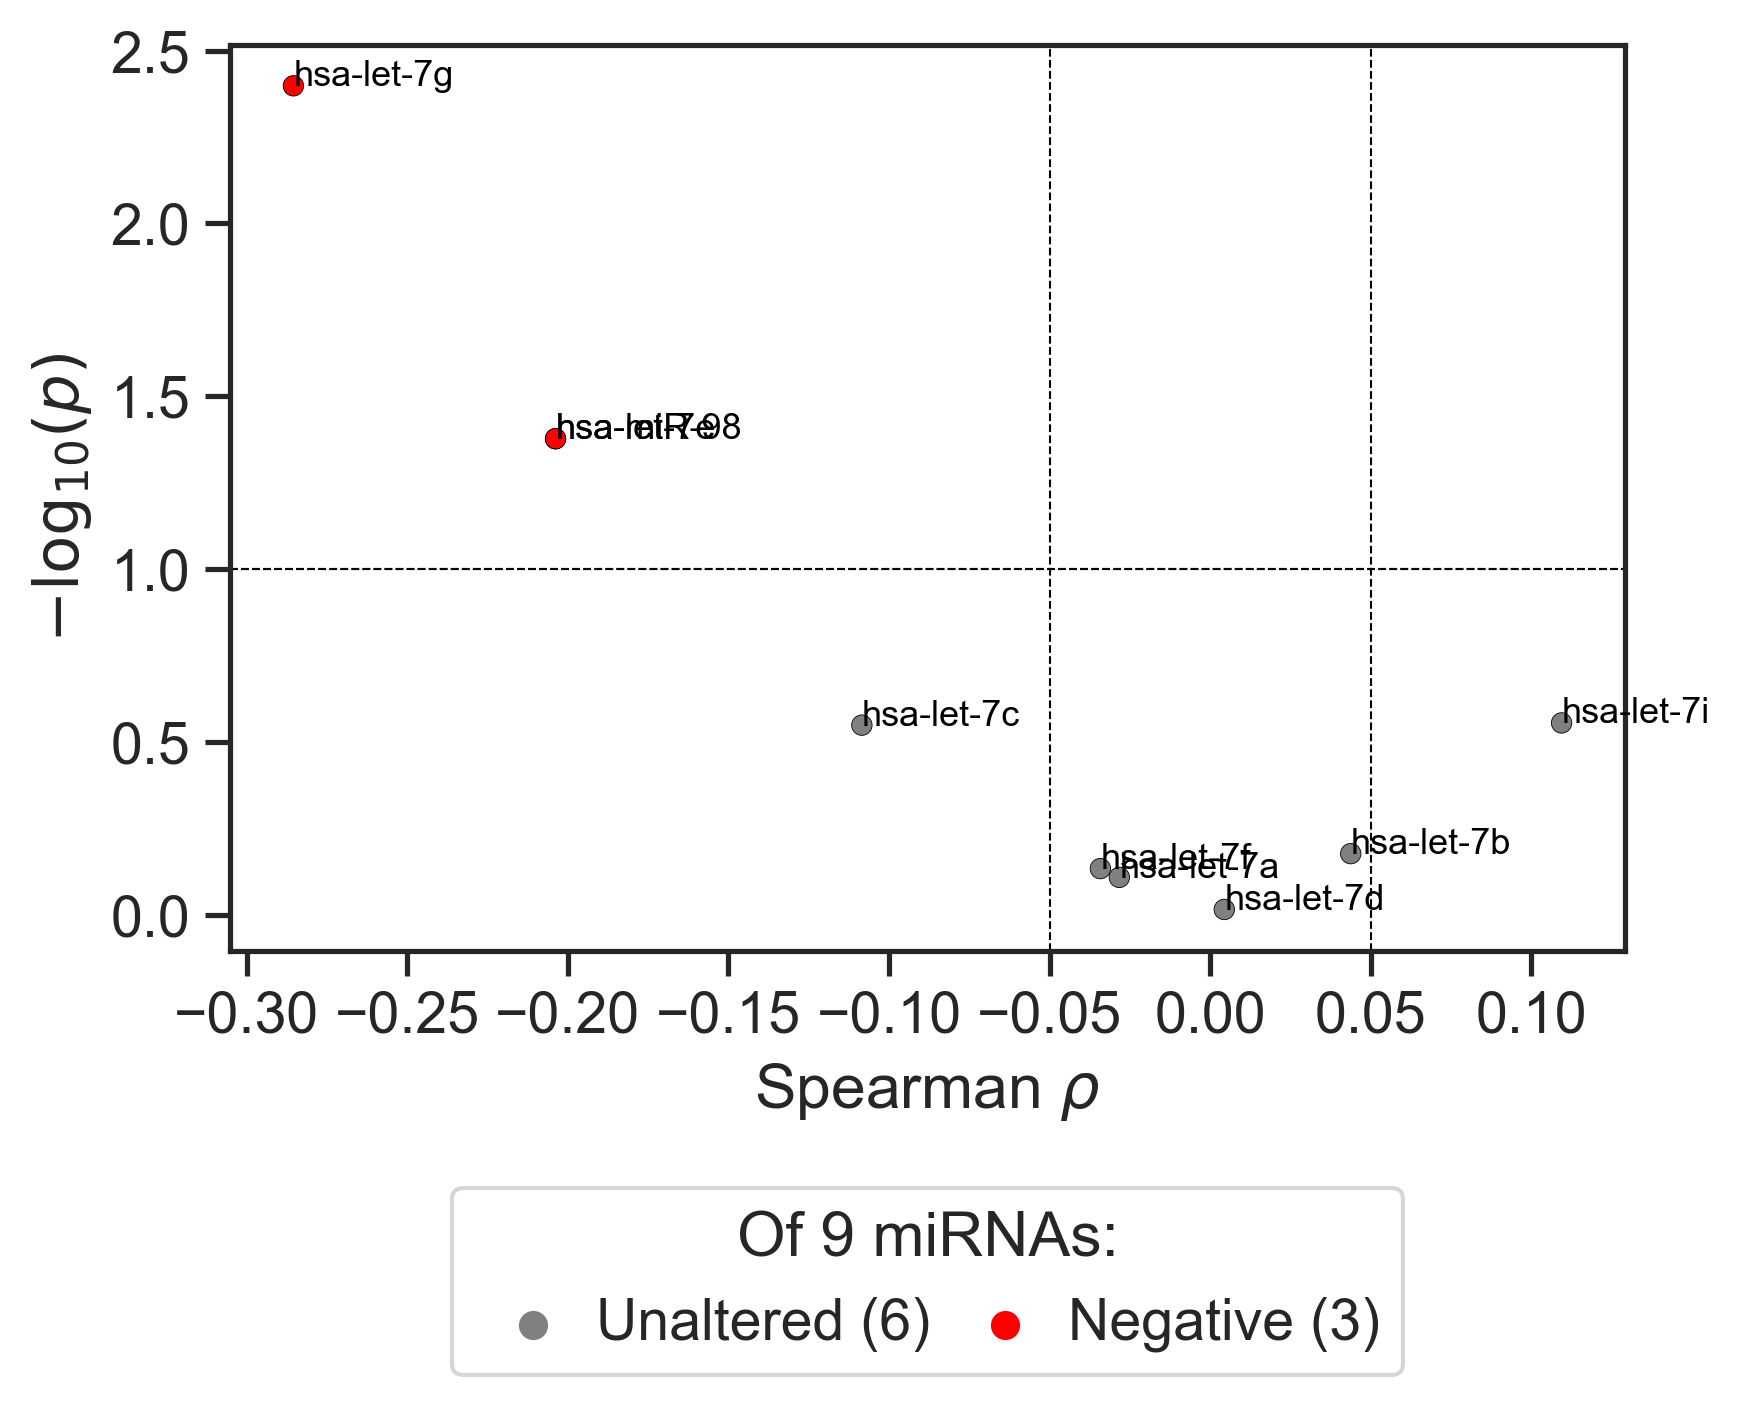

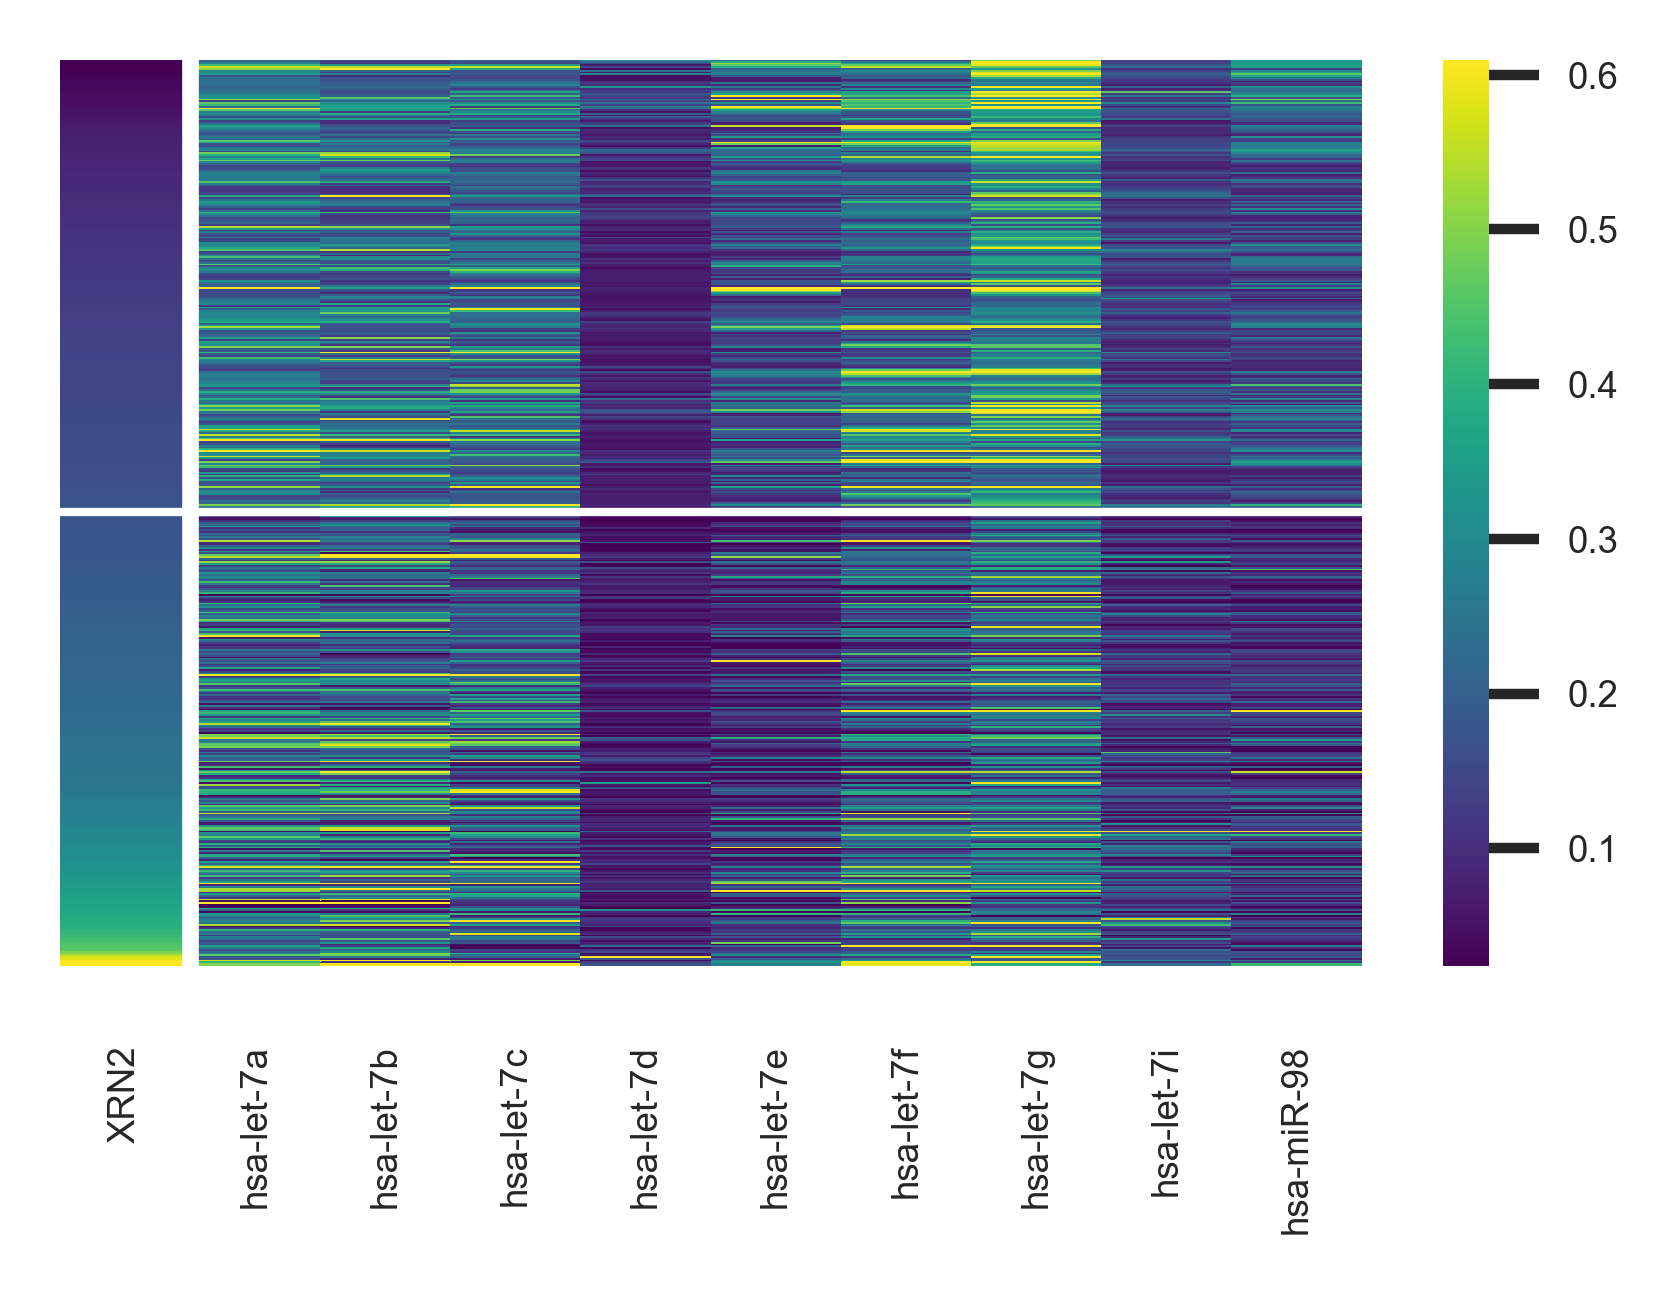

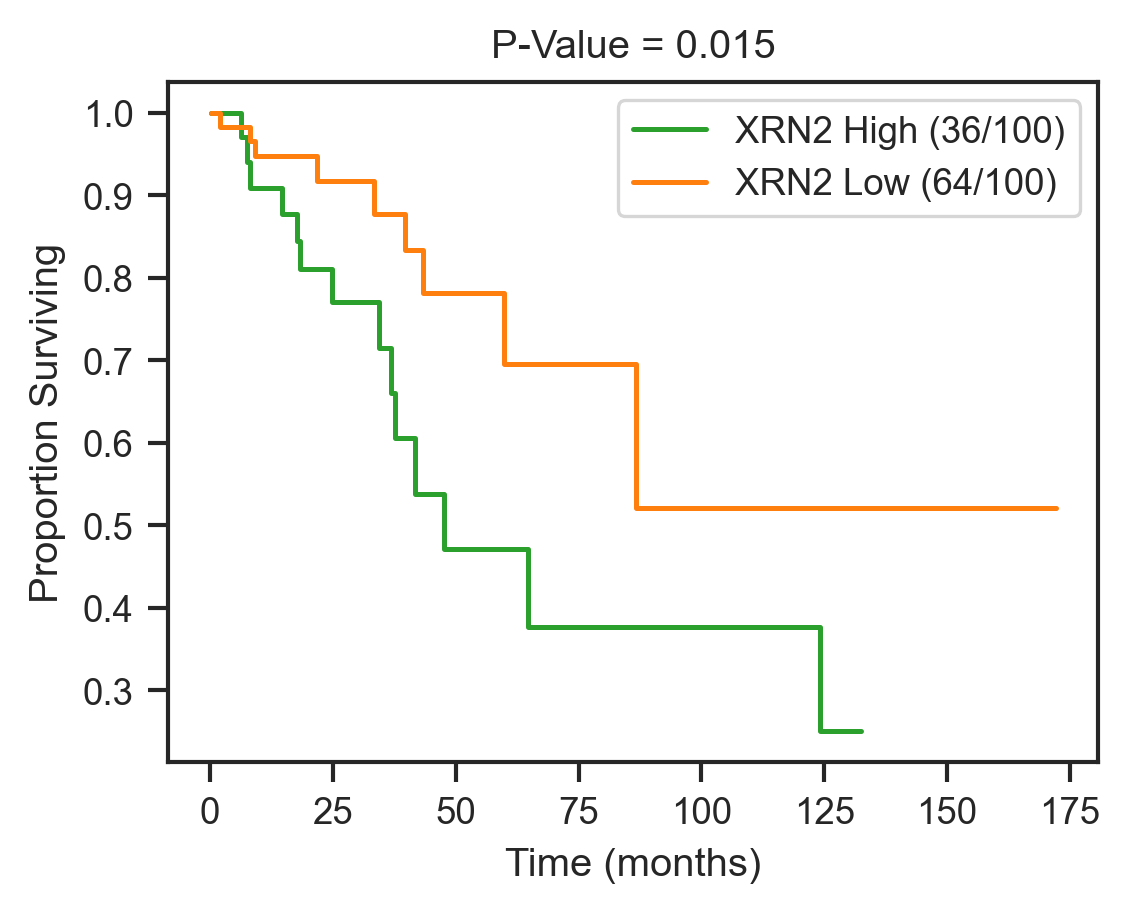

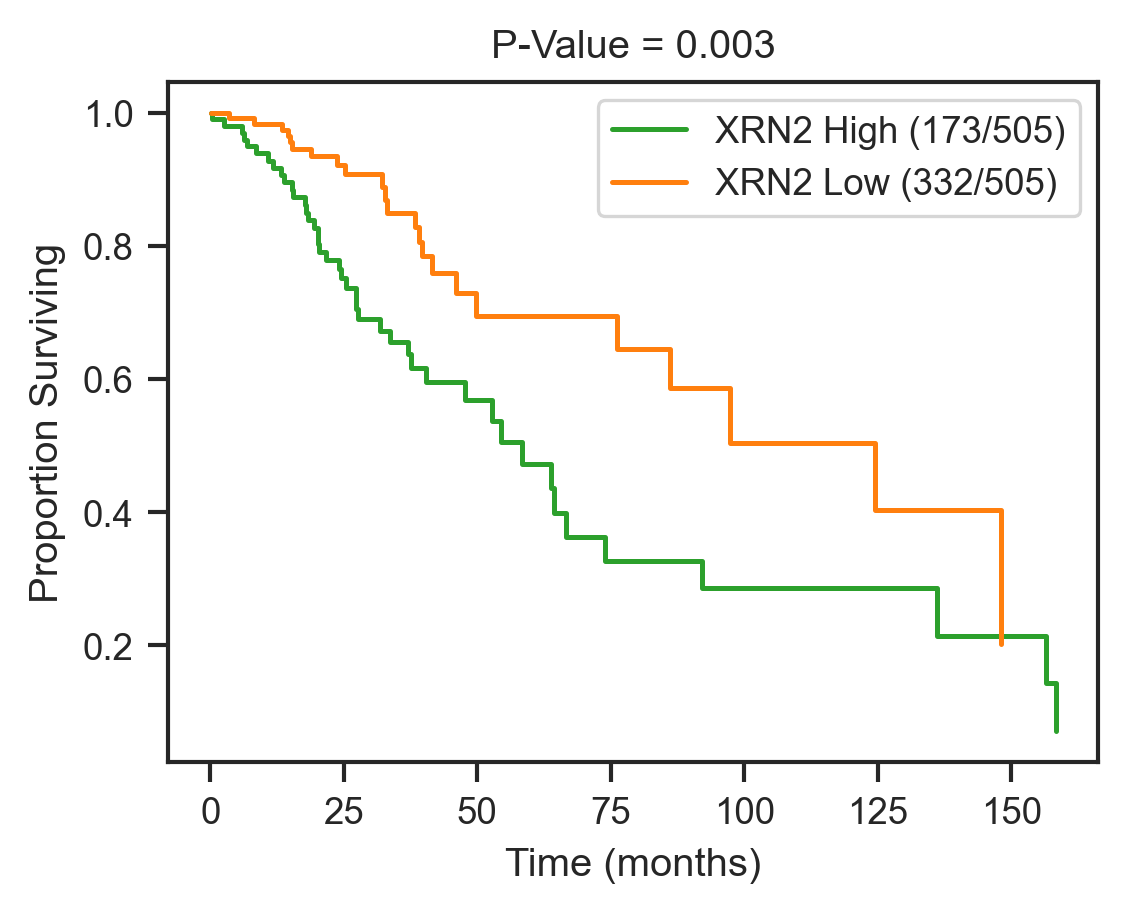

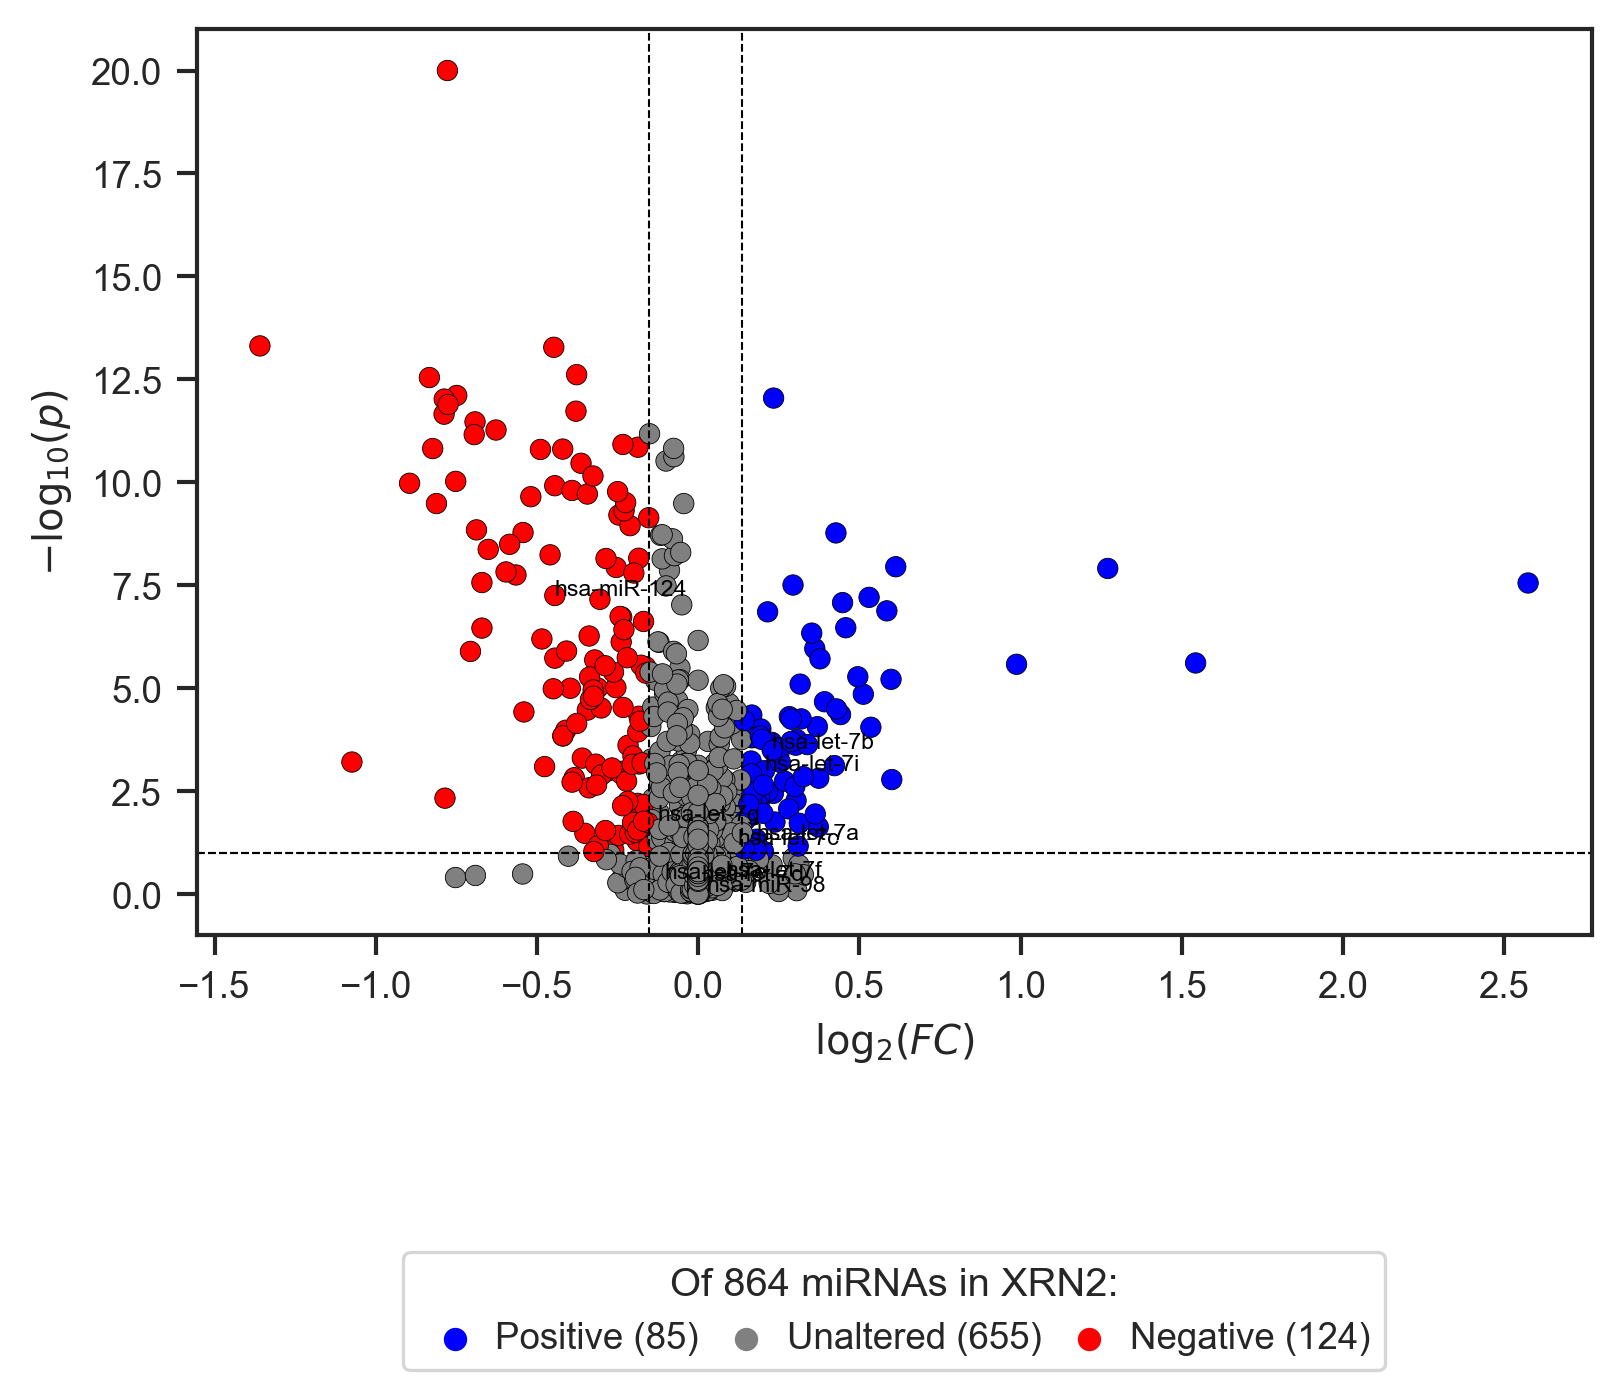

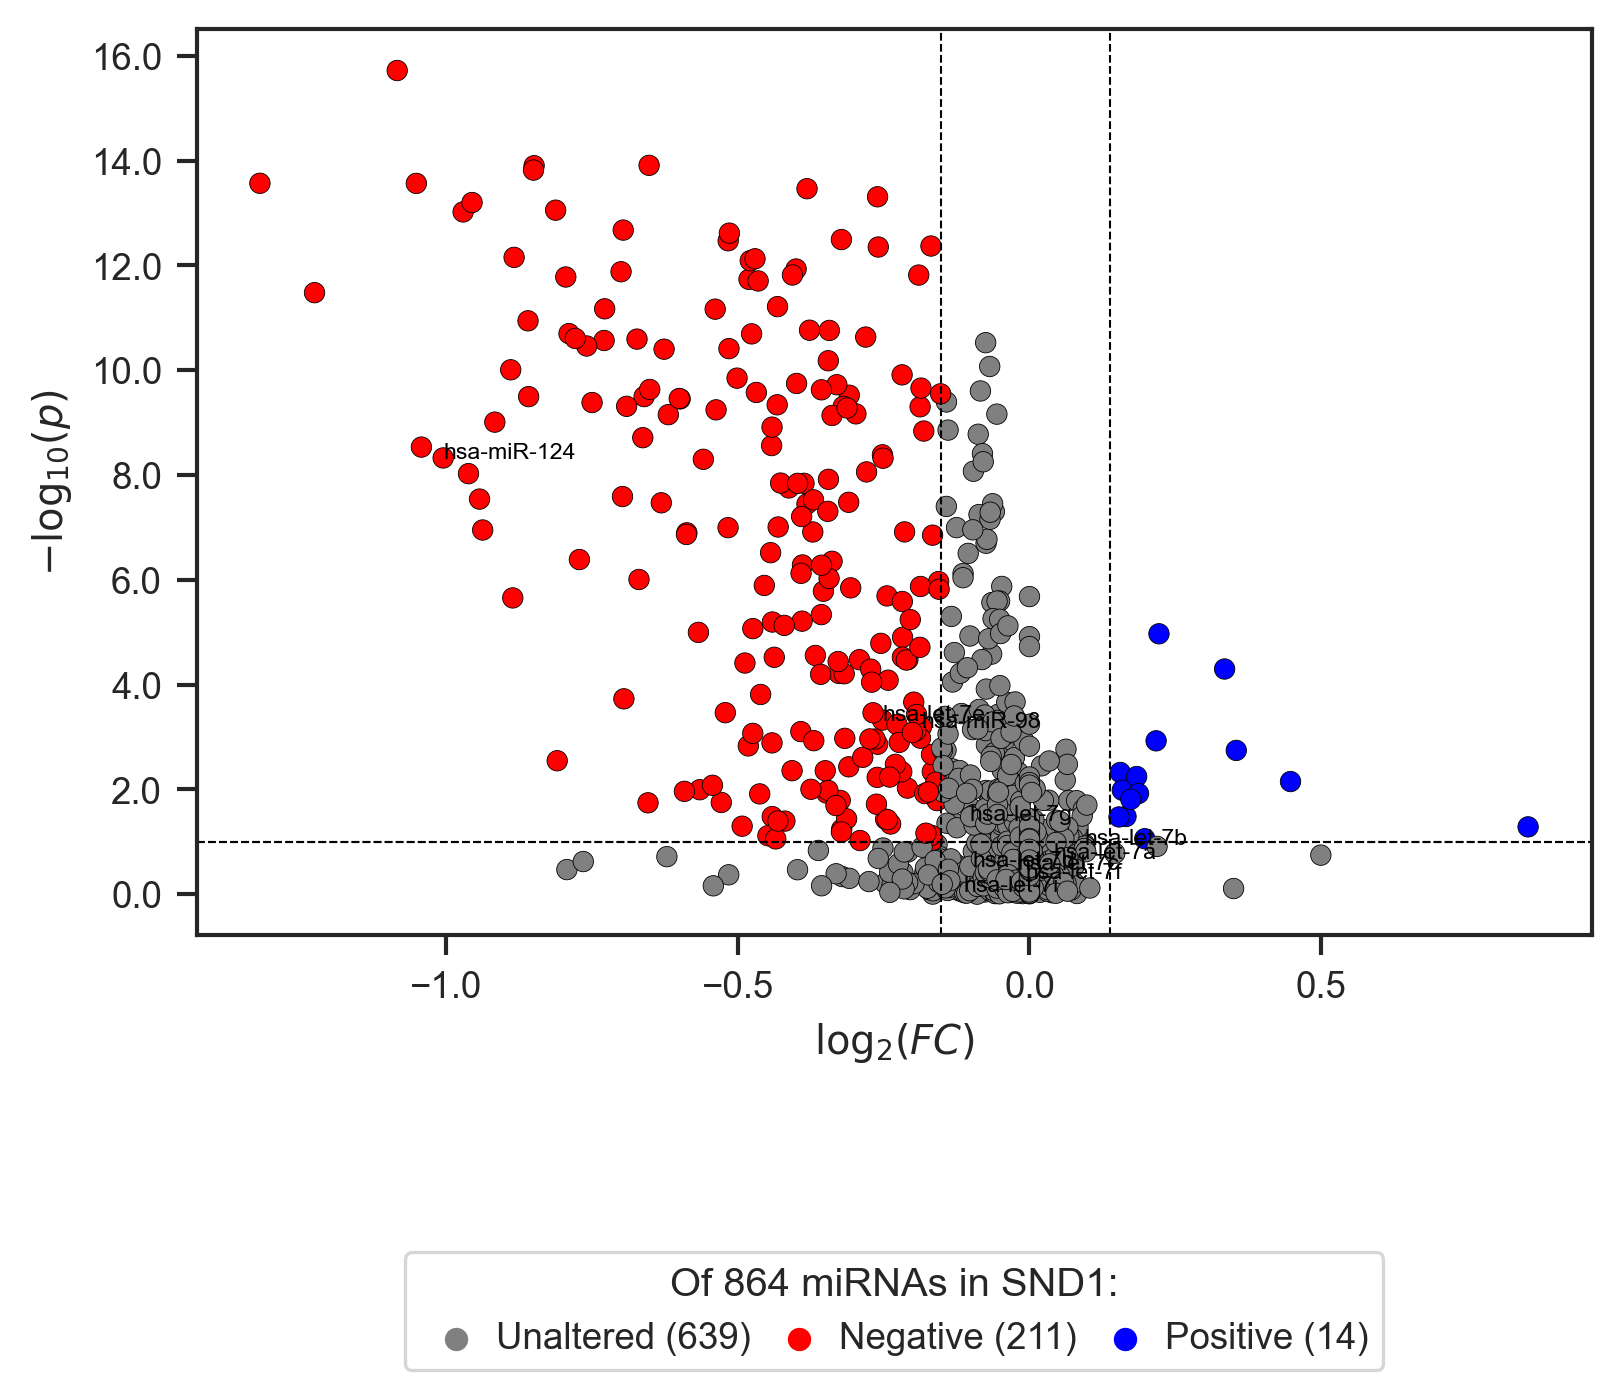

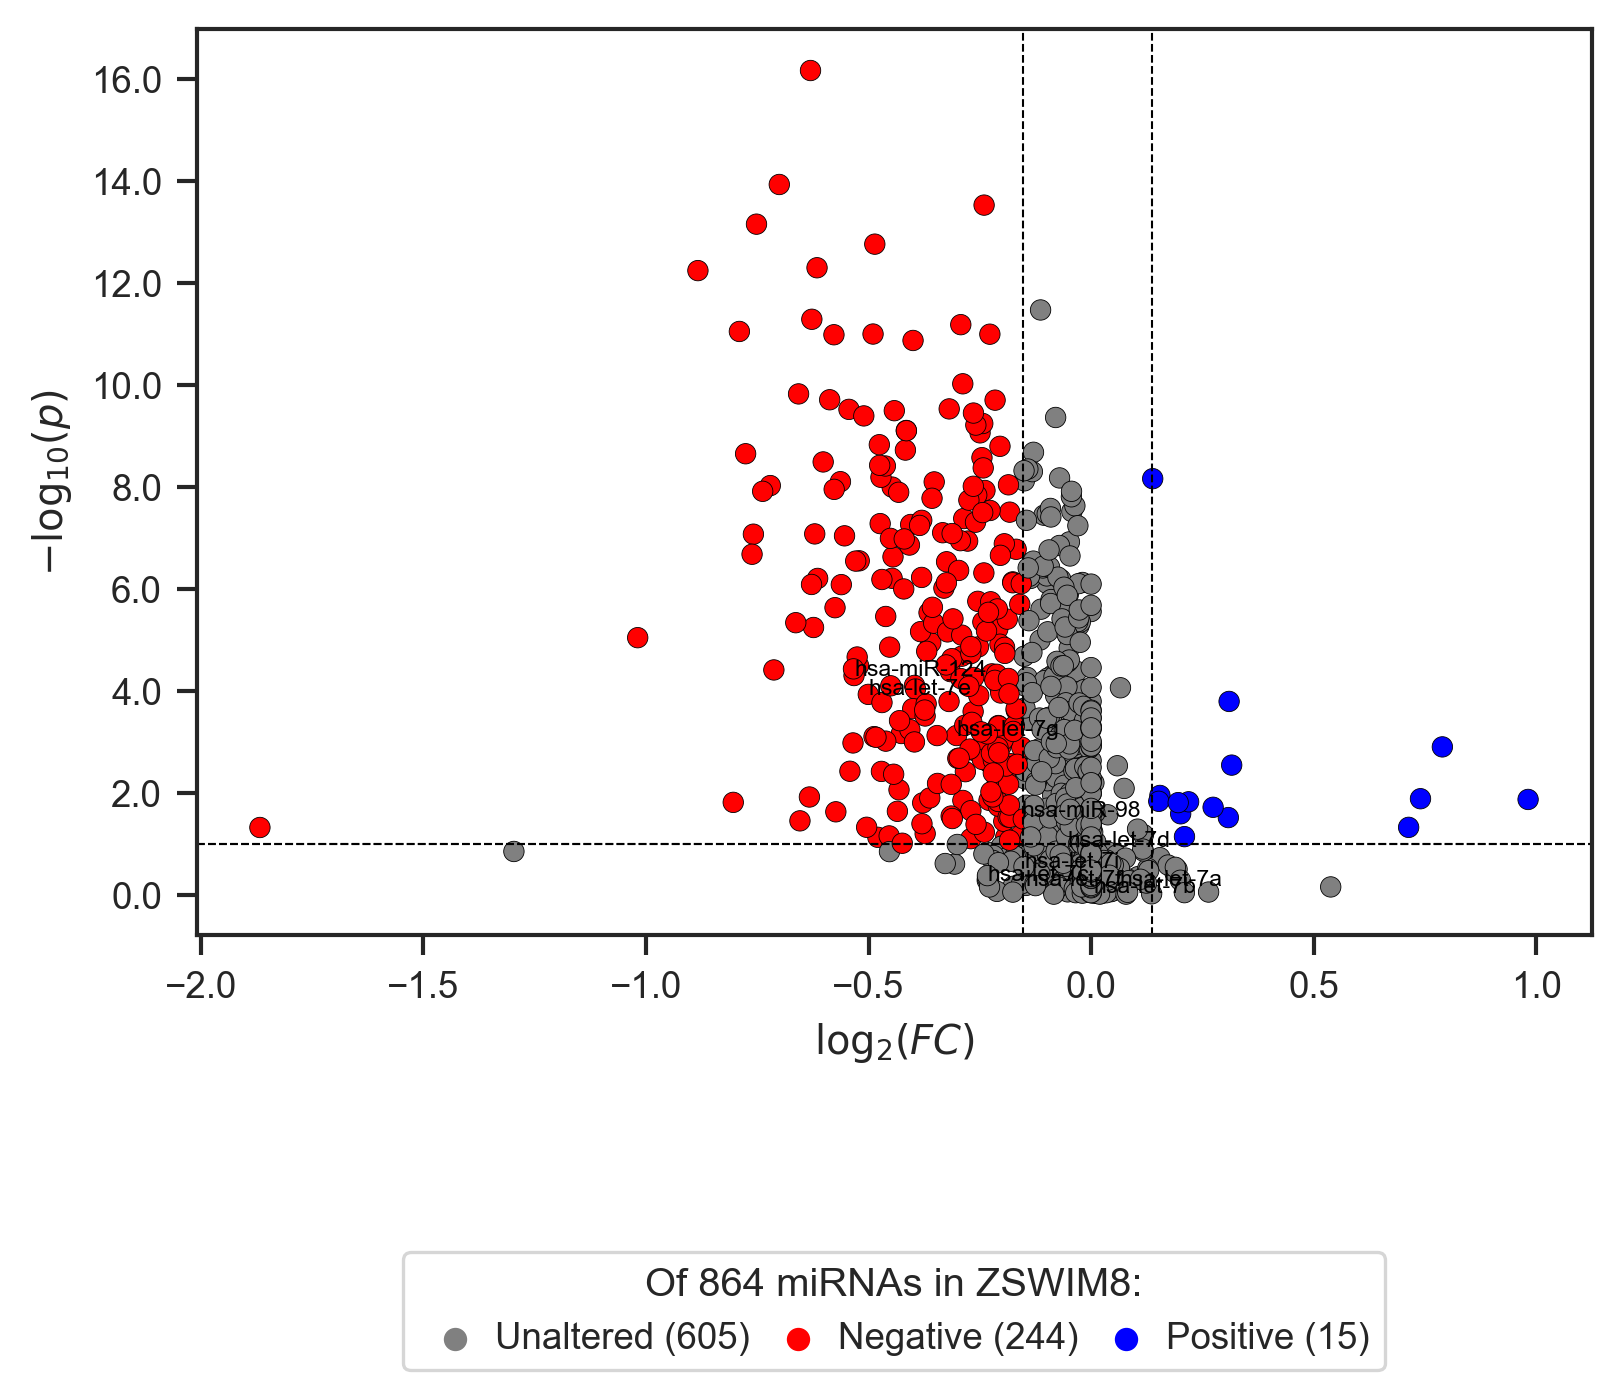

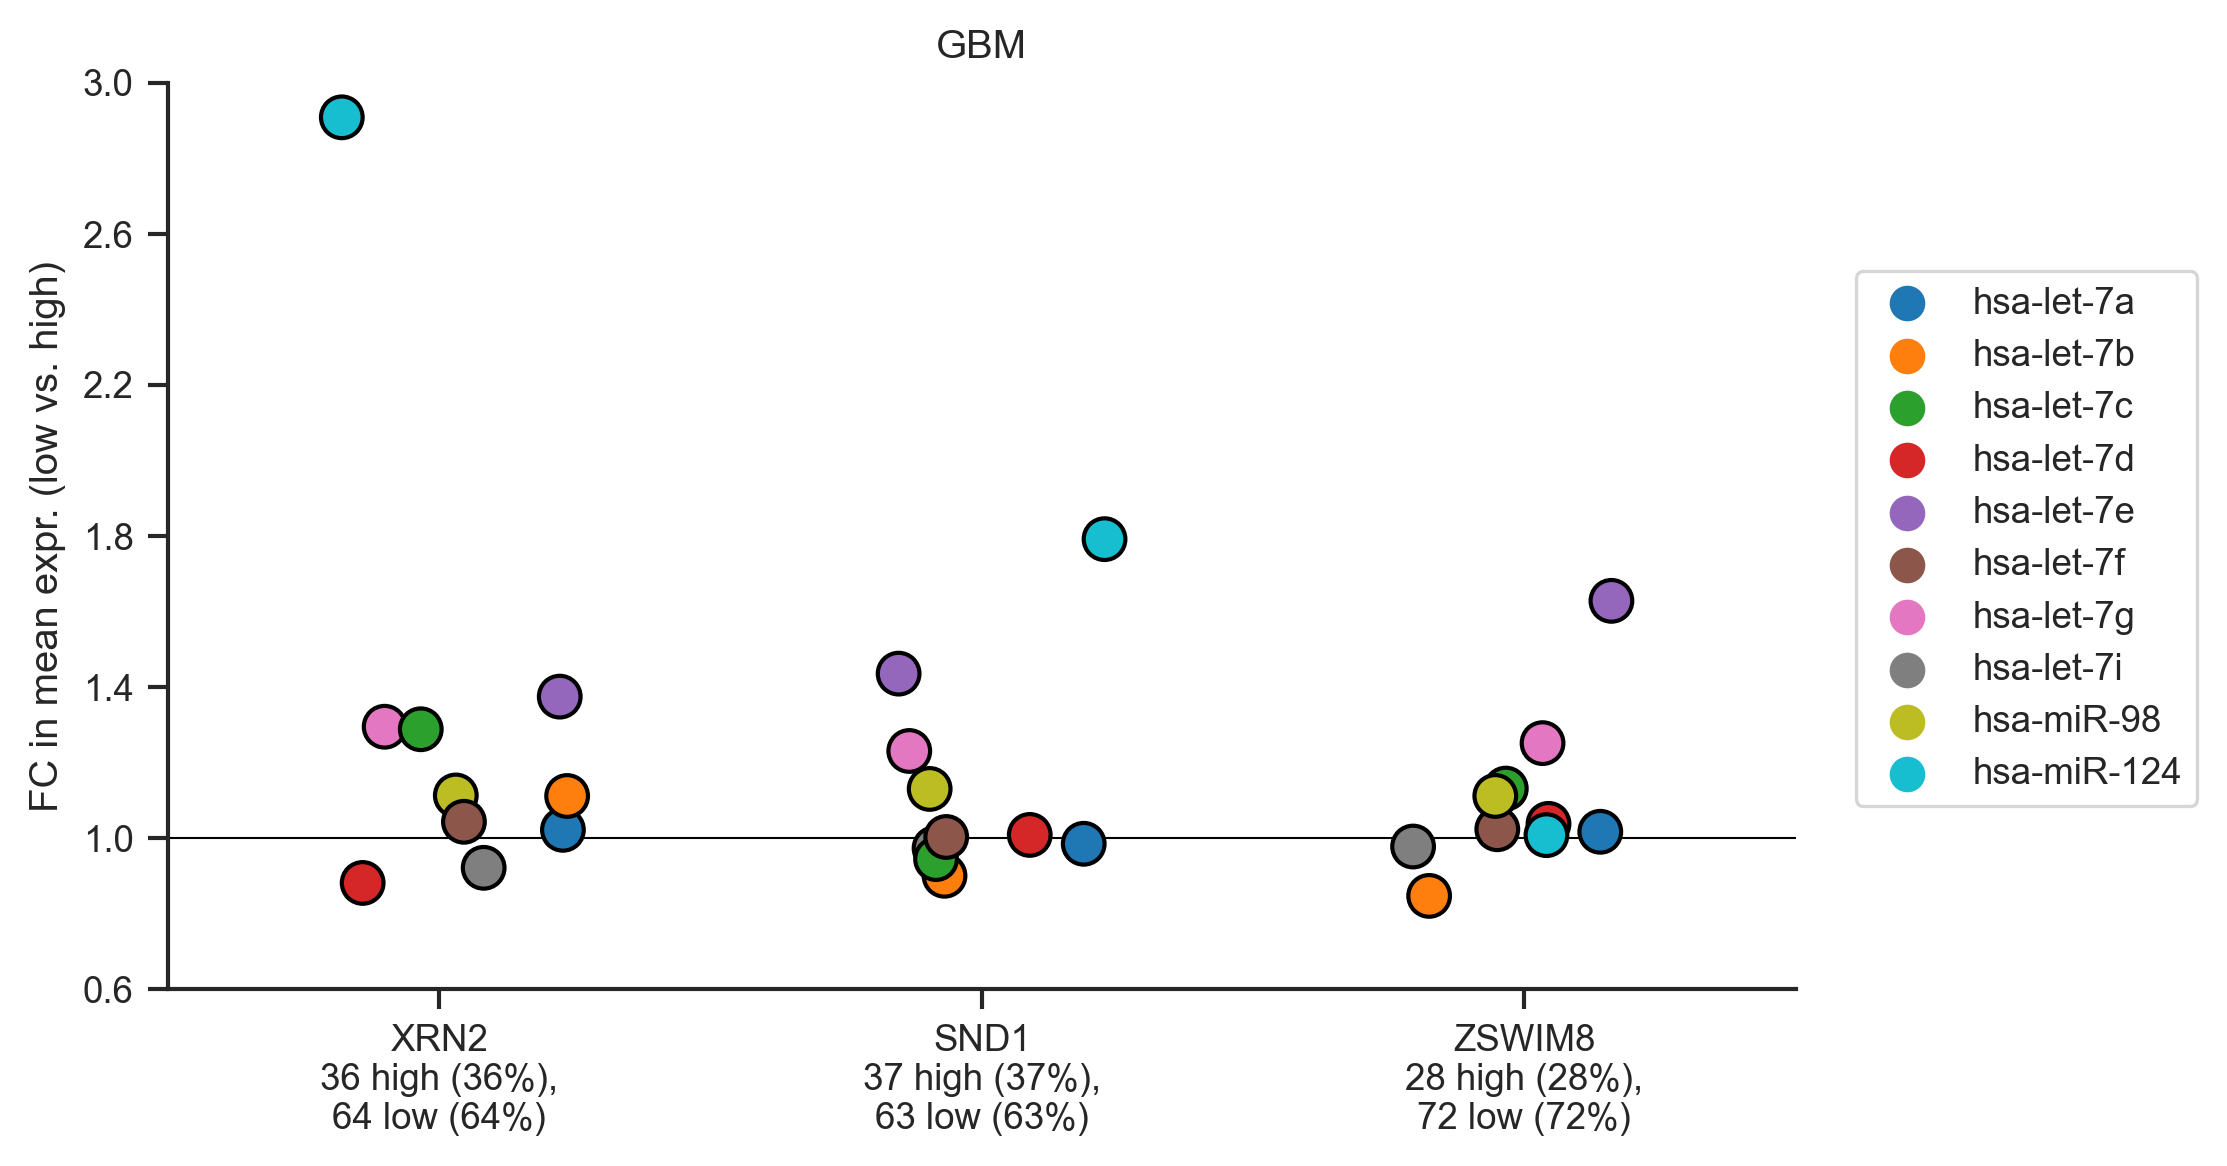

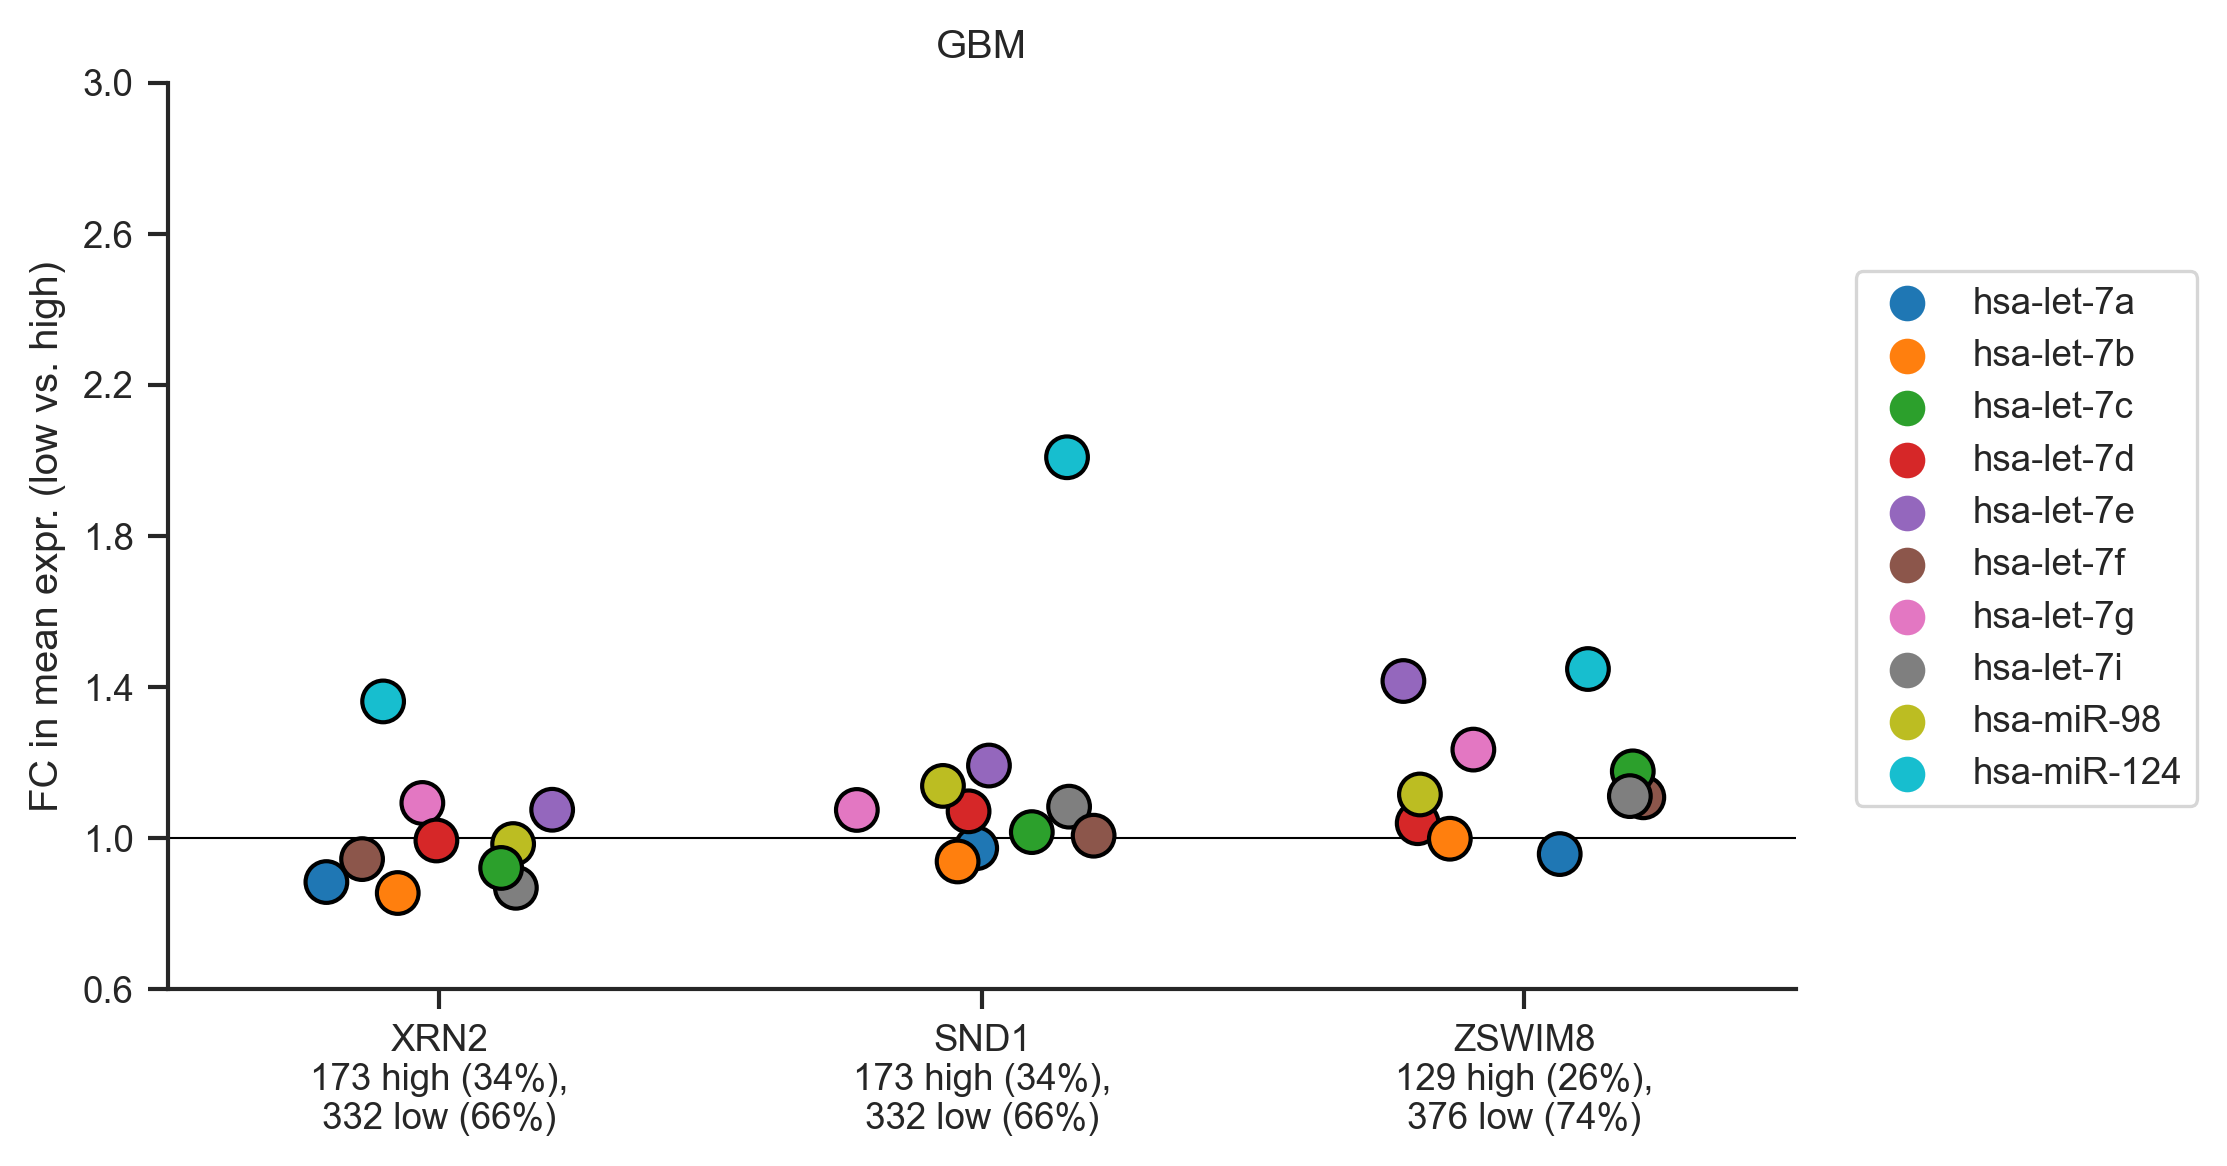

In [11]:
fc_data2 = analyze_tumor_data_simple(
    "gbm",
    [],
    [],
    gse_file="", #'GBM_DATA/go_enriched_x2_let7_gbm.csv',
    optimize_miRNAs=["hsa-let-7c", "hsa-let-7g"],
    label_miRNAs=mirna_columns_of_interest + ["hsa-miR-124"],
    sample_cache_file="GBM_DATA/gbm_sample_subset_3.csv.gz"
)
view2 = fc_data2.loc[mirna_cols]
view2 = view2[
    (view2[f"Corr. with {basis_columns[0]}"] < 0)
    & (view2[f"FC {basis_columns[0]} High-Low"] < 1)
]
view2

In [12]:
fc_data3 = analyze_tumor_data_simple(
    "luad",
    [],
    [],
    gse_file="",
    optimize_miRNAs=["hsa-let-7c", "hsa-let-7g"],
    label_miRNAs=mirna_columns_of_interest + ["hsa-miR-29a"],
    sample_cache_file="LUAD_DATA/luad_sample_subset_5.csv.gz"
)
view3 = fc_data3.loc[mirna_cols]
view3 = view3[
    (view3[f"Corr. with {basis_columns[0]}"] < 0)
    & (view3[f"FC {basis_columns[0]} High-Low"] < 1)
]
view3

Trimmed 3666 columns
Cached data file provided, utilizing that
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

NRAS_XRN2 Low v.s. NRAS_XRN2 High: t-test independent samples with Bonferroni correction, P_val=3.029e-14 stat=-8.097e+00
KRAS_XRN2 Low v.s. KRAS_XRN2 High: t-test independent samples with Bonferroni correction, P_val=5.627e-04 stat=-3.941e+00
MYC_XRN2 Low v.s. MYC_XRN2 High: t-test independent samples with Bonferroni correction, P_val=7.315e-01 stat=-1.550e+00
HMGA2_XRN2 Low v.s. HMGA2_XRN2 High: t-test independent samples with Bonferroni correction, P_val=3.112e-02 stat=-2.809e+00
CDC25A_XRN2 Low v.s. CDC25A_XRN2 High: t-test independent samples with Bonferroni correction, P_val=2.070e-03 stat=-3.606e+00
KLK6_XRN2 Low v.s. KLK6_XRN2 High: t-test independent samples with Bonferroni correction, P_val=9.085e-01 stat=-1.437e+00
p-value annotation legend:
ns: 5.00e-

In [ ]:
# view1 = view1.sort_values(by=f'Corr. with {basis_columns[0]}')
# view2 = view2.sort_values(by=f'Corr. with {basis_columns[0]}')
# view3 = view3.sort_values(by=f'Corr. with {basis_columns[0]}')
# with pd.ExcelWriter('-ve_miRNAs.xlsx', engine='openpyxl') as out_xlsx:
#     view1.to_excel(out_xlsx, sheet_name='hpcc')
#     view2.to_excel(out_xlsx, sheet_name='gbm')
#     view3.to_excel(out_xlsx, sheet_name='luad')